In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader, Batch
from torch.utils.data import DataLoader as TorchDataLoader, Subset
from itertools import combinations
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from utils2 import load_all_weights, FocalLoss, load_data
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
import torch.nn as nn
from torch_geometric.nn import GraphNorm, GCNConv, GATConv, global_add_pool as gap
from torch_geometric.data import Data, Batch
from torch_geometric.utils import add_self_loops
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
import io
import random
import pandas as pd  
import warnings
from matplotlib.colors import LinearSegmentedColormap
warnings.filterwarnings("ignore")

from torch_geometric.data import DataLoader as TorchDataLoader, Batch
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from torch_geometric.nn import MLP
import sys
torch.set_printoptions(threshold=sys.maxsize)

def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)  
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)  
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(2)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
rng = np.random.default_rng(8888)
rfloat = rng.random()


In [2]:
import torch_scatter

def scatter_(name, src, index, dim_size=None):
    r"""Aggregates all values from the :attr:`src` tensor at the indices
    specified in the :attr:`index` tensor along the first dimension.
    If multiple indices reference the same location, their contributions
    are aggregated according to :attr:`name` (either :obj:`"add"`,
    :obj:`"mean"` or :obj:`"max"`).

    Args:
        name (string): The aggregation to use (:obj:`"add"`, :obj:`"mean"`,
            :obj:`"max"`).
        src (Tensor): The source tensor.
        index (LongTensor): The indices of elements to scatter.
        dim_size (int, optional): Automatically create output tensor with size
            :attr:`dim_size` in the first dimension. If set to :attr:`None`, a
            minimal sized output tensor is returned. (default: :obj:`None`)

    :rtype: :class:`Tensor`
    """

    assert name in ['add', 'mean', 'max']

    op = getattr(torch_scatter, 'scatter_{}'.format(name))
    fill_value = -1e9 if name == 'max' else 0

    out = op(src, index, 0, None, dim_size)
    if isinstance(out, tuple):
        out = out[0]

    if name == 'max':
        out[out == fill_value] = 0

    return out

import torch
from torch_scatter import scatter_max, scatter_add

from torch_geometric.utils.num_nodes import maybe_num_nodes


def softmax(src, index, num_nodes=None):
    r"""Computes a sparsely evaluated softmax.
    Given a value tensor :attr:`src`, this function first groups the values
    along the first dimension based on the indices specified in :attr:`index`,
    and then proceeds to compute the softmax individually for each group.

    Args:
        src (Tensor): The source tensor.
        index (LongTensor): The indices of elements for applying the softmax.
        num_nodes (int, optional): The number of nodes, *i.e.*
            :obj:`max_val + 1` of :attr:`index`. (default: :obj:`None`)

    :rtype: :class:`Tensor`
    """

    num_nodes = maybe_num_nodes(index, num_nodes)

    out = src - scatter_max(src, index, dim=0, dim_size=num_nodes)[0][index]
    out = out.exp()
    out = out / (
        scatter_add(out, index, dim=0, dim_size=num_nodes)[index] + 1e-16)

    return out

from torch_geometric.nn.inits import reset

class GlobalAttention(torch.nn.Module):
    r"""Global soft attention layer from the `"Gated Graph Sequence Neural
    Networks" <https://arxiv.org/abs/1511.05493>`_ paper
    """
    def __init__(self, gate_nn, nn=None):
        super(GlobalAttention, self).__init__()
        self.gate_nn = gate_nn
        self.nn = nn

        self.reset_parameters()

    def reset_parameters(self):
        reset(self.gate_nn)
        reset(self.nn)


    def forward(self, x, batch, size=None):
        x = x.unsqueeze(-1) if x.dim() == 1 else x
        size = batch[-1].item() + 1 if size is None else size

        gate = self.gate_nn(x).view(-1, 1)
        x = self.nn(x) if self.nn is not None else x
        assert gate.dim() == x.dim() and gate.size(0) == x.size(0)
        gate = softmax(gate, batch, size)
        out = scatter_('add', gate * x, batch, size)

        return out, gate


    def __repr__(self):
        return '{}(gate_nn={}, nn={})'.format(self.__class__.__name__,
                                              self.gate_nn, self.nn)


======================= Fold 1/20 test start =======================

Fold 1 - Test Results:
  Task 0 (liv): Loss=nan, AUC=0.8442, PR AUC=0.9038, Accuracy=0.7222
  Task 1 (lun): Loss=nan, AUC=0.7407, PR AUC=0.7723, Accuracy=0.7222
  Task 2 (sto): Loss=nan, AUC=0.9630, PR AUC=0.9627, Accuracy=0.8889
  Task 3 (mgl): Loss=nan, AUC=0.7160, PR AUC=0.7473, Accuracy=0.6667

======================= Fold 2/20 test start =======================

Fold 2 - Test Results:
  Task 0 (liv): Loss=nan, AUC=0.5556, PR AUC=0.5058, Accuracy=0.6471
  Task 1 (lun): Loss=nan, AUC=0.7222, PR AUC=0.7519, Accuracy=0.6471
  Task 2 (sto): Loss=nan, AUC=0.8611, PR AUC=0.8714, Accuracy=0.7647
  Task 3 (mgl): Loss=nan, AUC=0.6667, PR AUC=0.7192, Accuracy=0.5882

======================= Fold 3/20 test start =======================

Fold 3 - Test Results:
  Task 0 (liv): Loss=nan, AUC=0.7917, PR AUC=0.8622, Accuracy=0.7059
  Task 1 (lun): Loss=nan, AUC=0.8333, PR AUC=0.8888, Accuracy=0.7647
  Task 2 (sto): Loss=nan, AU

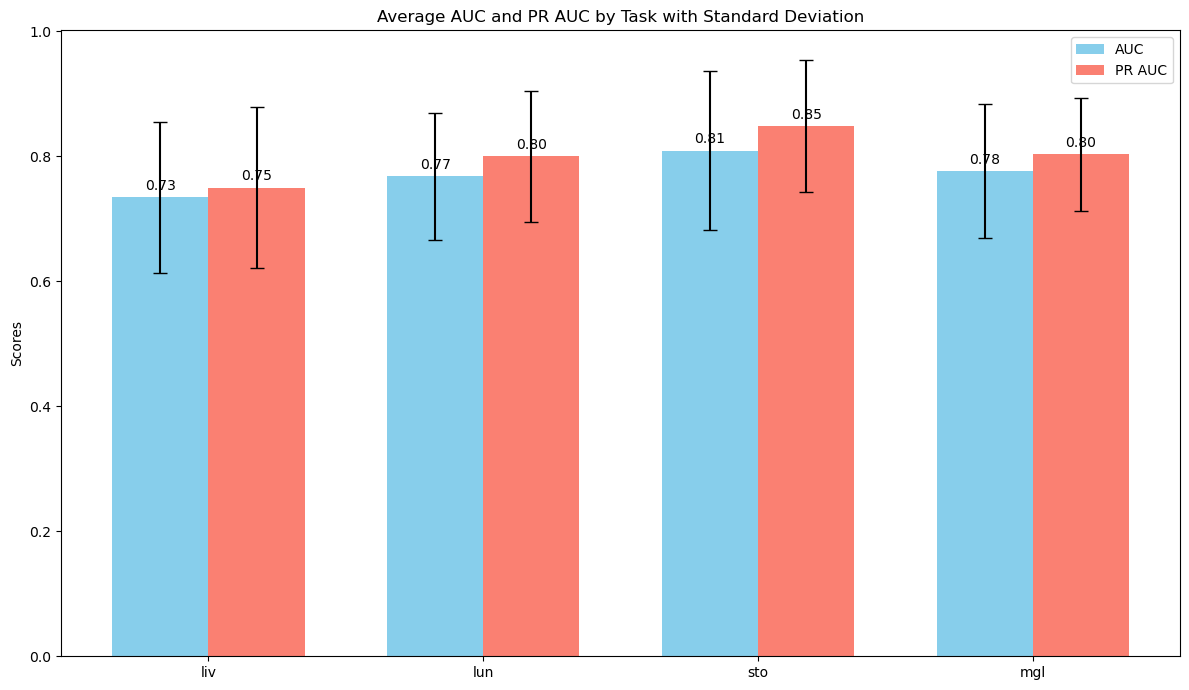

Saved predictions for task 'liv' to prediction_results/liv_predictions.csv
Saved predictions for task 'lun' to prediction_results/lun_predictions.csv
Saved predictions for task 'sto' to prediction_results/sto_predictions.csv
Saved predictions for task 'mgl' to prediction_results/mgl_predictions.csv

Folds with the highest average PR AUC: Fold 14 with PR AUC=0.9689

Folds with the lowest average PR AUC: Fold 8 with PR AUC=0.6127

Number of 0s and 1s for each task in Fold 14:
  Task 0 (liv): Number of zeros= 7, Number of 1s = 10
  Task 1 (lun): Number of zeros= 7, Number of 1s = 10
  Task 2 (sto): Number of zeros= 7, Number of 1s = 10
  Task 3 (mgl): Number of zeros= 9, Number of 1s = 8

Task liv - Visualise the attachment weights of Fold 14:
Top 1 SMILES: CC1CN(CC(N1)C)N=O, Prob: 0.5516
  Attention Scores: [0.1438872516155243, 0.13791944086551666, 0.061875540763139725, 0.05642334744334221, 0.061875540763139725, 0.13791944086551666, 0.1465393304824829, 0.1438872516155243, 0.0546655915677

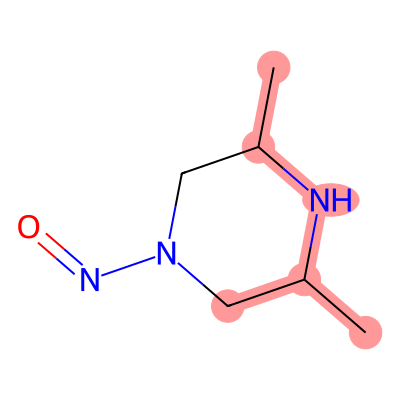

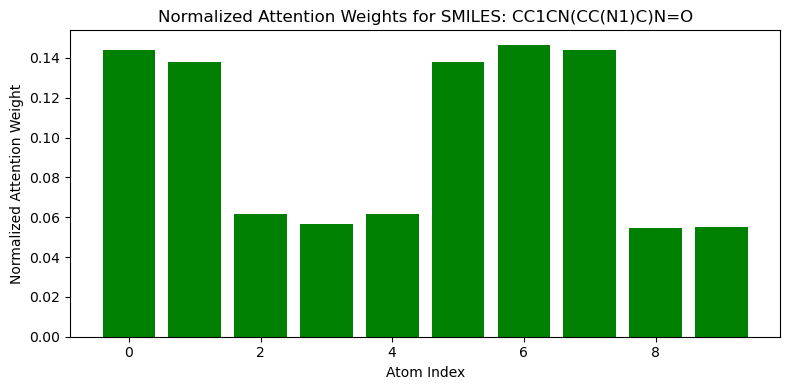

Top 2 SMILES: C1CCN(CC1)N=O, Prob: 0.5373
  Attention Scores: [0.18448711931705475, 0.18448711931705475, 0.09446610510349274, 0.08791358768939972, 0.09446610510349274, 0.18448711931705475, 0.08255447447299957, 0.08713828027248383]
SMILES: C1CCN(CC1)N=O
  Atom 0 (C): Attention Score = 0.1845
  Atom 1 (C): Attention Score = 0.1845
  Atom 2 (C): Attention Score = 0.0945
  Atom 3 (N): Attention Score = 0.0879
  Atom 4 (C): Attention Score = 0.0945
  Atom 5 (C): Attention Score = 0.1845
  Atom 6 (N): Attention Score = 0.0826
  Atom 7 (O): Attention Score = 0.0871


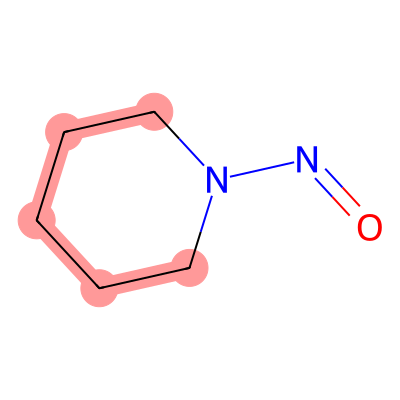

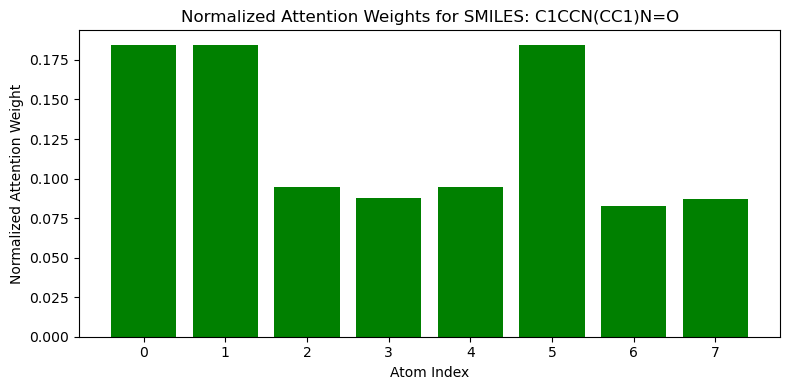

Top 3 SMILES: CCCCNC(=O)N(CCCC)N=O, Prob: 0.5288
  Attention Scores: [0.1069340780377388, 0.09079717844724655, 0.060954611748456955, 0.10977412015199661, 0.0946340262889862, 0.05956616252660751, 0.046536099165678024, 0.04219464957714081, 0.046007901430130005, 0.060954611748456955, 0.09079719334840775, 0.1069340780377388, 0.041644513607025146, 0.04227074980735779]
SMILES: CCCCNC(=O)N(CCCC)N=O
  Atom 0 (C): Attention Score = 0.1069
  Atom 1 (C): Attention Score = 0.0908
  Atom 2 (C): Attention Score = 0.0610
  Atom 3 (C): Attention Score = 0.1098
  Atom 4 (N): Attention Score = 0.0946
  Atom 5 (C): Attention Score = 0.0596
  Atom 6 (O): Attention Score = 0.0465
  Atom 7 (N): Attention Score = 0.0422
  Atom 8 (C): Attention Score = 0.0460
  Atom 9 (C): Attention Score = 0.0610
  Atom 10 (C): Attention Score = 0.0908
  Atom 11 (C): Attention Score = 0.1069
  Atom 12 (N): Attention Score = 0.0416
  Atom 13 (O): Attention Score = 0.0423


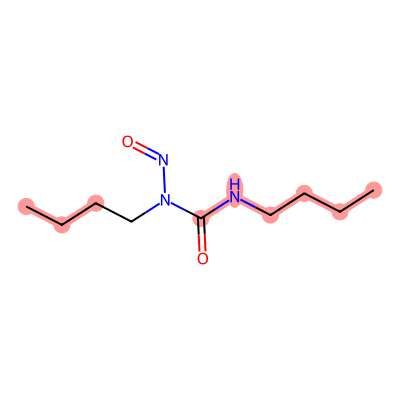

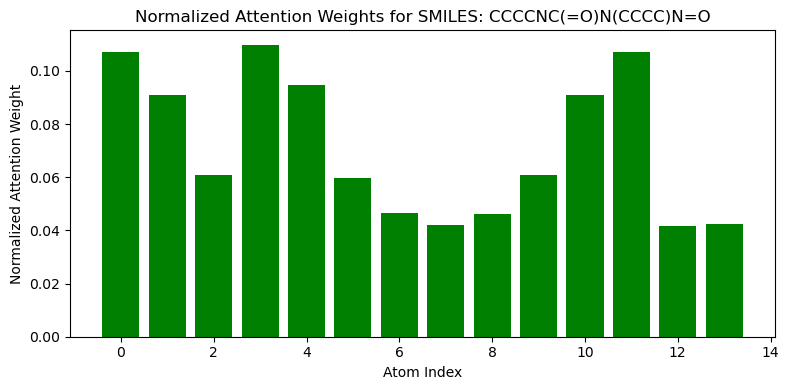

Top 4 SMILES: C1=CC(=CC=C1[N+](=O)[O-])Cl, Prob: 0.5156
  Attention Scores: [0.1412992924451828, 0.1412992924451828, 0.09360326081514359, 0.1412992924451828, 0.1412992924451828, 0.1313273012638092, 0.05283327028155327, 0.05234053358435631, 0.052369341254234314, 0.05232910439372063]
SMILES: C1=CC(=CC=C1[N+](=O)[O-])Cl
  Atom 0 (C): Attention Score = 0.1413
  Atom 1 (C): Attention Score = 0.1413
  Atom 2 (C): Attention Score = 0.0936
  Atom 3 (C): Attention Score = 0.1413
  Atom 4 (C): Attention Score = 0.1413
  Atom 5 (C): Attention Score = 0.1313
  Atom 6 (N): Attention Score = 0.0528
  Atom 7 (O): Attention Score = 0.0523
  Atom 8 (O): Attention Score = 0.0524
  Atom 9 (Cl): Attention Score = 0.0523


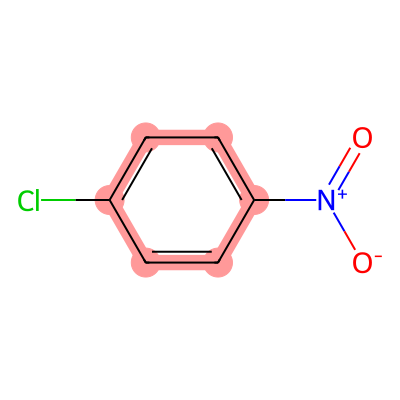

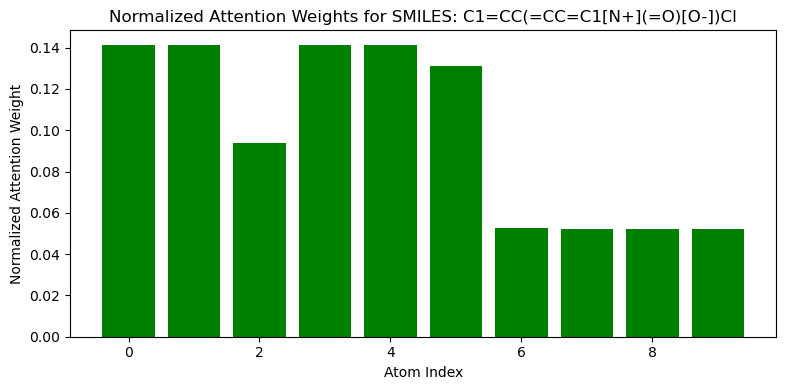

Top 5 SMILES: C1=CC(=CC=C1N)S(=O)(=O)C2=CC=C(C=C2)N, Prob: 0.5153
  Attention Scores: [0.07875444740056992, 0.07875444740056992, 0.03876538574695587, 0.07875444740056992, 0.07875444740056992, 0.07333240658044815, 0.02917673997581005, 0.02922610379755497, 0.029094623401761055, 0.029094623401761055, 0.03876538202166557, 0.07875444740056992, 0.07875444740056992, 0.07333240658044815, 0.07875444740056992, 0.07875444740056992, 0.02917673997581005]
SMILES: C1=CC(=CC=C1N)S(=O)(=O)C2=CC=C(C=C2)N
  Atom 0 (C): Attention Score = 0.0788
  Atom 1 (C): Attention Score = 0.0788
  Atom 2 (C): Attention Score = 0.0388
  Atom 3 (C): Attention Score = 0.0788
  Atom 4 (C): Attention Score = 0.0788
  Atom 5 (C): Attention Score = 0.0733
  Atom 6 (N): Attention Score = 0.0292
  Atom 7 (S): Attention Score = 0.0292
  Atom 8 (O): Attention Score = 0.0291
  Atom 9 (O): Attention Score = 0.0291
  Atom 10 (C): Attention Score = 0.0388
  Atom 11 (C): Attention Score = 0.0788
  Atom 12 (C): Attention Score = 0.078

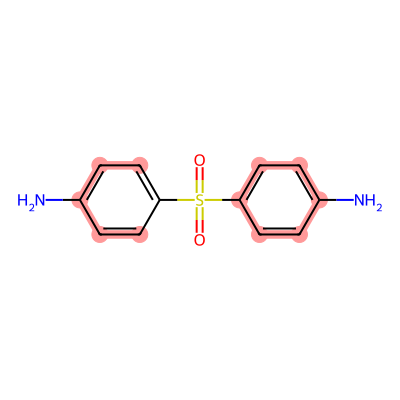

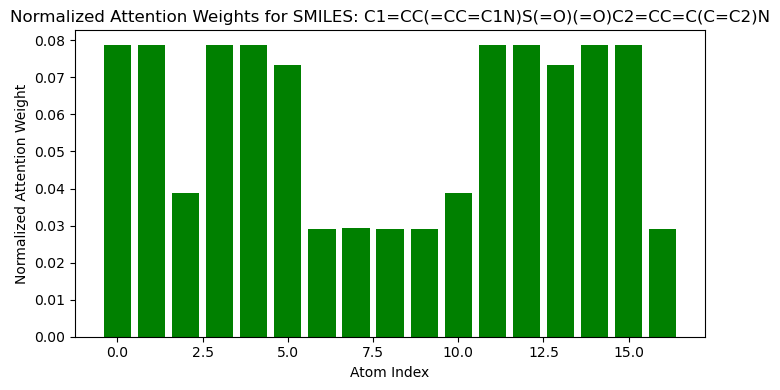

Top 6 SMILES: C1=CC=C(C=C1)C(=O)NN, Prob: 0.5113
  Attention Scores: [0.14013110101222992, 0.14013110101222992, 0.13832318782806396, 0.09490154683589935, 0.13832318782806396, 0.14013110101222992, 0.052238475531339645, 0.05171681568026543, 0.052078090608119965, 0.0520254410803318]
SMILES: C1=CC=C(C=C1)C(=O)NN
  Atom 0 (C): Attention Score = 0.1401
  Atom 1 (C): Attention Score = 0.1401
  Atom 2 (C): Attention Score = 0.1383
  Atom 3 (C): Attention Score = 0.0949
  Atom 4 (C): Attention Score = 0.1383
  Atom 5 (C): Attention Score = 0.1401
  Atom 6 (C): Attention Score = 0.0522
  Atom 7 (O): Attention Score = 0.0517
  Atom 8 (N): Attention Score = 0.0521
  Atom 9 (N): Attention Score = 0.0520


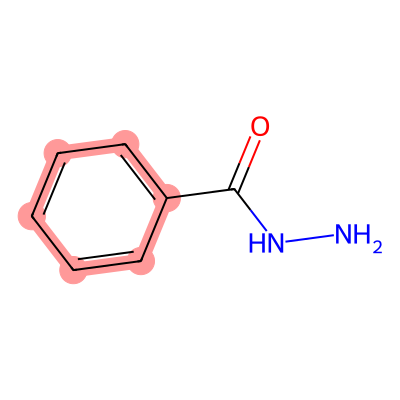

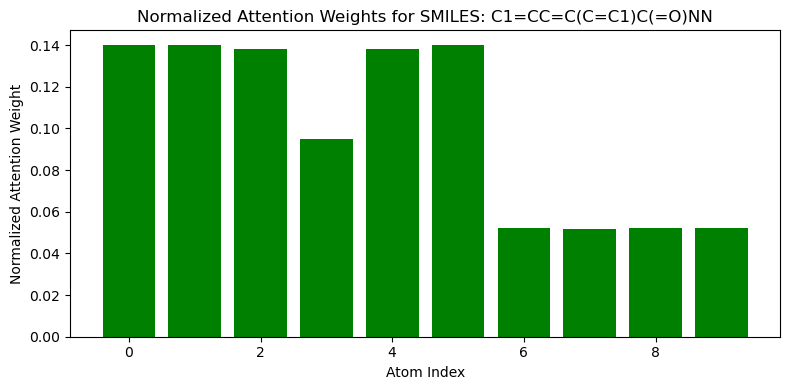

Top 7 SMILES: CNNC, Prob: 0.5060
  Attention Scores: [0.2587524950504303, 0.2412475198507309, 0.2412475198507309, 0.2587524950504303]
SMILES: CNNC
  Atom 0 (C): Attention Score = 0.2588
  Atom 1 (N): Attention Score = 0.2412
  Atom 2 (N): Attention Score = 0.2412
  Atom 3 (C): Attention Score = 0.2588


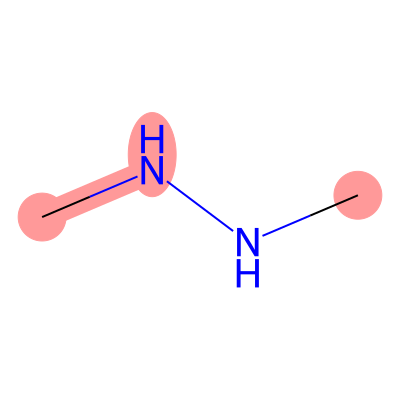

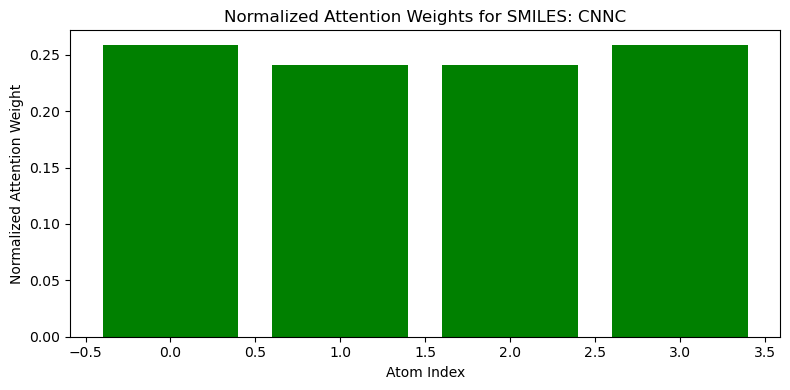

Top 8 SMILES: C1=CC(=CC=C1C2=CSC(=N2)NN)N, Prob: 0.5035
  Attention Scores: [0.10710475593805313, 0.10710475593805313, 0.10394423454999924, 0.10710475593805313, 0.10710475593805313, 0.10596813261508942, 0.05295118689537048, 0.05446439981460571, 0.05443089082837105, 0.0401291698217392, 0.03980984911322594, 0.04026641696691513, 0.040028609335422516, 0.03958810493350029]
SMILES: C1=CC(=CC=C1C2=CSC(=N2)NN)N
  Atom 0 (C): Attention Score = 0.1071
  Atom 1 (C): Attention Score = 0.1071
  Atom 2 (C): Attention Score = 0.1039
  Atom 3 (C): Attention Score = 0.1071
  Atom 4 (C): Attention Score = 0.1071
  Atom 5 (C): Attention Score = 0.1060
  Atom 6 (C): Attention Score = 0.0530
  Atom 7 (C): Attention Score = 0.0545
  Atom 8 (S): Attention Score = 0.0544
  Atom 9 (C): Attention Score = 0.0401
  Atom 10 (N): Attention Score = 0.0398
  Atom 11 (N): Attention Score = 0.0403
  Atom 12 (N): Attention Score = 0.0400
  Atom 13 (N): Attention Score = 0.0396


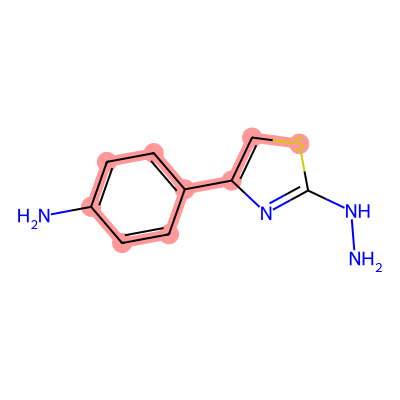

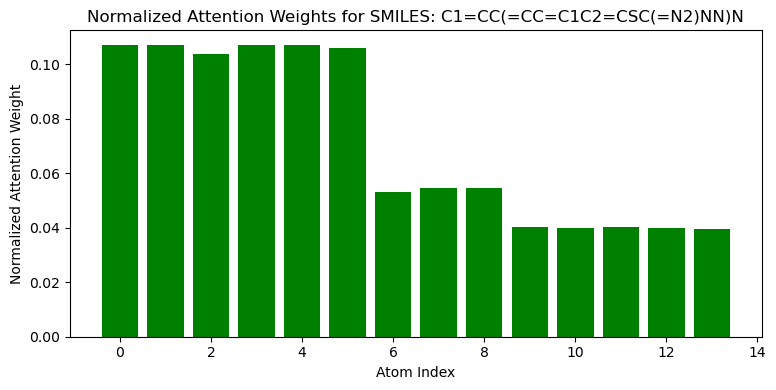

Top 9 SMILES: CCC(=O)N(C1=CC=C(C=C1)/C=C/C2=CC=CC=C2)O, Prob: 0.4832
  Attention Scores: [0.025622574612498283, 0.025576390326023102, 0.025166699662804604, 0.025137994438409805, 0.02519143745303154, 0.02768794819712639, 0.06699109822511673, 0.06699109822511673, 0.0667385384440422, 0.06699109822511673, 0.06699109822511673, 0.0401308611035347, 0.0401308611035347, 0.0667385384440422, 0.06699109822511673, 0.06818810850381851, 0.06818810850381851, 0.06818810850381851, 0.06699109822511673, 0.025367246940732002]
SMILES: CCC(=O)N(C1=CC=C(C=C1)/C=C/C2=CC=CC=C2)O
  Atom 0 (C): Attention Score = 0.0256
  Atom 1 (C): Attention Score = 0.0256
  Atom 2 (C): Attention Score = 0.0252
  Atom 3 (O): Attention Score = 0.0251
  Atom 4 (N): Attention Score = 0.0252
  Atom 5 (C): Attention Score = 0.0277
  Atom 6 (C): Attention Score = 0.0670
  Atom 7 (C): Attention Score = 0.0670
  Atom 8 (C): Attention Score = 0.0667
  Atom 9 (C): Attention Score = 0.0670
  Atom 10 (C): Attention Score = 0.0670
  Atom 11 

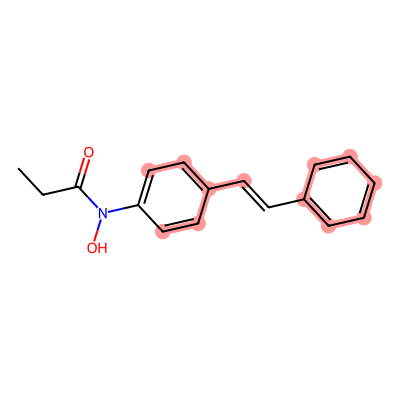

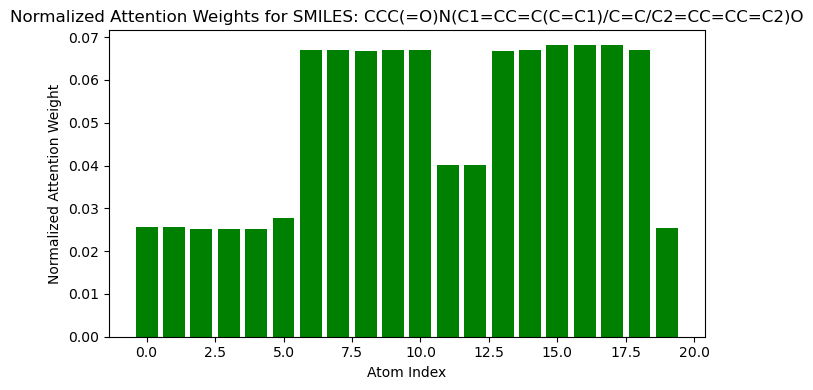

Top 10 SMILES: C(CCl)OP(=O)(OCCCl)OCCCl, Prob: 0.4656
  Attention Scores: [0.1231786236166954, 0.06765854358673096, 0.053287703543901443, 0.053836241364479065, 0.05443483218550682, 0.051681745797395706, 0.053836241364479065, 0.1231786236166954, 0.06765854358673096, 0.053287703543901443, 0.053836241364479065, 0.1231786236166954, 0.06765854358673096, 0.053287703543901443]
SMILES: C(CCl)OP(=O)(OCCCl)OCCCl
  Atom 0 (C): Attention Score = 0.1232
  Atom 1 (C): Attention Score = 0.0677
  Atom 2 (Cl): Attention Score = 0.0533
  Atom 3 (O): Attention Score = 0.0538
  Atom 4 (P): Attention Score = 0.0544
  Atom 5 (O): Attention Score = 0.0517
  Atom 6 (O): Attention Score = 0.0538
  Atom 7 (C): Attention Score = 0.1232
  Atom 8 (C): Attention Score = 0.0677
  Atom 9 (Cl): Attention Score = 0.0533
  Atom 10 (O): Attention Score = 0.0538
  Atom 11 (C): Attention Score = 0.1232
  Atom 12 (C): Attention Score = 0.0677
  Atom 13 (Cl): Attention Score = 0.0533


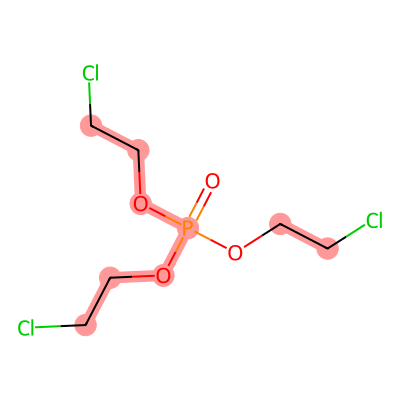

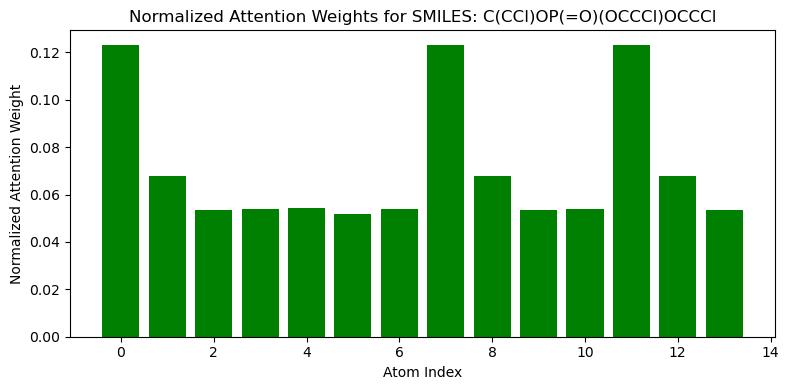


Task lun - Visualise the attachment weights of Fold 14:
Top 1 SMILES: CC1CN(CC(N1)C)N=O, Prob: 0.6353
  Attention Scores: [0.1438872516155243, 0.13791944086551666, 0.061875540763139725, 0.05642334744334221, 0.061875540763139725, 0.13791944086551666, 0.1465393304824829, 0.1438872516155243, 0.054665591567754745, 0.05500723421573639]
SMILES: CC1CN(CC(N1)C)N=O
  Atom 0 (C): Attention Score = 0.1439
  Atom 1 (C): Attention Score = 0.1379
  Atom 2 (C): Attention Score = 0.0619
  Atom 3 (N): Attention Score = 0.0564
  Atom 4 (C): Attention Score = 0.0619
  Atom 5 (C): Attention Score = 0.1379
  Atom 6 (N): Attention Score = 0.1465
  Atom 7 (C): Attention Score = 0.1439
  Atom 8 (N): Attention Score = 0.0547
  Atom 9 (O): Attention Score = 0.0550


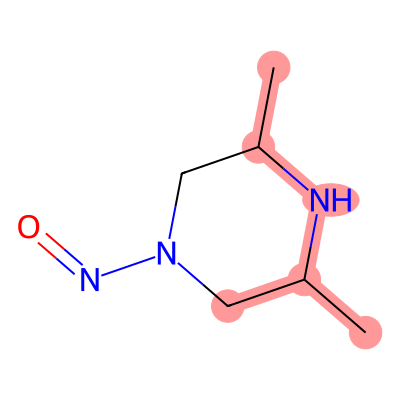

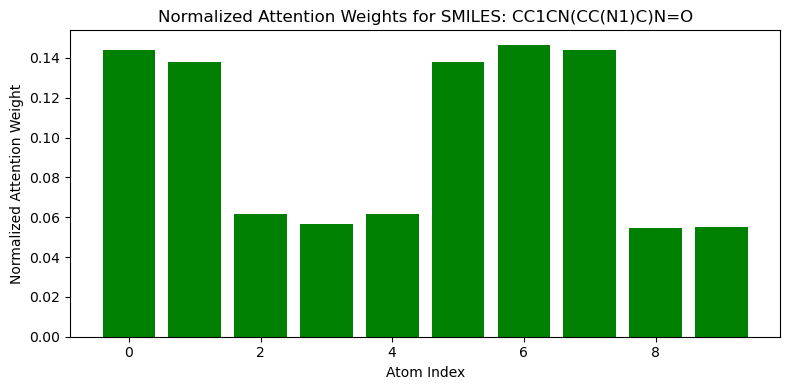

Top 2 SMILES: C1CCN(CC1)N=O, Prob: 0.6220
  Attention Scores: [0.18448711931705475, 0.18448711931705475, 0.09446610510349274, 0.08791358768939972, 0.09446610510349274, 0.18448711931705475, 0.08255447447299957, 0.08713828027248383]
SMILES: C1CCN(CC1)N=O
  Atom 0 (C): Attention Score = 0.1845
  Atom 1 (C): Attention Score = 0.1845
  Atom 2 (C): Attention Score = 0.0945
  Atom 3 (N): Attention Score = 0.0879
  Atom 4 (C): Attention Score = 0.0945
  Atom 5 (C): Attention Score = 0.1845
  Atom 6 (N): Attention Score = 0.0826
  Atom 7 (O): Attention Score = 0.0871


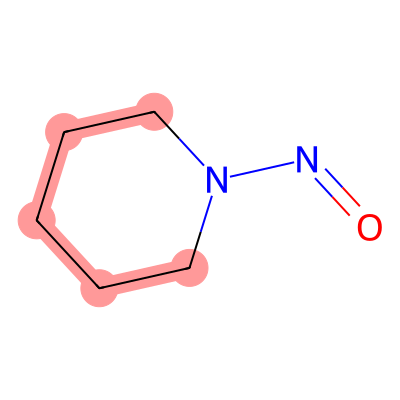

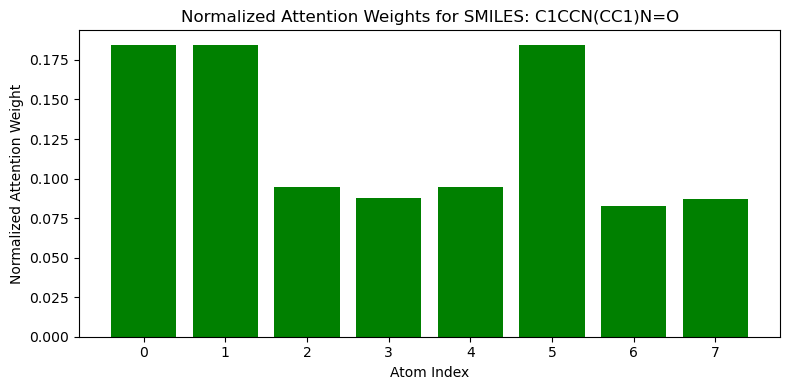

Top 3 SMILES: CCCCNC(=O)N(CCCC)N=O, Prob: 0.5943
  Attention Scores: [0.1069340780377388, 0.09079717844724655, 0.060954611748456955, 0.10977412015199661, 0.0946340262889862, 0.05956616252660751, 0.046536099165678024, 0.04219464957714081, 0.046007901430130005, 0.060954611748456955, 0.09079719334840775, 0.1069340780377388, 0.041644513607025146, 0.04227074980735779]
SMILES: CCCCNC(=O)N(CCCC)N=O
  Atom 0 (C): Attention Score = 0.1069
  Atom 1 (C): Attention Score = 0.0908
  Atom 2 (C): Attention Score = 0.0610
  Atom 3 (C): Attention Score = 0.1098
  Atom 4 (N): Attention Score = 0.0946
  Atom 5 (C): Attention Score = 0.0596
  Atom 6 (O): Attention Score = 0.0465
  Atom 7 (N): Attention Score = 0.0422
  Atom 8 (C): Attention Score = 0.0460
  Atom 9 (C): Attention Score = 0.0610
  Atom 10 (C): Attention Score = 0.0908
  Atom 11 (C): Attention Score = 0.1069
  Atom 12 (N): Attention Score = 0.0416
  Atom 13 (O): Attention Score = 0.0423


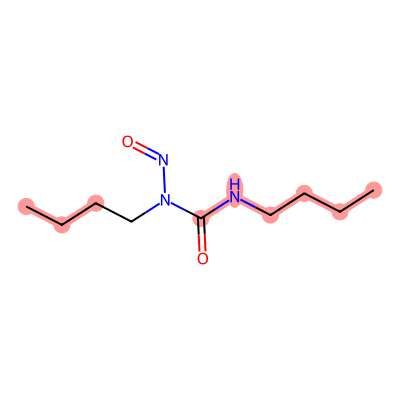

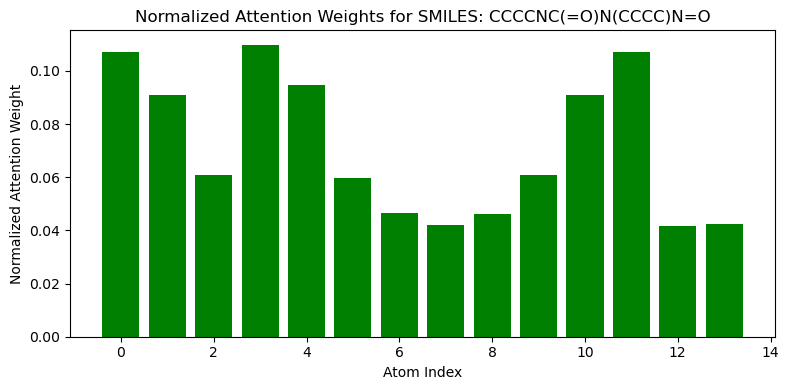

Top 4 SMILES: CNNC, Prob: 0.5865
  Attention Scores: [0.2587524950504303, 0.2412475198507309, 0.2412475198507309, 0.2587524950504303]
SMILES: CNNC
  Atom 0 (C): Attention Score = 0.2588
  Atom 1 (N): Attention Score = 0.2412
  Atom 2 (N): Attention Score = 0.2412
  Atom 3 (C): Attention Score = 0.2588


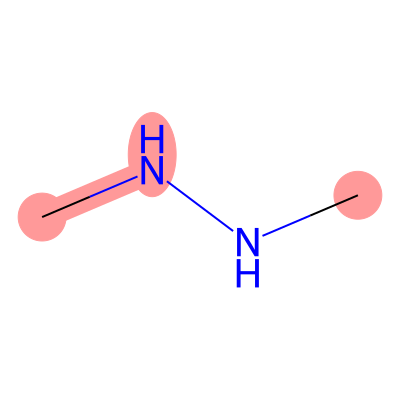

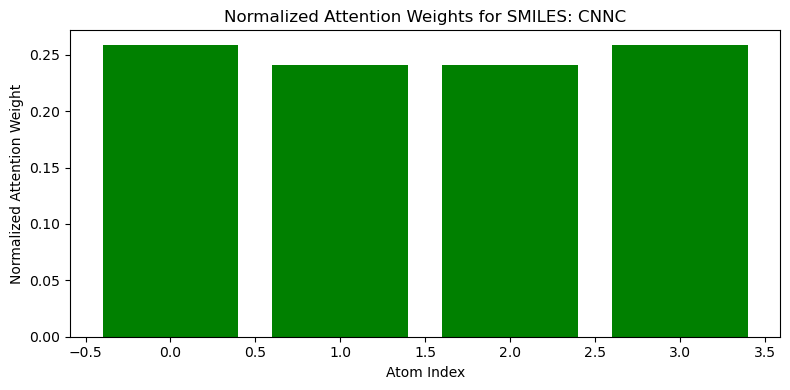

Top 5 SMILES: C1=CC(=CC=C1[N+](=O)[O-])Cl, Prob: 0.5398
  Attention Scores: [0.1412992924451828, 0.1412992924451828, 0.09360326081514359, 0.1412992924451828, 0.1412992924451828, 0.1313273012638092, 0.05283327028155327, 0.05234053358435631, 0.052369341254234314, 0.05232910439372063]
SMILES: C1=CC(=CC=C1[N+](=O)[O-])Cl
  Atom 0 (C): Attention Score = 0.1413
  Atom 1 (C): Attention Score = 0.1413
  Atom 2 (C): Attention Score = 0.0936
  Atom 3 (C): Attention Score = 0.1413
  Atom 4 (C): Attention Score = 0.1413
  Atom 5 (C): Attention Score = 0.1313
  Atom 6 (N): Attention Score = 0.0528
  Atom 7 (O): Attention Score = 0.0523
  Atom 8 (O): Attention Score = 0.0524
  Atom 9 (Cl): Attention Score = 0.0523


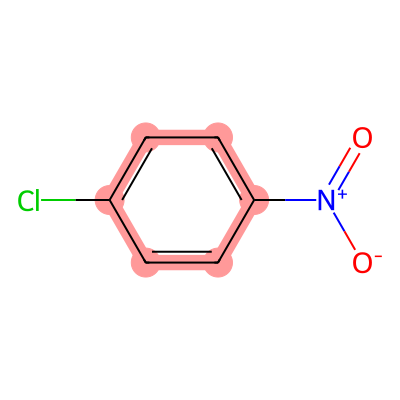

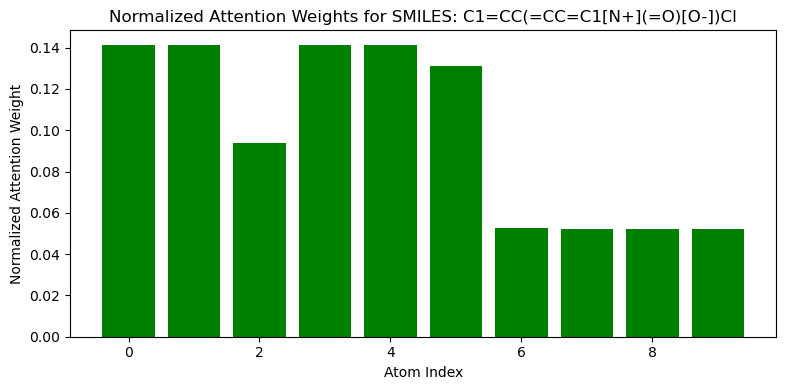

Top 6 SMILES: C1=CC(=CC=C1C2=CSC(=N2)NN)N, Prob: 0.5200
  Attention Scores: [0.10710475593805313, 0.10710475593805313, 0.10394423454999924, 0.10710475593805313, 0.10710475593805313, 0.10596813261508942, 0.05295118689537048, 0.05446439981460571, 0.05443089082837105, 0.0401291698217392, 0.03980984911322594, 0.04026641696691513, 0.040028609335422516, 0.03958810493350029]
SMILES: C1=CC(=CC=C1C2=CSC(=N2)NN)N
  Atom 0 (C): Attention Score = 0.1071
  Atom 1 (C): Attention Score = 0.1071
  Atom 2 (C): Attention Score = 0.1039
  Atom 3 (C): Attention Score = 0.1071
  Atom 4 (C): Attention Score = 0.1071
  Atom 5 (C): Attention Score = 0.1060
  Atom 6 (C): Attention Score = 0.0530
  Atom 7 (C): Attention Score = 0.0545
  Atom 8 (S): Attention Score = 0.0544
  Atom 9 (C): Attention Score = 0.0401
  Atom 10 (N): Attention Score = 0.0398
  Atom 11 (N): Attention Score = 0.0403
  Atom 12 (N): Attention Score = 0.0400
  Atom 13 (N): Attention Score = 0.0396


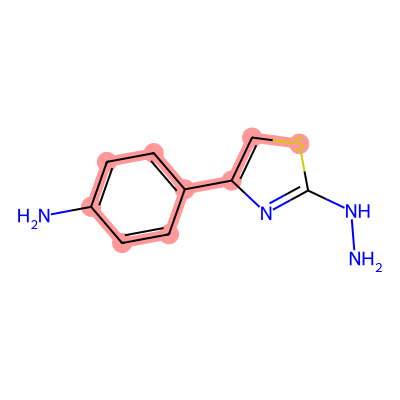

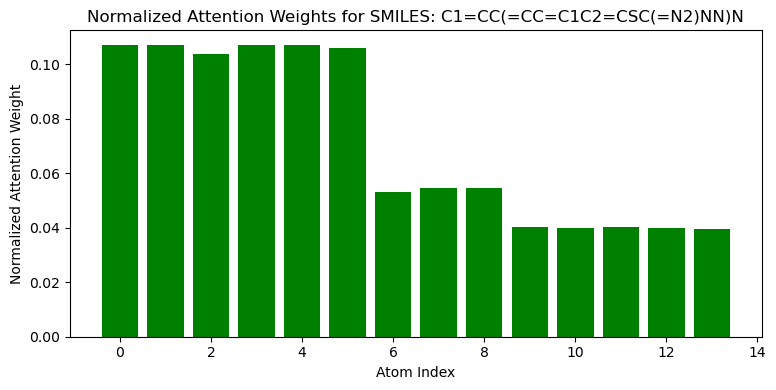

Top 7 SMILES: C1=CC(=CC=C1N)S(=O)(=O)C2=CC=C(C=C2)N, Prob: 0.5116
  Attention Scores: [0.07875444740056992, 0.07875444740056992, 0.03876538574695587, 0.07875444740056992, 0.07875444740056992, 0.07333240658044815, 0.02917673997581005, 0.02922610379755497, 0.029094623401761055, 0.029094623401761055, 0.03876538202166557, 0.07875444740056992, 0.07875444740056992, 0.07333240658044815, 0.07875444740056992, 0.07875444740056992, 0.02917673997581005]
SMILES: C1=CC(=CC=C1N)S(=O)(=O)C2=CC=C(C=C2)N
  Atom 0 (C): Attention Score = 0.0788
  Atom 1 (C): Attention Score = 0.0788
  Atom 2 (C): Attention Score = 0.0388
  Atom 3 (C): Attention Score = 0.0788
  Atom 4 (C): Attention Score = 0.0788
  Atom 5 (C): Attention Score = 0.0733
  Atom 6 (N): Attention Score = 0.0292
  Atom 7 (S): Attention Score = 0.0292
  Atom 8 (O): Attention Score = 0.0291
  Atom 9 (O): Attention Score = 0.0291
  Atom 10 (C): Attention Score = 0.0388
  Atom 11 (C): Attention Score = 0.0788
  Atom 12 (C): Attention Score = 0.078

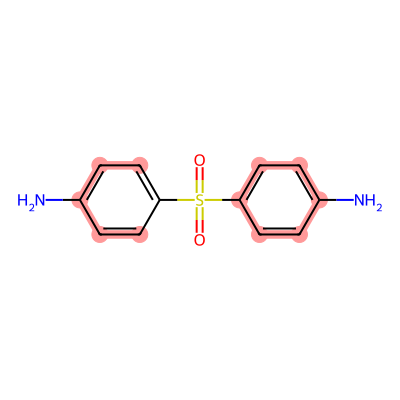

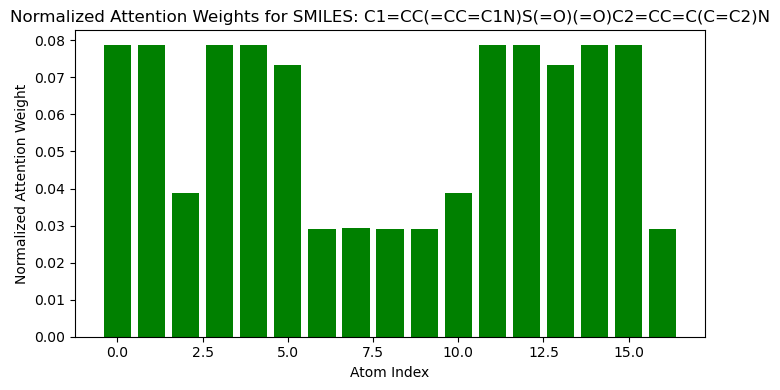

Top 8 SMILES: C(CCl)OP(=O)(OCCCl)OCCCl, Prob: 0.5095
  Attention Scores: [0.1231786236166954, 0.06765854358673096, 0.053287703543901443, 0.053836241364479065, 0.05443483218550682, 0.051681745797395706, 0.053836241364479065, 0.1231786236166954, 0.06765854358673096, 0.053287703543901443, 0.053836241364479065, 0.1231786236166954, 0.06765854358673096, 0.053287703543901443]
SMILES: C(CCl)OP(=O)(OCCCl)OCCCl
  Atom 0 (C): Attention Score = 0.1232
  Atom 1 (C): Attention Score = 0.0677
  Atom 2 (Cl): Attention Score = 0.0533
  Atom 3 (O): Attention Score = 0.0538
  Atom 4 (P): Attention Score = 0.0544
  Atom 5 (O): Attention Score = 0.0517
  Atom 6 (O): Attention Score = 0.0538
  Atom 7 (C): Attention Score = 0.1232
  Atom 8 (C): Attention Score = 0.0677
  Atom 9 (Cl): Attention Score = 0.0533
  Atom 10 (O): Attention Score = 0.0538
  Atom 11 (C): Attention Score = 0.1232
  Atom 12 (C): Attention Score = 0.0677
  Atom 13 (Cl): Attention Score = 0.0533


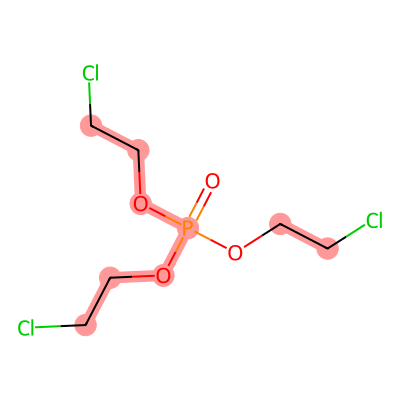

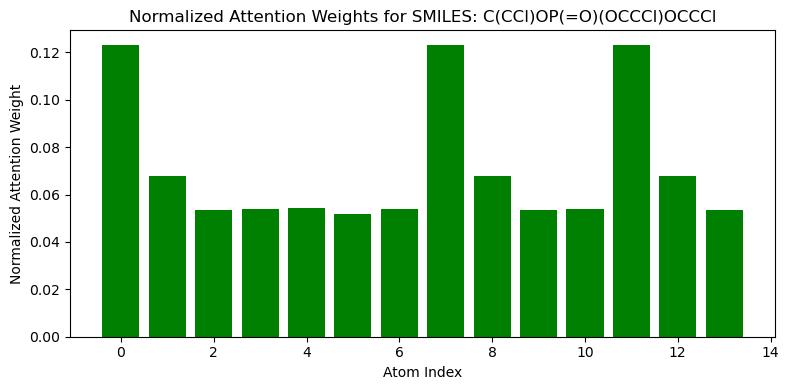

Top 9 SMILES: C1=CC=C(C=C1)C(=O)NN, Prob: 0.5023
  Attention Scores: [0.14013110101222992, 0.14013110101222992, 0.13832318782806396, 0.09490154683589935, 0.13832318782806396, 0.14013110101222992, 0.052238475531339645, 0.05171681568026543, 0.052078090608119965, 0.0520254410803318]
SMILES: C1=CC=C(C=C1)C(=O)NN
  Atom 0 (C): Attention Score = 0.1401
  Atom 1 (C): Attention Score = 0.1401
  Atom 2 (C): Attention Score = 0.1383
  Atom 3 (C): Attention Score = 0.0949
  Atom 4 (C): Attention Score = 0.1383
  Atom 5 (C): Attention Score = 0.1401
  Atom 6 (C): Attention Score = 0.0522
  Atom 7 (O): Attention Score = 0.0517
  Atom 8 (N): Attention Score = 0.0521
  Atom 9 (N): Attention Score = 0.0520


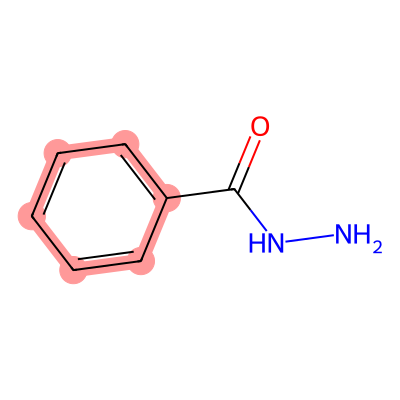

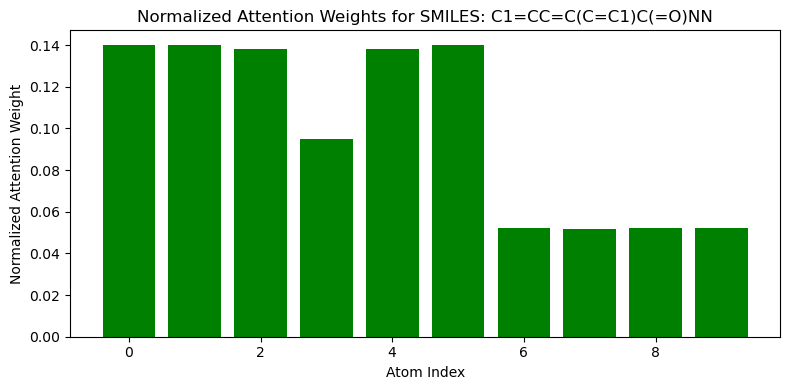

Top 10 SMILES: CCC(=O)N(C1=CC=C(C=C1)/C=C/C2=CC=CC=C2)O, Prob: 0.4622
  Attention Scores: [0.025622574612498283, 0.025576390326023102, 0.025166699662804604, 0.025137994438409805, 0.02519143745303154, 0.02768794819712639, 0.06699109822511673, 0.06699109822511673, 0.0667385384440422, 0.06699109822511673, 0.06699109822511673, 0.0401308611035347, 0.0401308611035347, 0.0667385384440422, 0.06699109822511673, 0.06818810850381851, 0.06818810850381851, 0.06818810850381851, 0.06699109822511673, 0.025367246940732002]
SMILES: CCC(=O)N(C1=CC=C(C=C1)/C=C/C2=CC=CC=C2)O
  Atom 0 (C): Attention Score = 0.0256
  Atom 1 (C): Attention Score = 0.0256
  Atom 2 (C): Attention Score = 0.0252
  Atom 3 (O): Attention Score = 0.0251
  Atom 4 (N): Attention Score = 0.0252
  Atom 5 (C): Attention Score = 0.0277
  Atom 6 (C): Attention Score = 0.0670
  Atom 7 (C): Attention Score = 0.0670
  Atom 8 (C): Attention Score = 0.0667
  Atom 9 (C): Attention Score = 0.0670
  Atom 10 (C): Attention Score = 0.0670
  Atom 11

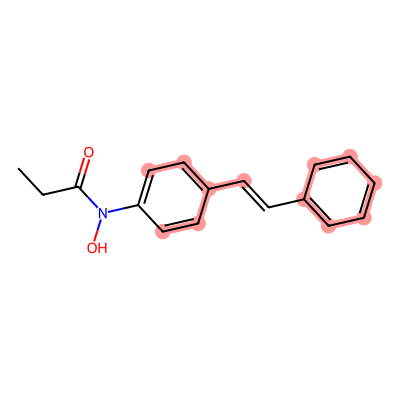

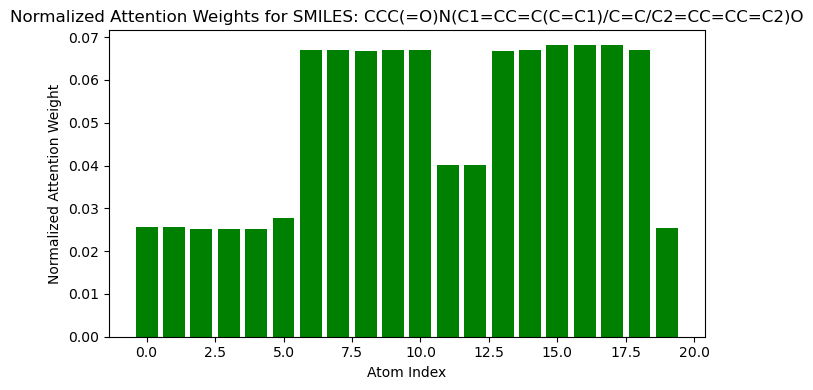


Task sto - Visualise the attachment weights of Fold 14:
Top 1 SMILES: CC1CN(CC(N1)C)N=O, Prob: 0.6695
  Attention Scores: [0.1438872516155243, 0.13791944086551666, 0.061875540763139725, 0.05642334744334221, 0.061875540763139725, 0.13791944086551666, 0.1465393304824829, 0.1438872516155243, 0.054665591567754745, 0.05500723421573639]
SMILES: CC1CN(CC(N1)C)N=O
  Atom 0 (C): Attention Score = 0.1439
  Atom 1 (C): Attention Score = 0.1379
  Atom 2 (C): Attention Score = 0.0619
  Atom 3 (N): Attention Score = 0.0564
  Atom 4 (C): Attention Score = 0.0619
  Atom 5 (C): Attention Score = 0.1379
  Atom 6 (N): Attention Score = 0.1465
  Atom 7 (C): Attention Score = 0.1439
  Atom 8 (N): Attention Score = 0.0547
  Atom 9 (O): Attention Score = 0.0550


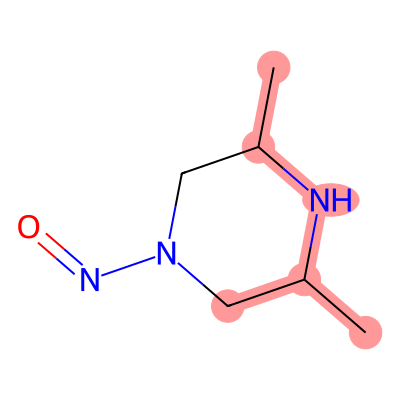

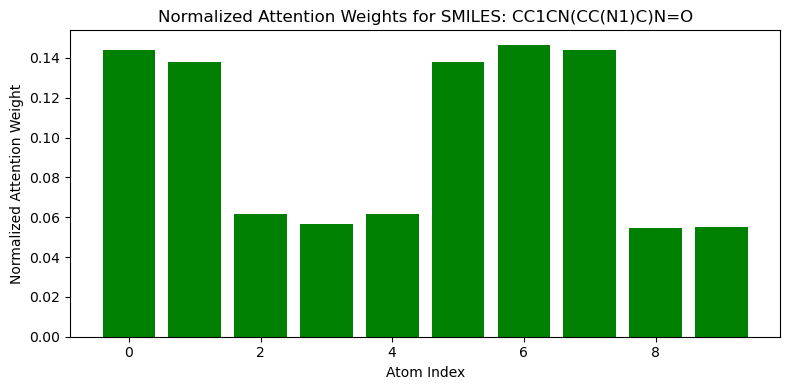

Top 2 SMILES: C1CCN(CC1)N=O, Prob: 0.6387
  Attention Scores: [0.18448711931705475, 0.18448711931705475, 0.09446610510349274, 0.08791358768939972, 0.09446610510349274, 0.18448711931705475, 0.08255447447299957, 0.08713828027248383]
SMILES: C1CCN(CC1)N=O
  Atom 0 (C): Attention Score = 0.1845
  Atom 1 (C): Attention Score = 0.1845
  Atom 2 (C): Attention Score = 0.0945
  Atom 3 (N): Attention Score = 0.0879
  Atom 4 (C): Attention Score = 0.0945
  Atom 5 (C): Attention Score = 0.1845
  Atom 6 (N): Attention Score = 0.0826
  Atom 7 (O): Attention Score = 0.0871


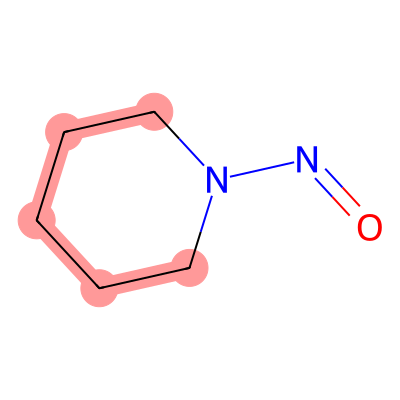

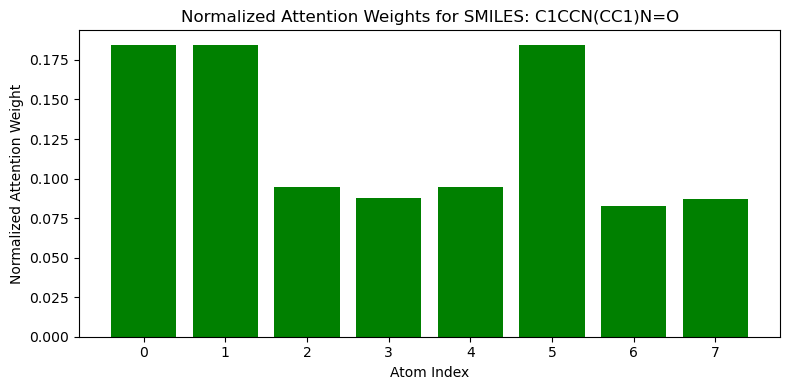

Top 3 SMILES: CCCCNC(=O)N(CCCC)N=O, Prob: 0.6119
  Attention Scores: [0.1069340780377388, 0.09079717844724655, 0.060954611748456955, 0.10977412015199661, 0.0946340262889862, 0.05956616252660751, 0.046536099165678024, 0.04219464957714081, 0.046007901430130005, 0.060954611748456955, 0.09079719334840775, 0.1069340780377388, 0.041644513607025146, 0.04227074980735779]
SMILES: CCCCNC(=O)N(CCCC)N=O
  Atom 0 (C): Attention Score = 0.1069
  Atom 1 (C): Attention Score = 0.0908
  Atom 2 (C): Attention Score = 0.0610
  Atom 3 (C): Attention Score = 0.1098
  Atom 4 (N): Attention Score = 0.0946
  Atom 5 (C): Attention Score = 0.0596
  Atom 6 (O): Attention Score = 0.0465
  Atom 7 (N): Attention Score = 0.0422
  Atom 8 (C): Attention Score = 0.0460
  Atom 9 (C): Attention Score = 0.0610
  Atom 10 (C): Attention Score = 0.0908
  Atom 11 (C): Attention Score = 0.1069
  Atom 12 (N): Attention Score = 0.0416
  Atom 13 (O): Attention Score = 0.0423


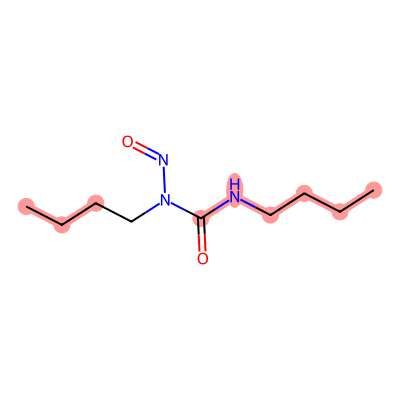

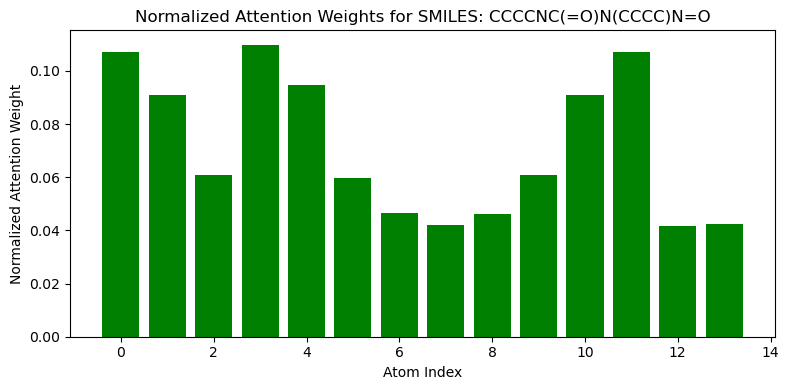

Top 4 SMILES: CC(C1OCC(O1)CO)I, Prob: 0.5532
  Attention Scores: [0.1607993096113205, 0.09282693266868591, 0.06729289889335632, 0.06798996776342392, 0.06799531728029251, 0.06618177890777588, 0.08832160383462906, 0.16378995776176453, 0.16393904387950897, 0.060863275080919266]
SMILES: CC(C1OCC(O1)CO)I
  Atom 0 (C): Attention Score = 0.1608
  Atom 1 (C): Attention Score = 0.0928
  Atom 2 (C): Attention Score = 0.0673
  Atom 3 (O): Attention Score = 0.0680
  Atom 4 (C): Attention Score = 0.0680
  Atom 5 (C): Attention Score = 0.0662
  Atom 6 (O): Attention Score = 0.0883
  Atom 7 (C): Attention Score = 0.1638
  Atom 8 (O): Attention Score = 0.1639
  Atom 9 (I): Attention Score = 0.0609


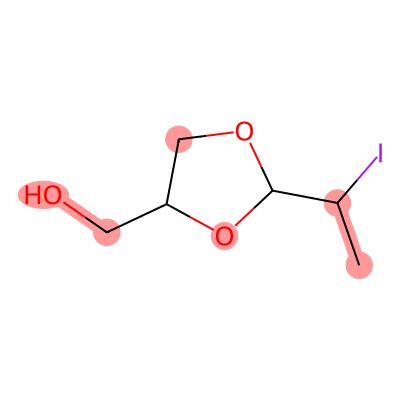

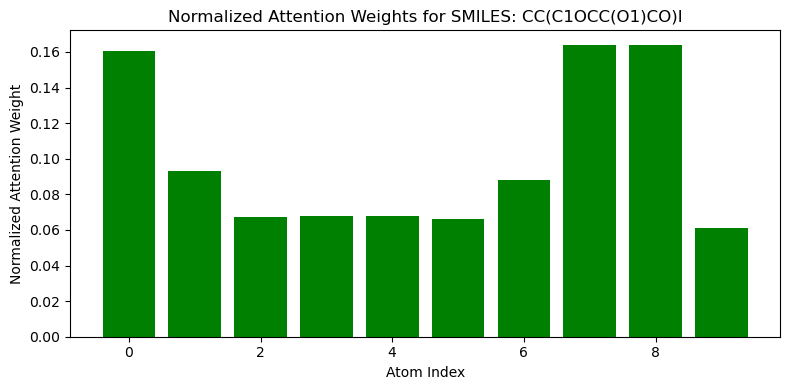

Top 5 SMILES: CNNC, Prob: 0.5401
  Attention Scores: [0.2587524950504303, 0.2412475198507309, 0.2412475198507309, 0.2587524950504303]
SMILES: CNNC
  Atom 0 (C): Attention Score = 0.2588
  Atom 1 (N): Attention Score = 0.2412
  Atom 2 (N): Attention Score = 0.2412
  Atom 3 (C): Attention Score = 0.2588


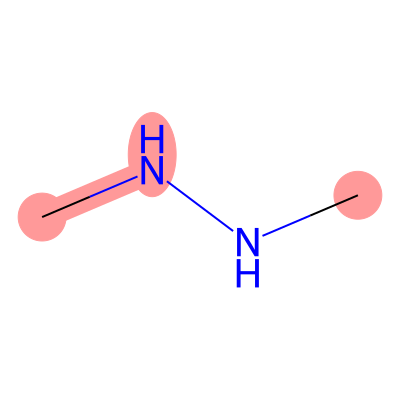

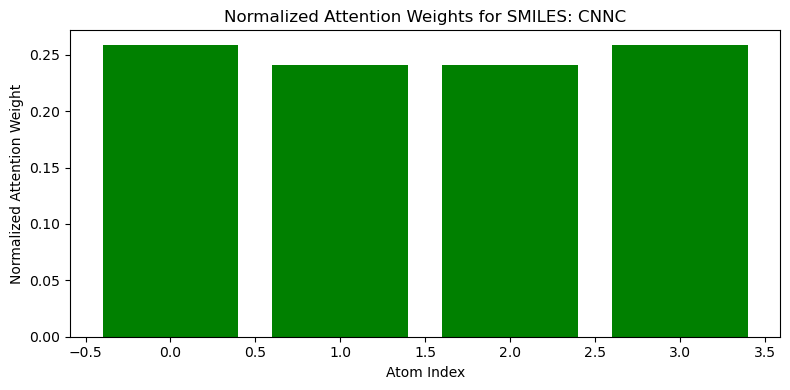

Top 6 SMILES: C1=CC(=CC=C1C2=CSC(=N2)NN)N, Prob: 0.5255
  Attention Scores: [0.10710475593805313, 0.10710475593805313, 0.10394423454999924, 0.10710475593805313, 0.10710475593805313, 0.10596813261508942, 0.05295118689537048, 0.05446439981460571, 0.05443089082837105, 0.0401291698217392, 0.03980984911322594, 0.04026641696691513, 0.040028609335422516, 0.03958810493350029]
SMILES: C1=CC(=CC=C1C2=CSC(=N2)NN)N
  Atom 0 (C): Attention Score = 0.1071
  Atom 1 (C): Attention Score = 0.1071
  Atom 2 (C): Attention Score = 0.1039
  Atom 3 (C): Attention Score = 0.1071
  Atom 4 (C): Attention Score = 0.1071
  Atom 5 (C): Attention Score = 0.1060
  Atom 6 (C): Attention Score = 0.0530
  Atom 7 (C): Attention Score = 0.0545
  Atom 8 (S): Attention Score = 0.0544
  Atom 9 (C): Attention Score = 0.0401
  Atom 10 (N): Attention Score = 0.0398
  Atom 11 (N): Attention Score = 0.0403
  Atom 12 (N): Attention Score = 0.0400
  Atom 13 (N): Attention Score = 0.0396


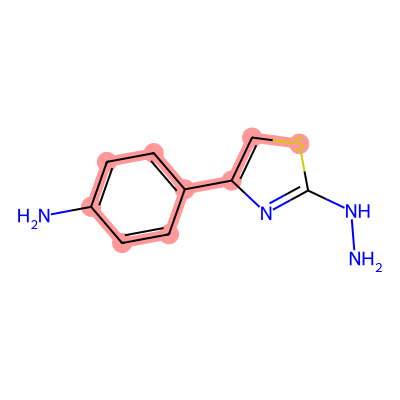

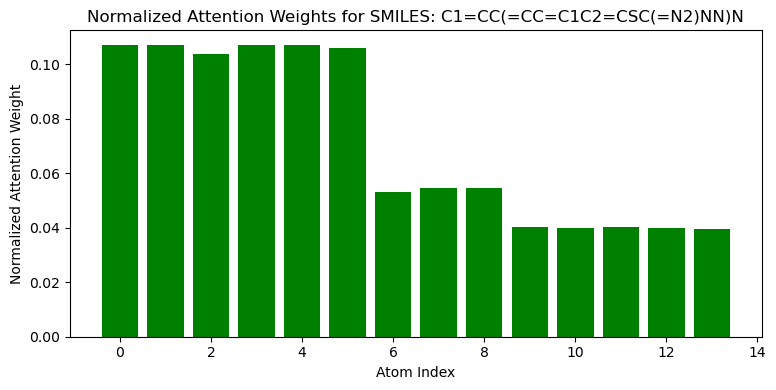

Top 7 SMILES: C1=CC(=CC=C1N)S(=O)(=O)C2=CC=C(C=C2)N, Prob: 0.5252
  Attention Scores: [0.07875444740056992, 0.07875444740056992, 0.03876538574695587, 0.07875444740056992, 0.07875444740056992, 0.07333240658044815, 0.02917673997581005, 0.02922610379755497, 0.029094623401761055, 0.029094623401761055, 0.03876538202166557, 0.07875444740056992, 0.07875444740056992, 0.07333240658044815, 0.07875444740056992, 0.07875444740056992, 0.02917673997581005]
SMILES: C1=CC(=CC=C1N)S(=O)(=O)C2=CC=C(C=C2)N
  Atom 0 (C): Attention Score = 0.0788
  Atom 1 (C): Attention Score = 0.0788
  Atom 2 (C): Attention Score = 0.0388
  Atom 3 (C): Attention Score = 0.0788
  Atom 4 (C): Attention Score = 0.0788
  Atom 5 (C): Attention Score = 0.0733
  Atom 6 (N): Attention Score = 0.0292
  Atom 7 (S): Attention Score = 0.0292
  Atom 8 (O): Attention Score = 0.0291
  Atom 9 (O): Attention Score = 0.0291
  Atom 10 (C): Attention Score = 0.0388
  Atom 11 (C): Attention Score = 0.0788
  Atom 12 (C): Attention Score = 0.078

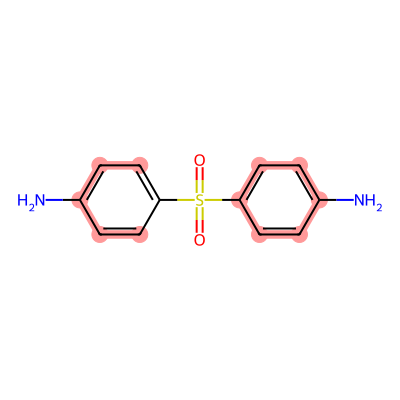

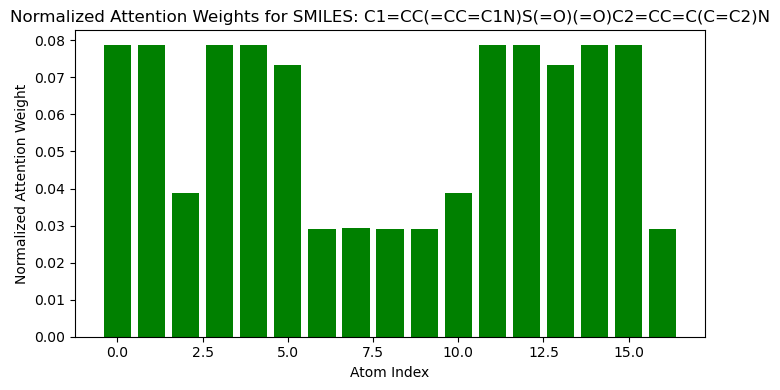

Top 8 SMILES: C1=CC(=CC=C1[N+](=O)[O-])Cl, Prob: 0.5188
  Attention Scores: [0.1412992924451828, 0.1412992924451828, 0.09360326081514359, 0.1412992924451828, 0.1412992924451828, 0.1313273012638092, 0.05283327028155327, 0.05234053358435631, 0.052369341254234314, 0.05232910439372063]
SMILES: C1=CC(=CC=C1[N+](=O)[O-])Cl
  Atom 0 (C): Attention Score = 0.1413
  Atom 1 (C): Attention Score = 0.1413
  Atom 2 (C): Attention Score = 0.0936
  Atom 3 (C): Attention Score = 0.1413
  Atom 4 (C): Attention Score = 0.1413
  Atom 5 (C): Attention Score = 0.1313
  Atom 6 (N): Attention Score = 0.0528
  Atom 7 (O): Attention Score = 0.0523
  Atom 8 (O): Attention Score = 0.0524
  Atom 9 (Cl): Attention Score = 0.0523


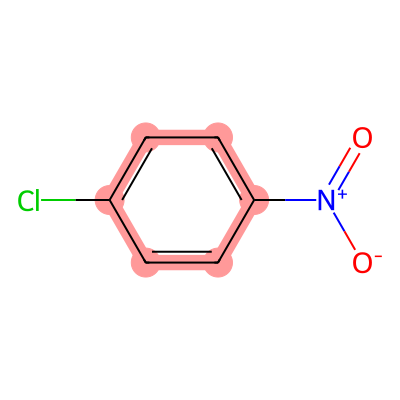

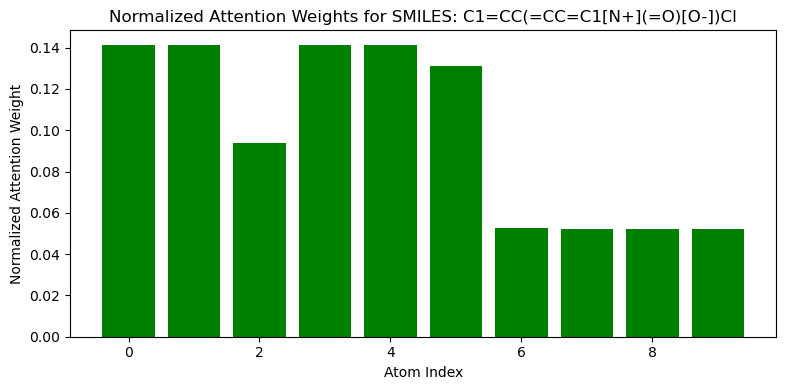

Top 9 SMILES: C1=CC=C(C=C1)C(=O)NN, Prob: 0.4976
  Attention Scores: [0.14013110101222992, 0.14013110101222992, 0.13832318782806396, 0.09490154683589935, 0.13832318782806396, 0.14013110101222992, 0.052238475531339645, 0.05171681568026543, 0.052078090608119965, 0.0520254410803318]
SMILES: C1=CC=C(C=C1)C(=O)NN
  Atom 0 (C): Attention Score = 0.1401
  Atom 1 (C): Attention Score = 0.1401
  Atom 2 (C): Attention Score = 0.1383
  Atom 3 (C): Attention Score = 0.0949
  Atom 4 (C): Attention Score = 0.1383
  Atom 5 (C): Attention Score = 0.1401
  Atom 6 (C): Attention Score = 0.0522
  Atom 7 (O): Attention Score = 0.0517
  Atom 8 (N): Attention Score = 0.0521
  Atom 9 (N): Attention Score = 0.0520


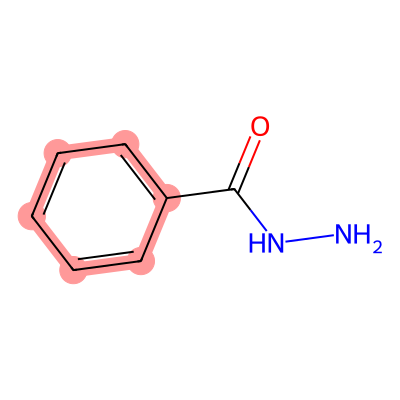

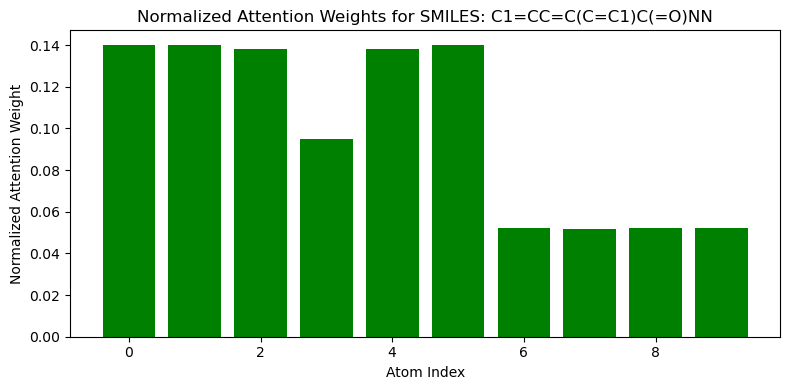

Top 10 SMILES: C(CCl)OP(=O)(OCCCl)OCCCl, Prob: 0.4838
  Attention Scores: [0.1231786236166954, 0.06765854358673096, 0.053287703543901443, 0.053836241364479065, 0.05443483218550682, 0.051681745797395706, 0.053836241364479065, 0.1231786236166954, 0.06765854358673096, 0.053287703543901443, 0.053836241364479065, 0.1231786236166954, 0.06765854358673096, 0.053287703543901443]
SMILES: C(CCl)OP(=O)(OCCCl)OCCCl
  Atom 0 (C): Attention Score = 0.1232
  Atom 1 (C): Attention Score = 0.0677
  Atom 2 (Cl): Attention Score = 0.0533
  Atom 3 (O): Attention Score = 0.0538
  Atom 4 (P): Attention Score = 0.0544
  Atom 5 (O): Attention Score = 0.0517
  Atom 6 (O): Attention Score = 0.0538
  Atom 7 (C): Attention Score = 0.1232
  Atom 8 (C): Attention Score = 0.0677
  Atom 9 (Cl): Attention Score = 0.0533
  Atom 10 (O): Attention Score = 0.0538
  Atom 11 (C): Attention Score = 0.1232
  Atom 12 (C): Attention Score = 0.0677
  Atom 13 (Cl): Attention Score = 0.0533


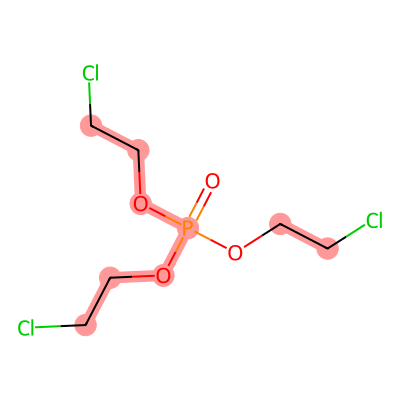

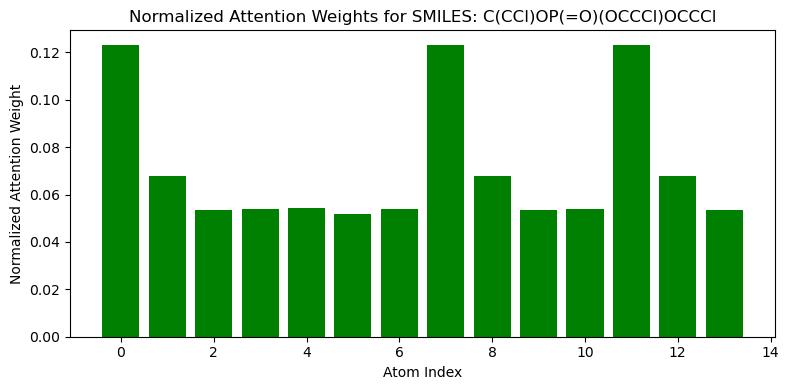


Task mgl - Visualise the attachment weights of Fold 14:
Top 1 SMILES: C1=CC=C(C=C1)C(=O)NN, Prob: 0.5308
  Attention Scores: [0.14013110101222992, 0.14013110101222992, 0.13832318782806396, 0.09490154683589935, 0.13832318782806396, 0.14013110101222992, 0.052238475531339645, 0.05171681568026543, 0.052078090608119965, 0.0520254410803318]
SMILES: C1=CC=C(C=C1)C(=O)NN
  Atom 0 (C): Attention Score = 0.1401
  Atom 1 (C): Attention Score = 0.1401
  Atom 2 (C): Attention Score = 0.1383
  Atom 3 (C): Attention Score = 0.0949
  Atom 4 (C): Attention Score = 0.1383
  Atom 5 (C): Attention Score = 0.1401
  Atom 6 (C): Attention Score = 0.0522
  Atom 7 (O): Attention Score = 0.0517
  Atom 8 (N): Attention Score = 0.0521
  Atom 9 (N): Attention Score = 0.0520


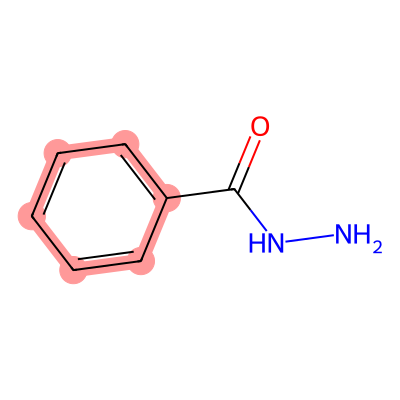

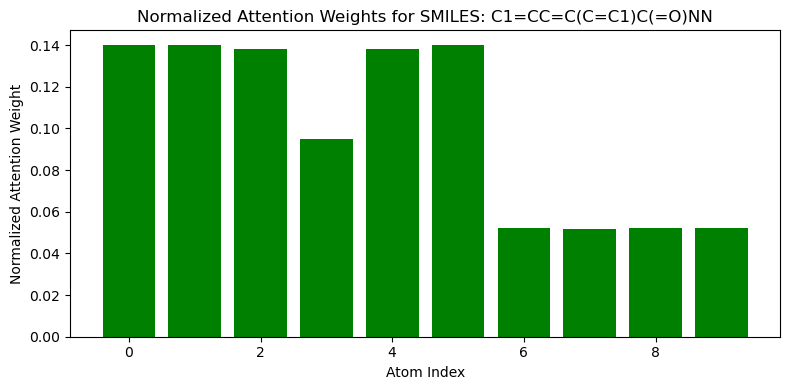

Top 2 SMILES: C1=CC(=CC=C1[N+](=O)[O-])Cl, Prob: 0.5218
  Attention Scores: [0.1412992924451828, 0.1412992924451828, 0.09360326081514359, 0.1412992924451828, 0.1412992924451828, 0.1313273012638092, 0.05283327028155327, 0.05234053358435631, 0.052369341254234314, 0.05232910439372063]
SMILES: C1=CC(=CC=C1[N+](=O)[O-])Cl
  Atom 0 (C): Attention Score = 0.1413
  Atom 1 (C): Attention Score = 0.1413
  Atom 2 (C): Attention Score = 0.0936
  Atom 3 (C): Attention Score = 0.1413
  Atom 4 (C): Attention Score = 0.1413
  Atom 5 (C): Attention Score = 0.1313
  Atom 6 (N): Attention Score = 0.0528
  Atom 7 (O): Attention Score = 0.0523
  Atom 8 (O): Attention Score = 0.0524
  Atom 9 (Cl): Attention Score = 0.0523


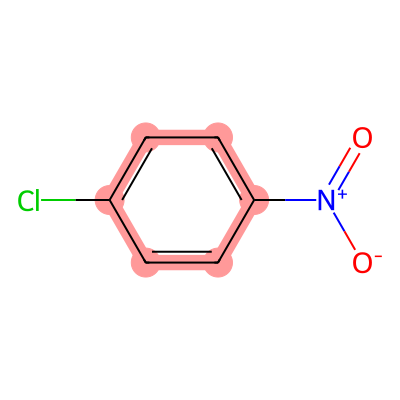

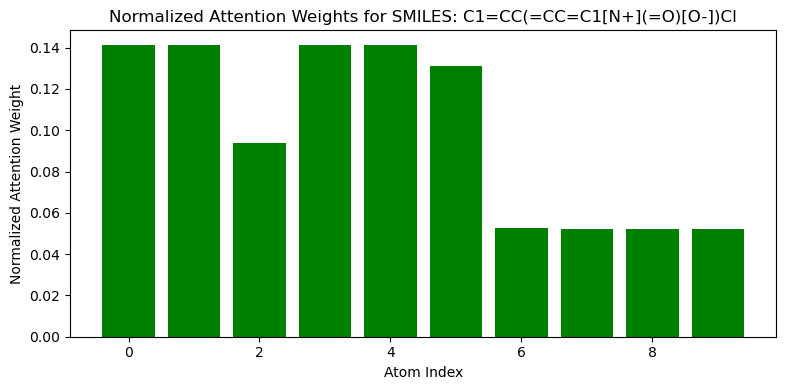

Top 3 SMILES: C1=CC(=CC=C1N)S(=O)(=O)C2=CC=C(C=C2)N, Prob: 0.5098
  Attention Scores: [0.07875444740056992, 0.07875444740056992, 0.03876538574695587, 0.07875444740056992, 0.07875444740056992, 0.07333240658044815, 0.02917673997581005, 0.02922610379755497, 0.029094623401761055, 0.029094623401761055, 0.03876538202166557, 0.07875444740056992, 0.07875444740056992, 0.07333240658044815, 0.07875444740056992, 0.07875444740056992, 0.02917673997581005]
SMILES: C1=CC(=CC=C1N)S(=O)(=O)C2=CC=C(C=C2)N
  Atom 0 (C): Attention Score = 0.0788
  Atom 1 (C): Attention Score = 0.0788
  Atom 2 (C): Attention Score = 0.0388
  Atom 3 (C): Attention Score = 0.0788
  Atom 4 (C): Attention Score = 0.0788
  Atom 5 (C): Attention Score = 0.0733
  Atom 6 (N): Attention Score = 0.0292
  Atom 7 (S): Attention Score = 0.0292
  Atom 8 (O): Attention Score = 0.0291
  Atom 9 (O): Attention Score = 0.0291
  Atom 10 (C): Attention Score = 0.0388
  Atom 11 (C): Attention Score = 0.0788
  Atom 12 (C): Attention Score = 0.078

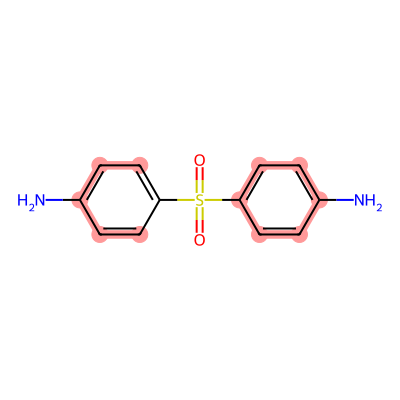

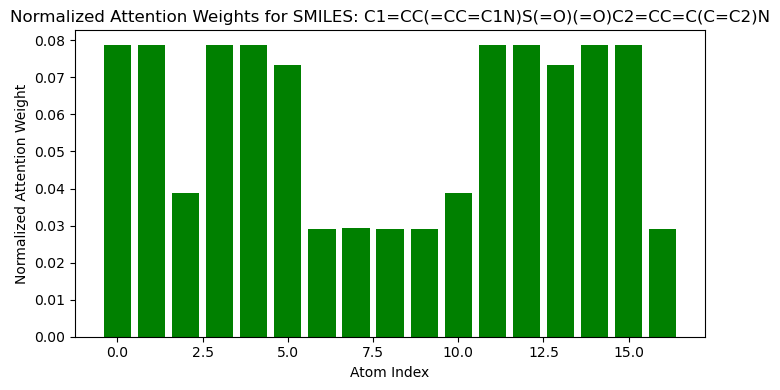

Top 4 SMILES: C1=CC(=CC=C1C2=CSC(=N2)NN)N, Prob: 0.5034
  Attention Scores: [0.10710475593805313, 0.10710475593805313, 0.10394423454999924, 0.10710475593805313, 0.10710475593805313, 0.10596813261508942, 0.05295118689537048, 0.05446439981460571, 0.05443089082837105, 0.0401291698217392, 0.03980984911322594, 0.04026641696691513, 0.040028609335422516, 0.03958810493350029]
SMILES: C1=CC(=CC=C1C2=CSC(=N2)NN)N
  Atom 0 (C): Attention Score = 0.1071
  Atom 1 (C): Attention Score = 0.1071
  Atom 2 (C): Attention Score = 0.1039
  Atom 3 (C): Attention Score = 0.1071
  Atom 4 (C): Attention Score = 0.1071
  Atom 5 (C): Attention Score = 0.1060
  Atom 6 (C): Attention Score = 0.0530
  Atom 7 (C): Attention Score = 0.0545
  Atom 8 (S): Attention Score = 0.0544
  Atom 9 (C): Attention Score = 0.0401
  Atom 10 (N): Attention Score = 0.0398
  Atom 11 (N): Attention Score = 0.0403
  Atom 12 (N): Attention Score = 0.0400
  Atom 13 (N): Attention Score = 0.0396


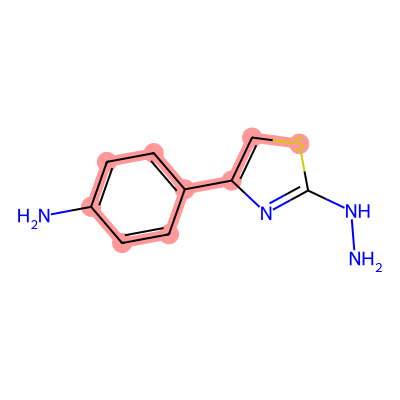

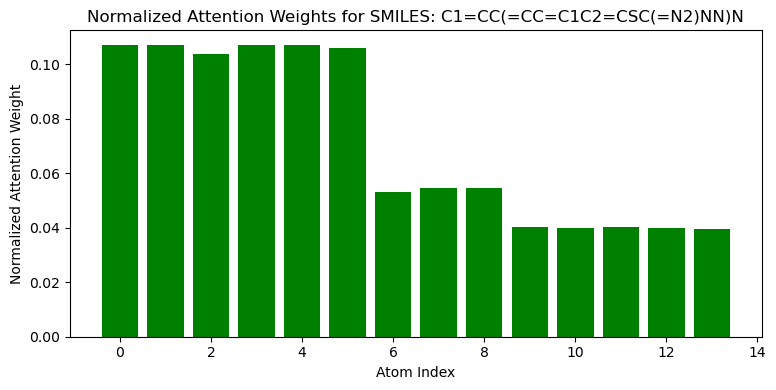

Top 5 SMILES: CCC(=O)N(C1=CC=C(C=C1)/C=C/C2=CC=CC=C2)O, Prob: 0.5008
  Attention Scores: [0.025622574612498283, 0.025576390326023102, 0.025166699662804604, 0.025137994438409805, 0.02519143745303154, 0.02768794819712639, 0.06699109822511673, 0.06699109822511673, 0.0667385384440422, 0.06699109822511673, 0.06699109822511673, 0.0401308611035347, 0.0401308611035347, 0.0667385384440422, 0.06699109822511673, 0.06818810850381851, 0.06818810850381851, 0.06818810850381851, 0.06699109822511673, 0.025367246940732002]
SMILES: CCC(=O)N(C1=CC=C(C=C1)/C=C/C2=CC=CC=C2)O
  Atom 0 (C): Attention Score = 0.0256
  Atom 1 (C): Attention Score = 0.0256
  Atom 2 (C): Attention Score = 0.0252
  Atom 3 (O): Attention Score = 0.0251
  Atom 4 (N): Attention Score = 0.0252
  Atom 5 (C): Attention Score = 0.0277
  Atom 6 (C): Attention Score = 0.0670
  Atom 7 (C): Attention Score = 0.0670
  Atom 8 (C): Attention Score = 0.0667
  Atom 9 (C): Attention Score = 0.0670
  Atom 10 (C): Attention Score = 0.0670
  Atom 11 

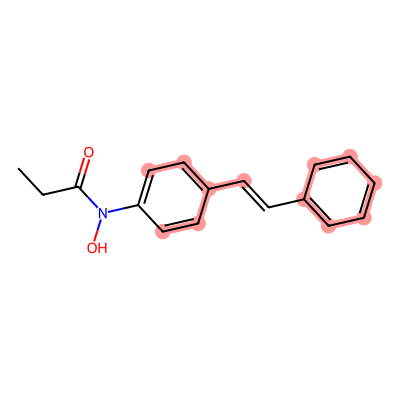

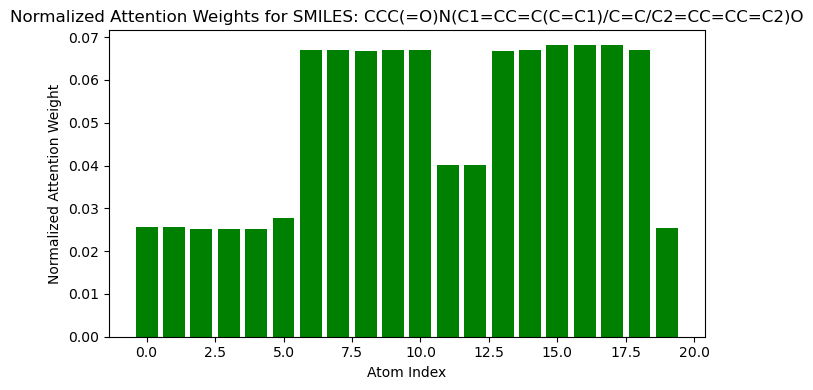

Top 6 SMILES: CCCCNC(=O)N(CCCC)N=O, Prob: 0.4638
  Attention Scores: [0.1069340780377388, 0.09079717844724655, 0.060954611748456955, 0.10977412015199661, 0.0946340262889862, 0.05956616252660751, 0.046536099165678024, 0.04219464957714081, 0.046007901430130005, 0.060954611748456955, 0.09079719334840775, 0.1069340780377388, 0.041644513607025146, 0.04227074980735779]
SMILES: CCCCNC(=O)N(CCCC)N=O
  Atom 0 (C): Attention Score = 0.1069
  Atom 1 (C): Attention Score = 0.0908
  Atom 2 (C): Attention Score = 0.0610
  Atom 3 (C): Attention Score = 0.1098
  Atom 4 (N): Attention Score = 0.0946
  Atom 5 (C): Attention Score = 0.0596
  Atom 6 (O): Attention Score = 0.0465
  Atom 7 (N): Attention Score = 0.0422
  Atom 8 (C): Attention Score = 0.0460
  Atom 9 (C): Attention Score = 0.0610
  Atom 10 (C): Attention Score = 0.0908
  Atom 11 (C): Attention Score = 0.1069
  Atom 12 (N): Attention Score = 0.0416
  Atom 13 (O): Attention Score = 0.0423


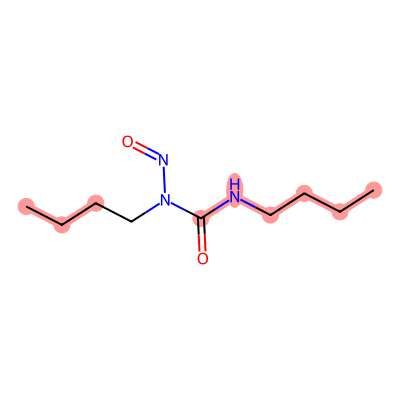

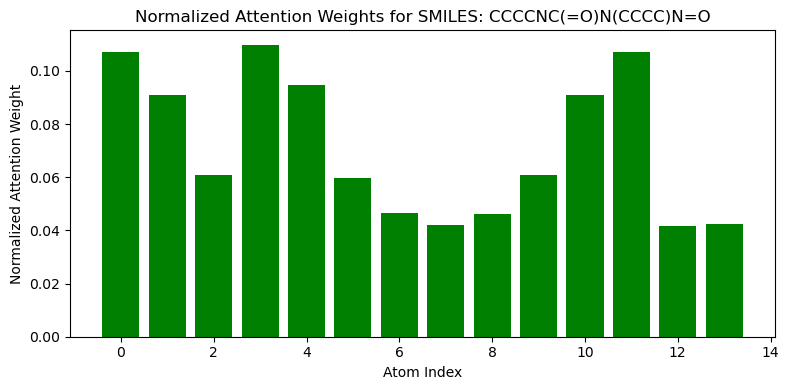


======================= Test and visualisation =======================


In [23]:
class MultiTaskGAT(nn.Module):
    def __init__(self, num_features, n_heads1, output_dim_idx, dropout, num_tasks=4):
        super(MultiTaskGAT, self).__init__()

        self.conv2 = GATConv(num_features, num_features, heads=n_heads1, dropout=dropout)
        self.relu = nn.ReLU()
        self.graph_norm2 = GraphNorm(num_features * n_heads1)
        
        # Generate task combinations (combinations of 3 out of n_tasks)
        self.task_combinations_2 = list(combinations(range(num_tasks), 3))
        
        # Define hidden layers for each task combination
        self.hidden_layer2 = nn.ModuleList([
            nn.Sequential(
                nn.Linear(num_features * n_heads1, output_dim_idx),
                nn.ReLU(),
                nn.Dropout(dropout),
            ) for _ in self.task_combinations_2
        ])
        
        # Defining the final output layer
        self.final_layer = nn.ModuleList([nn.Linear(output_dim_idx, 1) for _ in range(num_tasks)])
        self.sigmoid = nn.Sigmoid()

        self.attention_net = nn.Sequential(
            nn.Linear(num_features * n_heads1, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

        self.global_attention = GlobalAttention(gate_nn=self.attention_net)
        
        self.node_dropout = nn.Dropout(dropout)
        
        self.weight_matrix = nn.Parameter(torch.ones(len(self.task_combinations_2)))

    def forward(self, data, selected_tasks):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x2 = self.conv2(x, edge_index)
        x = self.graph_norm2(x2, batch)
        x = self.relu(x)
        x = self.node_dropout(x)

        # Attention Pooling
        x, attention_scores = self.global_attention(x, batch)

        # hidden_layer2: 3-task combination
        outputs = {task: [] for task in selected_tasks}
        for idx, (layer, combo) in enumerate(zip(self.hidden_layer2, self.task_combinations_2)):
            if set(combo).issubset(selected_tasks):
                output = layer(x)
                weight = self.weight_matrix[idx]
                for task in combo:
                    outputs[task].append(output * weight)
        
        # Combine the output 
        final_outputs = []
        for task in selected_tasks:
            if outputs[task]:
                combined_output = torch.sum(torch.stack(outputs[task]), dim=0) / len(outputs[task])
                final_output = self.final_layer[task](combined_output).view(-1)
                final_outputs.append(self.sigmoid(final_output))
            else:
                raise IndexError(f"Task {task} has no corresponding output in outputs dictionary.")

        return x, tuple(final_outputs), attention_scores

def visualize_attention_with_highlights(smiles, node_attention, top_percent=0.3):
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Invalid SMILES string: {smiles}")
        return
    num_atoms = mol.GetNumAtoms()
    highlight_atom_indices = []

    if isinstance(node_attention, torch.Tensor):
        node_attention = node_attention.cpu().numpy().tolist()
    elif isinstance(node_attention, np.ndarray):
        node_attention = node_attention.tolist()
    elif isinstance(node_attention, list):
        pass  
    else:
        print(f"Unsupported node_attention type: {type(node_attention)}")
        return

    if len(node_attention) != num_atoms:
        print(f"Warning: Attention scores count ({len(node_attention)}) does not match number of atoms ({num_atoms}).")
        min_len = min(len(node_attention), num_atoms)
        node_attention = node_attention[:min_len]
        num_atoms = min_len

    top_n = max(1, int(np.ceil(top_percent * num_atoms)))
    sorted_indices = sorted(range(num_atoms), key=lambda i: node_attention[i], reverse=True)
    highlight_atom_indices = sorted(sorted_indices[:top_n])
    
    # Node attention score output
    print(f"SMILES: {smiles}")
    for idx, (atom, attn) in enumerate(zip(mol.GetAtoms(), node_attention)):
        print(f"  Atom {idx} ({atom.GetSymbol()}): Attention Score = {attn:.4f}")

    highlight_atom_indices = sorted(set(highlight_atom_indices))
    
    if len(highlight_atom_indices) > 0:
        highlight_colors = {idx: (1.0, 0.6, 0.6) for idx in highlight_atom_indices}
    else:
        highlight_colors = {}

    # Molecular visualisation
    drawer = Draw.MolDraw2DCairo(400, 400)
    opts = drawer.drawOptions()
    opts.highlightColour = (1.0, 0.0, 0.0)
    drawer.DrawMolecule(mol, highlightAtoms=highlight_atom_indices, highlightAtomColors=highlight_colors)
    drawer.FinishDrawing()
    img_data = drawer.GetDrawingText()
    
    img = Image.open(io.BytesIO(img_data))
    display(img)
    
    # Normalised Attention Weights bar graph visualisation
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(node_attention)), node_attention, color='green')
    plt.title(f'Normalized Attention Weights for SMILES: {smiles}')
    plt.xlabel('Atom Index')
    plt.ylabel('Normalized Attention Weight')
    plt.tight_layout()
    plt.show()

# Define a function to output performance metrics
def printPerformance_multi(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = np.nan
    try:
        pr_auc = average_precision_score(y_true, y_pred)
    except ValueError:
        pr_auc = np.nan
    y_pred_labels = (y_pred >= 0.45).astype(int)
    accuracy = accuracy_score(y_true, y_pred_labels)
    print(f"  AUC: {auc:.4f}, PR AUC: {pr_auc:.4f}, Accuracy: {accuracy:.4f}")


def extract_attention_scores_per_molecule(batch, node_attention, smiles):
    
    attention_scores_per_molecule = []
    selected_smiles = []
    
    num_molecules = batch.num_graphs
    
    for i in range(num_molecules):
        node_indices = (batch.batch == i).nonzero(as_tuple=True)[0]
        molecule_attention = node_attention[node_indices].cpu().numpy().flatten().tolist()
        molecule_smiles = smiles[i]
        selected_smiles.append(molecule_smiles)
        
        mol = Chem.MolFromSmiles(molecule_smiles)
        if mol is None:
            print(f"Invalid SMILES string: {molecule_smiles}")
            attention_scores_per_molecule.append([])
            continue
        
        num_atoms = mol.GetNumAtoms()
        atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
        
        if len(molecule_attention) != num_atoms:
            print(f"Warning: Attention scores count ({len(molecule_attention)}) does not match number of atoms ({num_atoms}).")
        
        attention_scores_per_molecule.append(molecule_attention)
    
    return attention_scores_per_molecule, selected_smiles

def save_predictions_to_csv(all_fold_results, list_tissue, output_dir='prediction_results'):
    
    os.makedirs(output_dir, exist_ok=True)
    
    task_data = {task: {'fold': [], 'smiles': [], 'y_true': [], 'y_pred': []} for task in list_tissue}
    
    for fold_result in all_fold_results:
        fold = fold_result['fold']
        smiles_list = fold_result['smiles']
        task_metrics = fold_result['task_metrics']
        
        for task_idx, task_name in enumerate(list_tissue):
            task_key = f"task_{task_idx}"
            y_true = task_metrics[task_key]['y_true']
            y_pred = task_metrics[task_key]['y_pred']
            
            for i, smiles in enumerate(smiles_list):
                task_data[task_name]['fold'].append(fold)
                task_data[task_name]['smiles'].append(smiles)
                task_data[task_name]['y_true'].append(y_true[i])
                task_data[task_name]['y_pred'].append(y_pred[i])
    
    for task_name, data in task_data.items():
        df = pd.DataFrame(data)
        csv_path = os.path.join(output_dir, f'{task_name}_predictions.csv')
        df.to_csv(csv_path, index=False)
        print(f"Saved predictions for task '{task_name}' to {csv_path}")

def test_and_collect(model, criterion, test_loader, device, list_tissue):
    model.eval()
    task_losses = defaultdict(float)
    num_batches = defaultdict(int)
    task_metrics = defaultdict(lambda: {'y_true': [], 'y_pred': []})
    
    all_node_attention_scores = []
    all_smiles = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            
            x, list_task, node_attention_scores = model(batch, selected_tasks=tuple(range(len(list_tissue))))
            
            for task_idx, task in enumerate(list_tissue):
                task_key = f"task_{task_idx}"
                task_metrics[task_key]['y_true'].extend(batch.y[:, task_idx].cpu().tolist())
                task_metrics[task_key]['y_pred'].extend(list_task[task_idx].cpu().tolist())

            attention_scores_per_molecule, selected_smiles = extract_attention_scores_per_molecule(
                batch, node_attention_scores, smiles=batch.smiles)
            all_node_attention_scores.extend(attention_scores_per_molecule)
            all_smiles.extend(selected_smiles)

    task_results = {}
    
    for task_idx, task_name in enumerate(list_tissue):
        task_key = f"task_{task_idx}"
        if task_key in task_metrics:
            y_true = np.array(task_metrics[task_key]['y_true'])
            y_pred = np.array(task_metrics[task_key]['y_pred'])
            try:
                auc = roc_auc_score(y_true, y_pred)
            except ValueError:
                auc = np.nan

            try:
                pr_auc = average_precision_score(y_true, y_pred)
            except ValueError:
                pr_auc = np.nan

            y_pred_labels = (y_pred >= 0.45).astype(int)
            accuracy = accuracy_score(y_true, y_pred_labels)
            avg_loss = np.nan  
            task_results[task_key] = {
                'loss': avg_loss,
                'auc': auc,
                'pr_auc': pr_auc,
                'accuracy': accuracy
            }
        else:
            task_results[task_key] = {
                'loss': np.nan,
                'auc': np.nan,
                'pr_auc': np.nan,
                'accuracy': np.nan
            }
    return task_results, task_metrics, all_node_attention_scores, all_smiles

def main():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    K = 20  
    all_fold_results = []
    list_tissue = ["liv", "lun", "sto", "mgl"]  
    task_mapping = {name: f"task_{idx}" for idx, name in enumerate(list_tissue)}
    
    all_task_results = {}
    
    data_dir = '/data/home/dbswn0814/2025JCM/model/multi task3/data'
    models_dir = '/data/home/dbswn0814/2025JCM/model/multi task3/model'

    model = MultiTaskGAT(num_features=75, n_heads1=2, output_dim_idx=16, dropout=0.2, num_tasks=len(list_tissue)).to(device)

    criterion = FocalLoss(alpha=0.25, gamma=4.0, reduction='mean')
    
    fold_attention_data = {}
    
    for fold in range(1, K + 1):
        print(f"\n======================= Fold {fold}/{K} test start =======================")

        # Loading a test dataset
        test_dataset_path = os.path.join(data_dir, f'fold_{fold}_test.pt')
        if not os.path.exists(test_dataset_path):
            print(f"Test data file {test_dataset_path} does not exist, skip fold {fold}.")
            continue

        test_dataset = torch.load(test_dataset_path)
        test_loader = TorchDataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=Batch.from_data_list, num_workers=0)

        # Load trained model weights
        model_path = os.path.join(models_dir, f'fold_{fold}_final.pth')
        if not os.path.exists(model_path):
            print(f"Model file {model_path} does not exist, skip Fold {fold}.")
            continue

        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint)
        model.to(device)
        model.eval()
        
        task_results, task_metrics, all_node_attention_scores, all_smiles = test_and_collect(
            model, criterion, test_loader, device, list_tissue)
        
        fold_result = {
            'fold': fold,
            'test_results': task_results,
            'task_metrics': task_metrics,
            'node_attention_scores': all_node_attention_scores,
            'smiles': all_smiles
        }
        all_fold_results.append(fold_result)
        fold_attention_data[fold] = {
            'node_attention_scores': all_node_attention_scores,
            'smiles': all_smiles,
            'test_results': task_results,
            'task_metrics': task_metrics
        }

        # Output results by fold
        print(f"\nFold {fold} - Test Results:")
        for task_idx, task_name in enumerate(list_tissue):
            task_key = f"task_{task_idx}"
            if task_key in task_results:
                result = task_results[task_key]
                print(f"  Task {task_idx} ({task_name}): Loss={result['loss']:.4f}, AUC={result['auc']:.4f}, PR AUC={result['pr_auc']:.4f}, Accuracy={result['accuracy']:.4f}")

        for task_idx in range(len(list_tissue)):
            task_key = f"task_{task_idx}"
            if task_key not in all_task_results:
                all_task_results[task_key] = {'loss': [], 'auc': [], 'pr_auc': [], 'accuracy': []}
            if task_key in task_results:
                result = task_results[task_key]
                all_task_results[task_key]['loss'].append(result['loss'])
                all_task_results[task_key]['auc'].append(result['auc'])
                all_task_results[task_key]['pr_auc'].append(result['pr_auc'])
                all_task_results[task_key]['accuracy'].append(result['accuracy'])

    # Output results for all folds
    print("\n======================= Tested =======================")

    # Calculate and output the average result for all folds
    print("\n Average result for all folds:")
    
    avg_aucs = []
    std_aucs = []
    avg_pr_aucs = []
    std_pr_aucs = []
    tasks = list_tissue

    for task_idx, task_name in enumerate(list_tissue):
        task_key = f"task_{task_idx}"
        if task_key in all_task_results:
            losses = np.array(all_task_results[task_key]['loss'])
            aucs = np.array(all_task_results[task_key]['auc'])
            pr_aucs = np.array(all_task_results[task_key]['pr_auc'])
            accuracies = np.array(all_task_results[task_key]['accuracy'])

            avg_loss = np.nanmean(losses)
            avg_auc = np.nanmean(aucs)
            avg_pr_auc = np.nanmean(pr_aucs)
            avg_accuracy = np.nanmean(accuracies)

            std_auc = np.nanstd(aucs)
            std_pr_auc = np.nanstd(pr_aucs)

            avg_aucs.append(avg_auc)
            std_aucs.append(std_auc)
            avg_pr_aucs.append(avg_pr_auc)
            std_pr_aucs.append(std_pr_auc)

            print(f"Task {task_idx} ({task_name}):")
            print(f"  Average Test Loss: {avg_loss:.4f}")
            print(f"  Average Test AUC: {avg_auc:.4f} ± {std_auc:.4f}")
            print(f"  Average Test PR AUC: {avg_pr_auc:.4f} ± {std_pr_auc:.4f}")
            print(f"  Average Test Accuracy: {avg_accuracy:.4f}")
        else:
            avg_aucs.append(np.nan)
            std_aucs.append(np.nan)
            avg_pr_aucs.append(np.nan)
            std_pr_aucs.append(np.nan)
            print(f"Task {task_idx} ({task_name}): No data ")
    
    x = np.arange(len(tasks))  
    width = 0.35 
    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(x - width/2, avg_aucs, width, yerr=std_aucs, label='AUC', capsize=5, color='skyblue')
    rects2 = ax.bar(x + width/2, avg_pr_aucs, width, yerr=std_pr_aucs, label='PR AUC', capsize=5, color='salmon')

    ax.set_ylabel('Scores')
    ax.set_title('Average AUC and PR AUC by Task with Standard Deviation')
    ax.set_xticks(x)
    ax.set_xticklabels(tasks)
    ax.legend()

    # 값 표시
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            if not np.isnan(height):
                ax.annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 포인트 위
                            textcoords="offset points",
                            ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

    save_predictions_to_csv(all_fold_results, list_tissue)

    best_fold = None
    best_pr_auc = -1.0
    for fold_result in all_fold_results:
        fold = fold_result['fold']
        test_results = fold_result['test_results']
        # Compute average PR AUC across tasks
        pr_aucs = [test_results[f"task_{i}"]['pr_auc'] for i in range(len(list_tissue)) if f"task_{i}" in test_results]
        avg_pr_auc = np.nanmean(pr_aucs)
        if avg_pr_auc > best_pr_auc:
            best_pr_auc = avg_pr_auc
            best_fold = fold

    if best_fold is not None:
        print(f"\nFolds with the highest average PR AUC: Fold {best_fold} with PR AUC={best_pr_auc:.4f}")
    # -------------------------
    worst_fold = None
    worst_pr_auc = float('inf')
    for fold_result in all_fold_results:
        fold = fold_result['fold']
        test_results = fold_result['test_results']
        pr_aucs = [test_results[f"task_{i}"]['pr_auc'] for i in range(len(list_tissue)) if f"task_{i}" in test_results]
        avg_pr_auc = np.nanmean(pr_aucs)
        if avg_pr_auc < worst_pr_auc:
            worst_pr_auc = avg_pr_auc
            worst_fold = fold

    if worst_fold is not None:
        print(f"\nFolds with the lowest average PR AUC: Fold {worst_fold} with PR AUC={worst_pr_auc:.4f}")

        best_fold_data = fold_attention_data[best_fold]
        best_node_attention_scores = best_fold_data['node_attention_scores']
        best_smiles = best_fold_data['smiles']
        best_task_results = best_fold_data['test_results']
        best_task_metrics = best_fold_data['task_metrics']

        task_details = {f"task_{i}": [] for i in range(len(list_tissue))}
        for i, (attention_scores, smiles) in enumerate(zip(best_node_attention_scores, best_smiles)):
            for task_idx in range(len(list_tissue)):
                task_key = f"task_{task_idx}"
                if best_task_metrics[task_key]['y_true'][i] == 1 and best_task_metrics[task_key]['y_pred'][i] >= 0.45:
                    task_details[task_key].append((smiles, attention_scores))

        print(f"\nNumber of 0s and 1s for each task in Fold {best_fold}:")
        for task_idx, task_name in enumerate(list_tissue):
            task_key = f"task_{task_idx}"
            if task_key in best_task_metrics:
                y_true = np.array(best_task_metrics[task_key]['y_true']).astype(int)  # 정수형으로 변환
                counts = np.bincount(y_true, minlength=2)
                num_zeros = counts[0]
                num_ones = counts[1] if len(counts) > 1 else 0
                print(f"  Task {task_idx} ({task_name}): Number of zeros= {num_zeros}, Number of 1s = {num_ones}")
            else:
                print(f"  Task {task_idx} ({task_name}): No data")
        
        for task_idx, task_name in enumerate(list_tissue):
            task_key = f"task_{task_idx}"
            print("======================================================================================================")
            print("======================================================================================================")
            print(f"\nTask {task_name} - Visualise the attachment weights of Fold {best_fold}:")
            
            if task_key in best_task_metrics:
                y_pred = np.array(best_task_metrics[task_key]['y_pred'])
                pr_auc = best_task_results[task_key]['pr_auc']
                
                top_n = 10
                positive_indices = [
                    i for i, (y_true, y_val) in enumerate(
                        zip(best_task_metrics[task_key]['y_true'], best_task_metrics[task_key]['y_pred'])
                    ) if y_true == 1 and y_val >= 0.45
                ]
                positive_y_pred = y_pred[positive_indices]
                
                if len(positive_y_pred) == 0:
                    print(f"No positive samples for task {task_name} with both y_true=1 and y_pred>=0.45.")
                    continue
                
                positive_data = task_details[task_key]
                if len(positive_data) != len(positive_y_pred):
                    print("Mismatch in length of positive data and predictions")
                    continue

                positive_predictions_and_data = list(zip(positive_y_pred, positive_data))
                sorted_positive_predictions_and_data = sorted(positive_predictions_and_data, key=lambda x: x[0], reverse=True)
                top_n_data = sorted_positive_predictions_and_data[:top_n]

                for i, (prob, (smiles, attention_scores)) in enumerate(top_n_data, start=1):
                    print(f"Top {i} SMILES: {smiles}, Prob: {prob:.4f}")
                    print(f"  Attention Scores: {attention_scores}")
                    
                    visualize_attention_with_highlights(smiles, attention_scores, top_percent=0.6)

                
            else:
                print(f"No data available for task {task_name}")
    else:
        print("fold x")

    print("\n======================= Test and visualisation =======================")

if __name__ == "__main__":
    main()



=== Average results across all folds ===
Task liv: AUC=0.7338±0.1214, PR AUC=0.7494±0.1291, Acc=0.6814
Task lun: AUC=0.7674±0.1016, PR AUC=0.7994±0.1049, Acc=0.7291
Task sto: AUC=0.8087±0.1273, PR AUC=0.8481±0.1054, Acc=0.7310
Task mgl: AUC=0.7766±0.1071, PR AUC=0.8026±0.0910, Acc=0.7288

Best fold(PR AUC): 14 (0.9689), Worst fold(PR AUC): 8 (0.6127)

Fold with the 2nd highest average AUROC: Fold 3 (0.8785)

Task liv — Fold 3 (2nd highest AUROC)
Top 1: SMILES=C1CCCN(CC1)N=O, Prob=0.5993
SMILES: C1CCCN(CC1)N=O
  Atom 0 (C): Attention Score = 0.1485
  Atom 1 (C): Attention Score = 0.1485
  Atom 2 (C): Attention Score = 0.1485
  Atom 3 (C): Attention Score = 0.1038
  Atom 4 (N): Attention Score = 0.0716
  Atom 5 (C): Attention Score = 0.1038
  Atom 6 (C): Attention Score = 0.1485
  Atom 7 (N): Attention Score = 0.0631
  Atom 8 (O): Attention Score = 0.0637


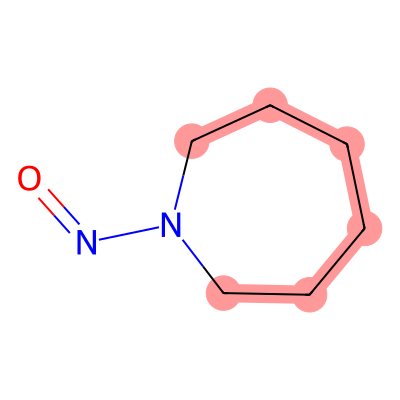

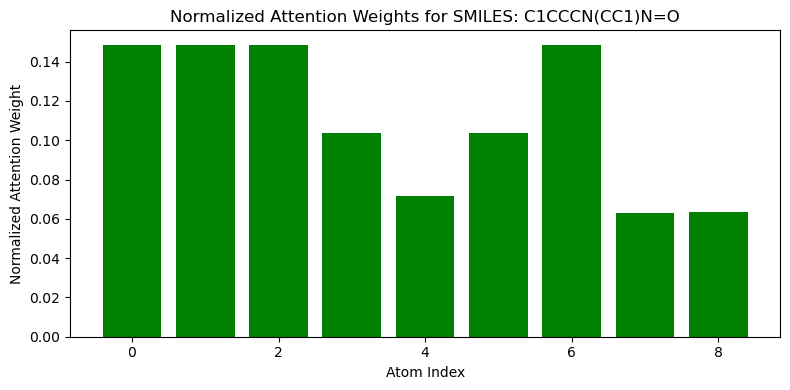

Top 2: SMILES=CC1CN1P(=O)(N2CC2C)N3CC3C, Prob=0.5970
SMILES: CC1CN1P(=O)(N2CC2C)N3CC3C
  Atom 0 (C): Attention Score = 0.1046
  Atom 1 (C): Attention Score = 0.0819
  Atom 2 (C): Attention Score = 0.0798
  Atom 3 (N): Attention Score = 0.0413
  Atom 4 (P): Attention Score = 0.0386
  Atom 5 (O): Attention Score = 0.0386
  Atom 6 (N): Attention Score = 0.0413
  Atom 7 (C): Attention Score = 0.0798
  Atom 8 (C): Attention Score = 0.0819
  Atom 9 (C): Attention Score = 0.1046
  Atom 10 (N): Attention Score = 0.0413
  Atom 11 (C): Attention Score = 0.0798
  Atom 12 (C): Attention Score = 0.0819
  Atom 13 (C): Attention Score = 0.1046


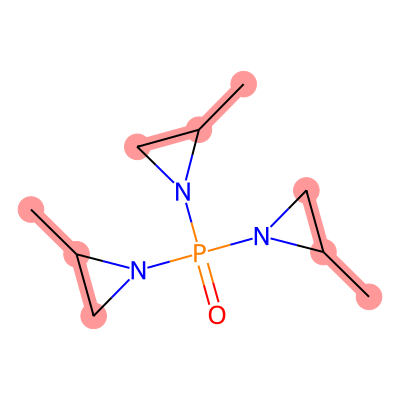

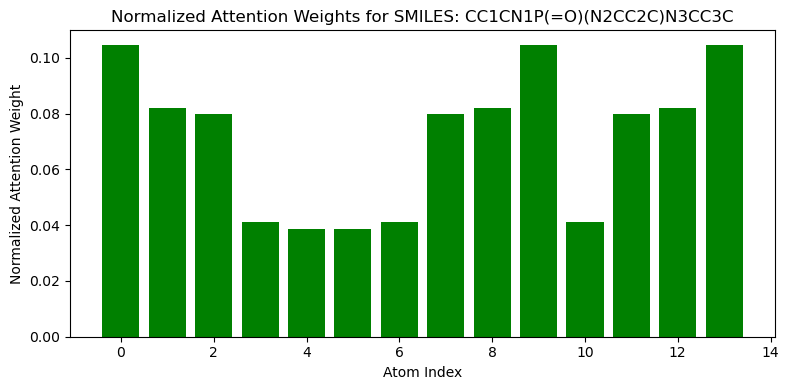

Top 3: SMILES=C1=CC(=CC=C1N)OC2=CC=C(C=C2)Cl, Prob=0.5490
SMILES: C1=CC(=CC=C1N)OC2=CC=C(C=C2)Cl
  Atom 0 (C): Attention Score = 0.0870
  Atom 1 (C): Attention Score = 0.0870
  Atom 2 (C): Attention Score = 0.0540
  Atom 3 (C): Attention Score = 0.0870
  Atom 4 (C): Attention Score = 0.0870
  Atom 5 (C): Attention Score = 0.0633
  Atom 6 (N): Attention Score = 0.0322
  Atom 7 (O): Attention Score = 0.0330
  Atom 8 (C): Attention Score = 0.0540
  Atom 9 (C): Attention Score = 0.0870
  Atom 10 (C): Attention Score = 0.0870
  Atom 11 (C): Attention Score = 0.0356
  Atom 12 (C): Attention Score = 0.0870
  Atom 13 (C): Attention Score = 0.0870
  Atom 14 (Cl): Attention Score = 0.0322


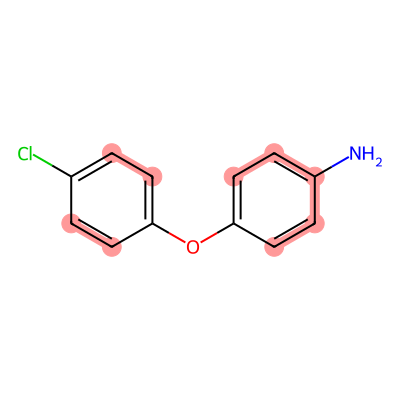

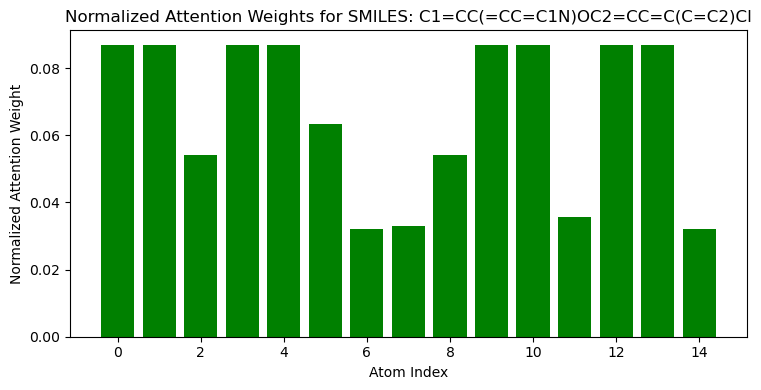

Top 4: SMILES=CCCCN(C(=O)N)N=O, Prob=0.5411
SMILES: CCCCN(C(=O)N)N=O
  Atom 0 (C): Attention Score = 0.1676
  Atom 1 (C): Attention Score = 0.1549
  Atom 2 (C): Attention Score = 0.1205
  Atom 3 (C): Attention Score = 0.0838
  Atom 4 (N): Attention Score = 0.0680
  Atom 5 (C): Attention Score = 0.0735
  Atom 6 (O): Attention Score = 0.1226
  Atom 7 (N): Attention Score = 0.0801
  Atom 8 (N): Attention Score = 0.0629
  Atom 9 (O): Attention Score = 0.0660


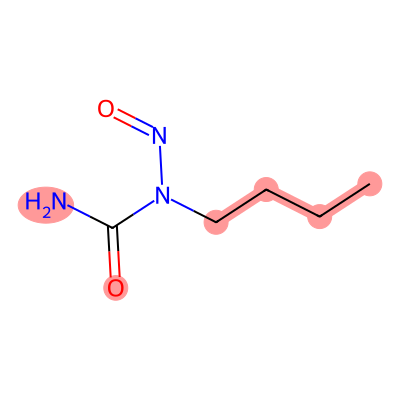

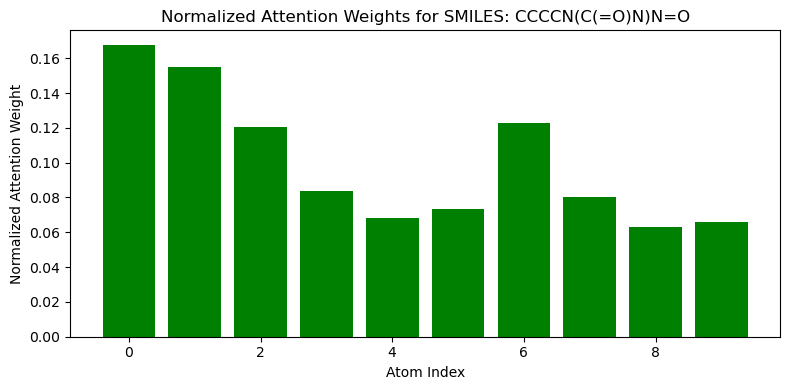

Top 5: SMILES=C(C(CBr)Br)O, Prob=0.5145
SMILES: C(C(CBr)Br)O
  Atom 0 (C): Attention Score = 0.2616
  Atom 1 (C): Attention Score = 0.1185
  Atom 2 (C): Attention Score = 0.1470
  Atom 3 (Br): Attention Score = 0.0980
  Atom 4 (Br): Attention Score = 0.1164
  Atom 5 (O): Attention Score = 0.2584


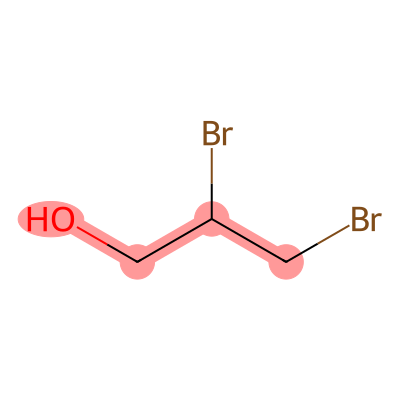

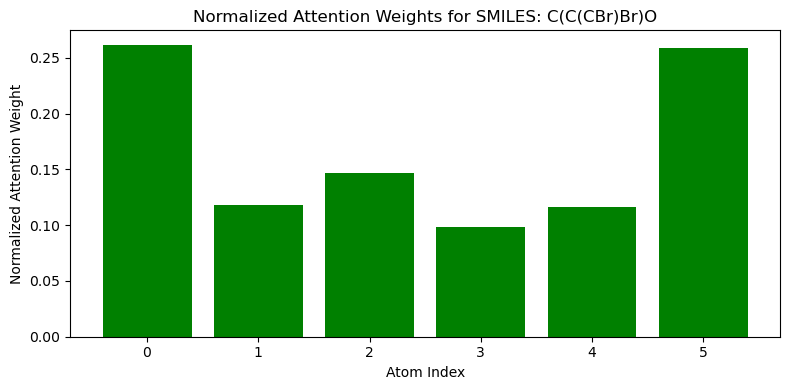

Top 6: SMILES=CC1(C(=C)[C@@]2(C([C@]1(C(C2(Cl)Cl)(Cl)Cl)Cl)Cl)Cl)C, Prob=0.4932
SMILES: CC1(C(=C)[C@@]2(C([C@]1(C(C2(Cl)Cl)(Cl)Cl)Cl)Cl)Cl)C
  Atom 0 (C): Attention Score = 0.0998
  Atom 1 (C): Attention Score = 0.0979
  Atom 2 (C): Attention Score = 0.0573
  Atom 3 (C): Attention Score = 0.0989
  Atom 4 (C): Attention Score = 0.0559
  Atom 5 (C): Attention Score = 0.0432
  Atom 6 (C): Attention Score = 0.0457
  Atom 7 (C): Attention Score = 0.0384
  Atom 8 (C): Attention Score = 0.0388
  Atom 9 (Cl): Attention Score = 0.0380
  Atom 10 (Cl): Attention Score = 0.0380
  Atom 11 (Cl): Attention Score = 0.0380
  Atom 12 (Cl): Attention Score = 0.0380
  Atom 13 (Cl): Attention Score = 0.0376
  Atom 14 (Cl): Attention Score = 0.0970
  Atom 15 (Cl): Attention Score = 0.0379
  Atom 16 (C): Attention Score = 0.0998


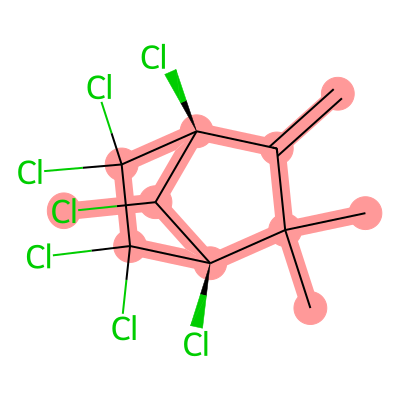

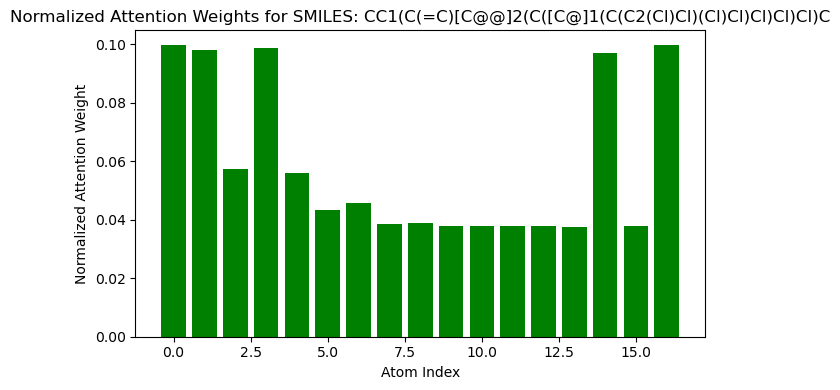


Task lun — Fold 3 (2nd highest AUROC)
Top 1: SMILES=CC1CN1P(=O)(N2CC2C)N3CC3C, Prob=0.7428
SMILES: CC1CN1P(=O)(N2CC2C)N3CC3C
  Atom 0 (C): Attention Score = 0.1046
  Atom 1 (C): Attention Score = 0.0819
  Atom 2 (C): Attention Score = 0.0798
  Atom 3 (N): Attention Score = 0.0413
  Atom 4 (P): Attention Score = 0.0386
  Atom 5 (O): Attention Score = 0.0386
  Atom 6 (N): Attention Score = 0.0413
  Atom 7 (C): Attention Score = 0.0798
  Atom 8 (C): Attention Score = 0.0819
  Atom 9 (C): Attention Score = 0.1046
  Atom 10 (N): Attention Score = 0.0413
  Atom 11 (C): Attention Score = 0.0798
  Atom 12 (C): Attention Score = 0.0819
  Atom 13 (C): Attention Score = 0.1046


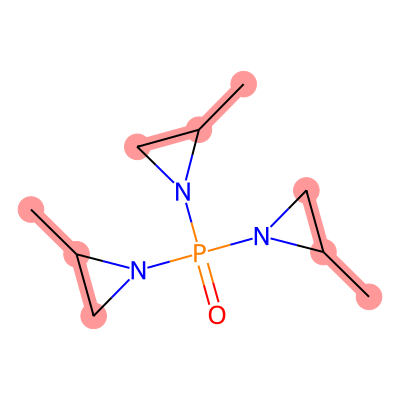

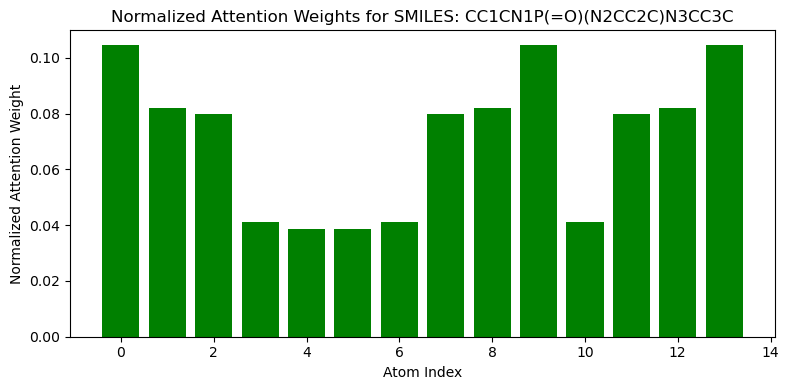

Top 2: SMILES=C1CCCN(CC1)N=O, Prob=0.7221
SMILES: C1CCCN(CC1)N=O
  Atom 0 (C): Attention Score = 0.1485
  Atom 1 (C): Attention Score = 0.1485
  Atom 2 (C): Attention Score = 0.1485
  Atom 3 (C): Attention Score = 0.1038
  Atom 4 (N): Attention Score = 0.0716
  Atom 5 (C): Attention Score = 0.1038
  Atom 6 (C): Attention Score = 0.1485
  Atom 7 (N): Attention Score = 0.0631
  Atom 8 (O): Attention Score = 0.0637


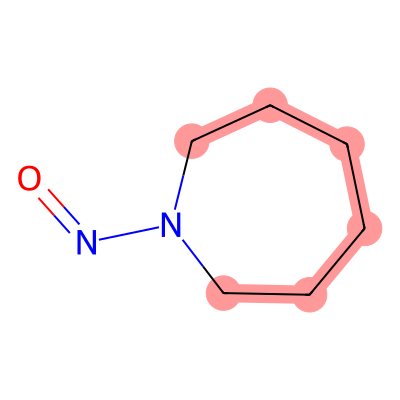

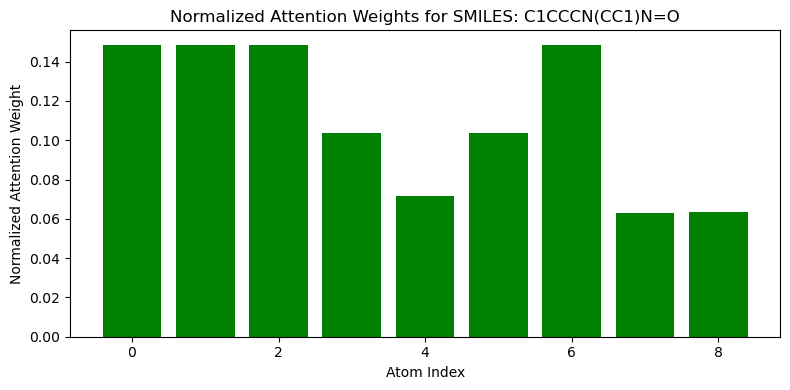

Top 3: SMILES=C(C(CBr)Br)O, Prob=0.6279
SMILES: C(C(CBr)Br)O
  Atom 0 (C): Attention Score = 0.2616
  Atom 1 (C): Attention Score = 0.1185
  Atom 2 (C): Attention Score = 0.1470
  Atom 3 (Br): Attention Score = 0.0980
  Atom 4 (Br): Attention Score = 0.1164
  Atom 5 (O): Attention Score = 0.2584


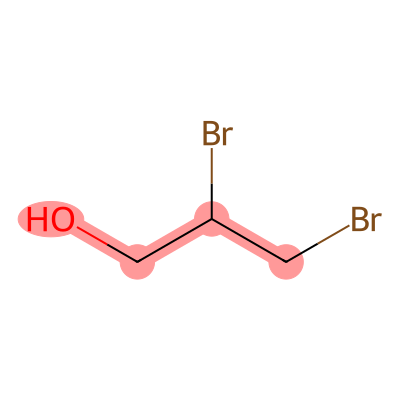

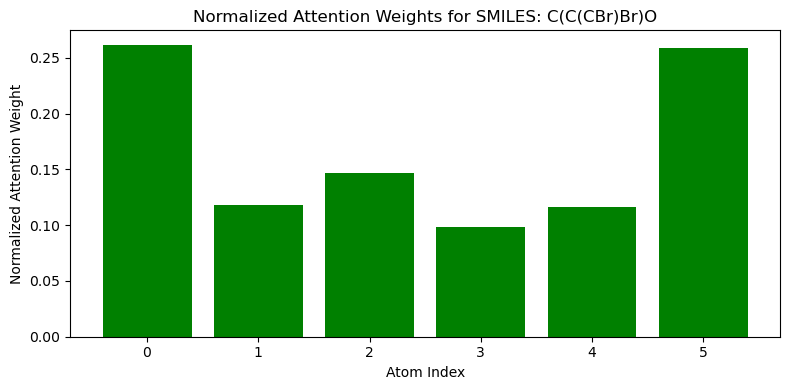

Top 4: SMILES=C1=CC(=CC=C1N)OC2=CC=C(C=C2)Cl, Prob=0.6005
SMILES: C1=CC(=CC=C1N)OC2=CC=C(C=C2)Cl
  Atom 0 (C): Attention Score = 0.0870
  Atom 1 (C): Attention Score = 0.0870
  Atom 2 (C): Attention Score = 0.0540
  Atom 3 (C): Attention Score = 0.0870
  Atom 4 (C): Attention Score = 0.0870
  Atom 5 (C): Attention Score = 0.0633
  Atom 6 (N): Attention Score = 0.0322
  Atom 7 (O): Attention Score = 0.0330
  Atom 8 (C): Attention Score = 0.0540
  Atom 9 (C): Attention Score = 0.0870
  Atom 10 (C): Attention Score = 0.0870
  Atom 11 (C): Attention Score = 0.0356
  Atom 12 (C): Attention Score = 0.0870
  Atom 13 (C): Attention Score = 0.0870
  Atom 14 (Cl): Attention Score = 0.0322


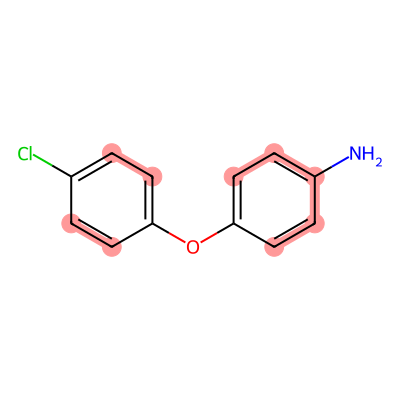

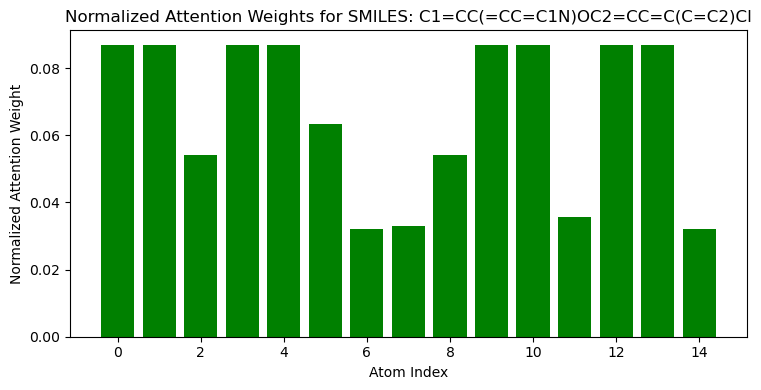

Top 5: SMILES=CCCCN(C(=O)N)N=O, Prob=0.5551
SMILES: CCCCN(C(=O)N)N=O
  Atom 0 (C): Attention Score = 0.1676
  Atom 1 (C): Attention Score = 0.1549
  Atom 2 (C): Attention Score = 0.1205
  Atom 3 (C): Attention Score = 0.0838
  Atom 4 (N): Attention Score = 0.0680
  Atom 5 (C): Attention Score = 0.0735
  Atom 6 (O): Attention Score = 0.1226
  Atom 7 (N): Attention Score = 0.0801
  Atom 8 (N): Attention Score = 0.0629
  Atom 9 (O): Attention Score = 0.0660


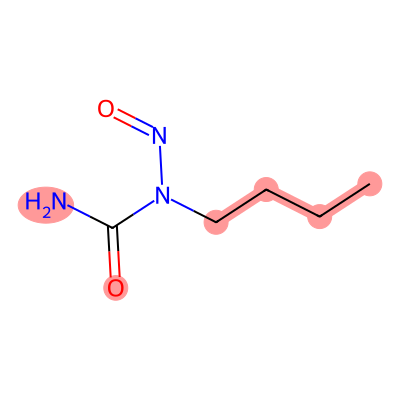

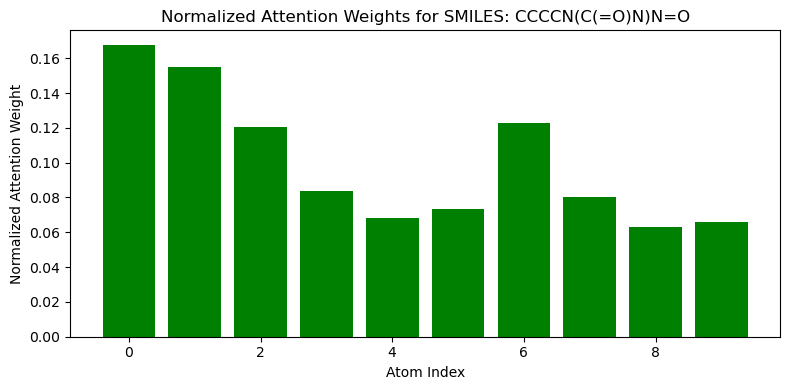

Top 6: SMILES=CC1(C(=C)[C@@]2(C([C@]1(C(C2(Cl)Cl)(Cl)Cl)Cl)Cl)Cl)C, Prob=0.5162
SMILES: CC1(C(=C)[C@@]2(C([C@]1(C(C2(Cl)Cl)(Cl)Cl)Cl)Cl)Cl)C
  Atom 0 (C): Attention Score = 0.0998
  Atom 1 (C): Attention Score = 0.0979
  Atom 2 (C): Attention Score = 0.0573
  Atom 3 (C): Attention Score = 0.0989
  Atom 4 (C): Attention Score = 0.0559
  Atom 5 (C): Attention Score = 0.0432
  Atom 6 (C): Attention Score = 0.0457
  Atom 7 (C): Attention Score = 0.0384
  Atom 8 (C): Attention Score = 0.0388
  Atom 9 (Cl): Attention Score = 0.0380
  Atom 10 (Cl): Attention Score = 0.0380
  Atom 11 (Cl): Attention Score = 0.0380
  Atom 12 (Cl): Attention Score = 0.0380
  Atom 13 (Cl): Attention Score = 0.0376
  Atom 14 (Cl): Attention Score = 0.0970
  Atom 15 (Cl): Attention Score = 0.0379
  Atom 16 (C): Attention Score = 0.0998


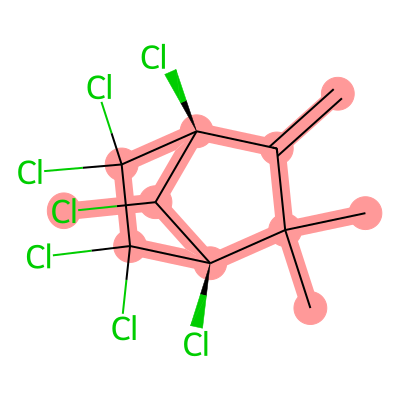

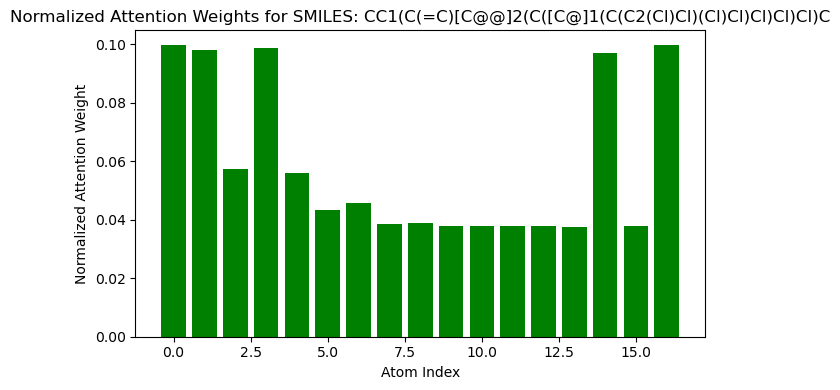

Top 7: SMILES=C1=CC=C2C(=C1)C3=C4[C@@]25[C@@H](O5)C(C(C4=CC=C3)O)O, Prob=0.4709
SMILES: C1=CC=C2C(=C1)C3=C4[C@@]25[C@@H](O5)C(C(C4=CC=C3)O)O
  Atom 0 (C): Attention Score = 0.0716
  Atom 1 (C): Attention Score = 0.0716
  Atom 2 (C): Attention Score = 0.0708
  Atom 3 (C): Attention Score = 0.0311
  Atom 4 (C): Attention Score = 0.0503
  Atom 5 (C): Attention Score = 0.0708
  Atom 6 (C): Attention Score = 0.0503
  Atom 7 (C): Attention Score = 0.0278
  Atom 8 (C): Attention Score = 0.0273
  Atom 9 (C): Attention Score = 0.0271
  Atom 10 (O): Attention Score = 0.0266
  Atom 11 (C): Attention Score = 0.0377
  Atom 12 (C): Attention Score = 0.0442
  Atom 13 (C): Attention Score = 0.0602
  Atom 14 (C): Attention Score = 0.0708
  Atom 15 (C): Attention Score = 0.0716
  Atom 16 (C): Attention Score = 0.0708
  Atom 17 (O): Attention Score = 0.0596
  Atom 18 (O): Attention Score = 0.0596


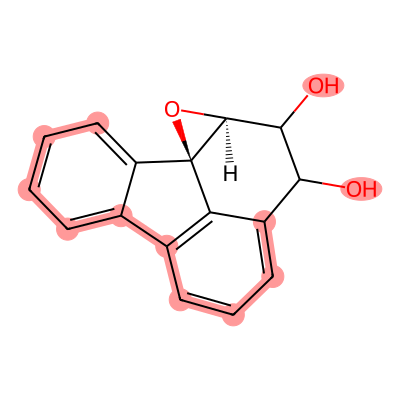

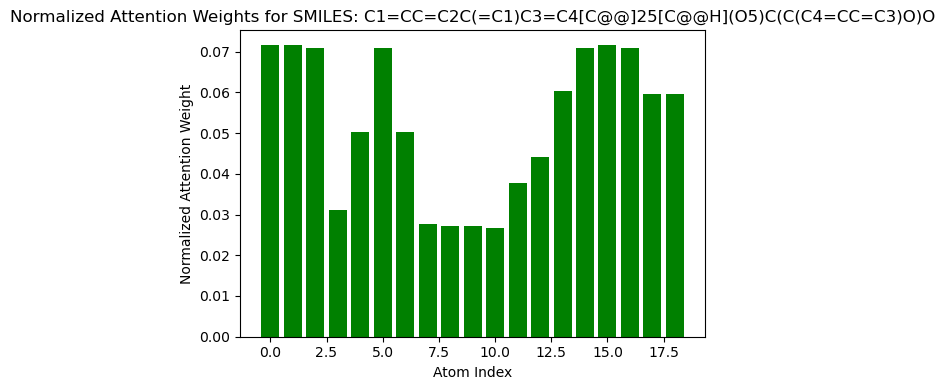


Task sto — Fold 3 (2nd highest AUROC)
Top 1: SMILES=CC1CN1P(=O)(N2CC2C)N3CC3C, Prob=0.7477
SMILES: CC1CN1P(=O)(N2CC2C)N3CC3C
  Atom 0 (C): Attention Score = 0.1046
  Atom 1 (C): Attention Score = 0.0819
  Atom 2 (C): Attention Score = 0.0798
  Atom 3 (N): Attention Score = 0.0413
  Atom 4 (P): Attention Score = 0.0386
  Atom 5 (O): Attention Score = 0.0386
  Atom 6 (N): Attention Score = 0.0413
  Atom 7 (C): Attention Score = 0.0798
  Atom 8 (C): Attention Score = 0.0819
  Atom 9 (C): Attention Score = 0.1046
  Atom 10 (N): Attention Score = 0.0413
  Atom 11 (C): Attention Score = 0.0798
  Atom 12 (C): Attention Score = 0.0819
  Atom 13 (C): Attention Score = 0.1046


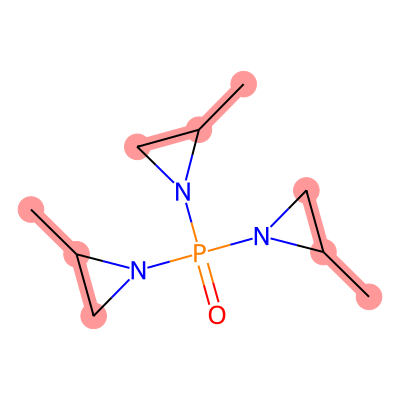

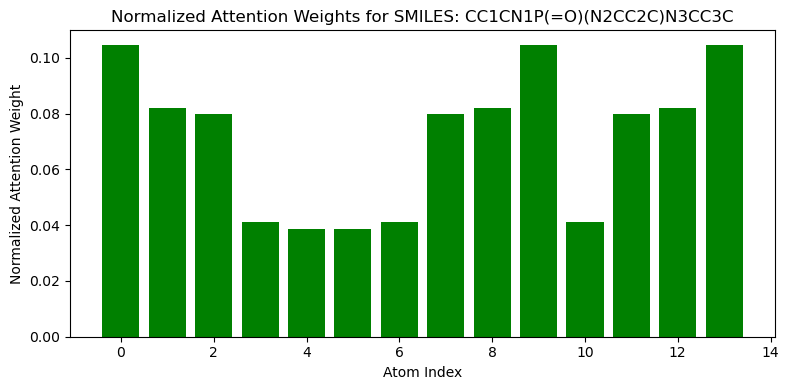

Top 2: SMILES=C1CCCN(CC1)N=O, Prob=0.7369
SMILES: C1CCCN(CC1)N=O
  Atom 0 (C): Attention Score = 0.1485
  Atom 1 (C): Attention Score = 0.1485
  Atom 2 (C): Attention Score = 0.1485
  Atom 3 (C): Attention Score = 0.1038
  Atom 4 (N): Attention Score = 0.0716
  Atom 5 (C): Attention Score = 0.1038
  Atom 6 (C): Attention Score = 0.1485
  Atom 7 (N): Attention Score = 0.0631
  Atom 8 (O): Attention Score = 0.0637


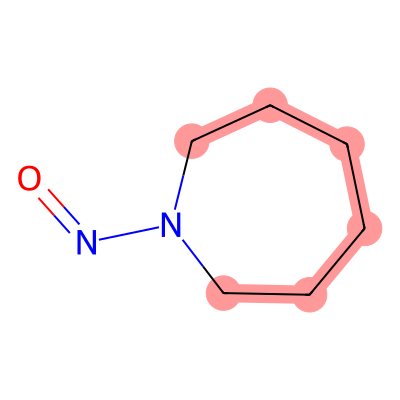

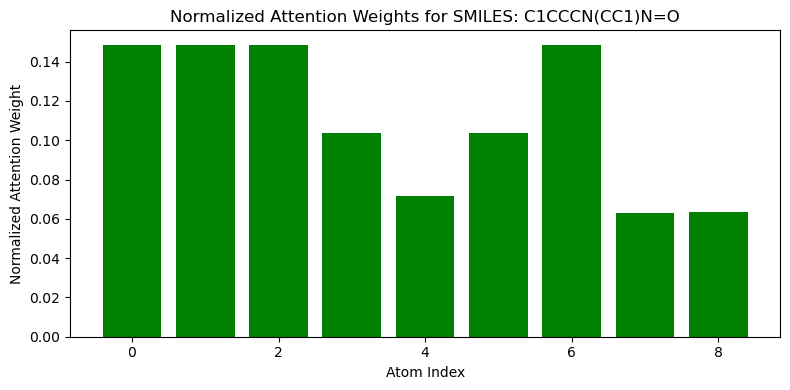

Top 3: SMILES=CCCCN(C(=O)N)N=O, Prob=0.6433
SMILES: CCCCN(C(=O)N)N=O
  Atom 0 (C): Attention Score = 0.1676
  Atom 1 (C): Attention Score = 0.1549
  Atom 2 (C): Attention Score = 0.1205
  Atom 3 (C): Attention Score = 0.0838
  Atom 4 (N): Attention Score = 0.0680
  Atom 5 (C): Attention Score = 0.0735
  Atom 6 (O): Attention Score = 0.1226
  Atom 7 (N): Attention Score = 0.0801
  Atom 8 (N): Attention Score = 0.0629
  Atom 9 (O): Attention Score = 0.0660


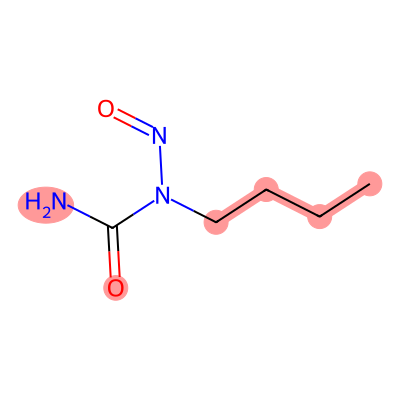

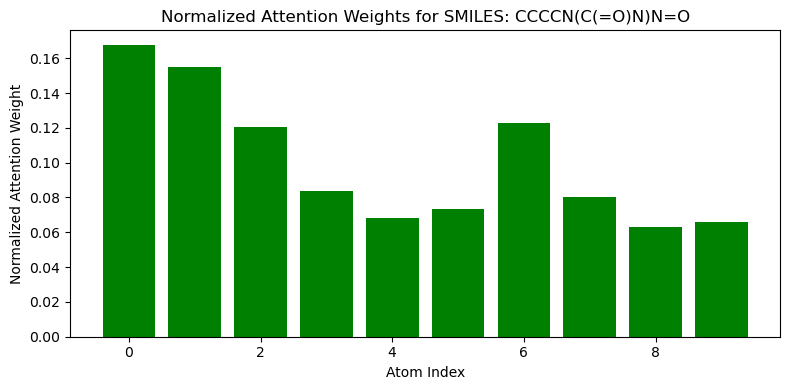

Top 4: SMILES=CN(C=O)N=O, Prob=0.6042
SMILES: CN(C=O)N=O
  Atom 0 (C): Attention Score = 0.2047
  Atom 1 (N): Attention Score = 0.1835
  Atom 2 (C): Attention Score = 0.2091
  Atom 3 (O): Attention Score = 0.2278
  Atom 4 (N): Attention Score = 0.0855
  Atom 5 (O): Attention Score = 0.0893


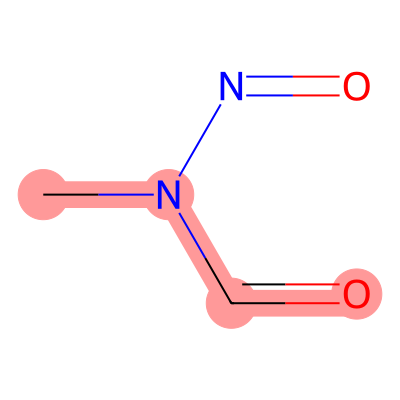

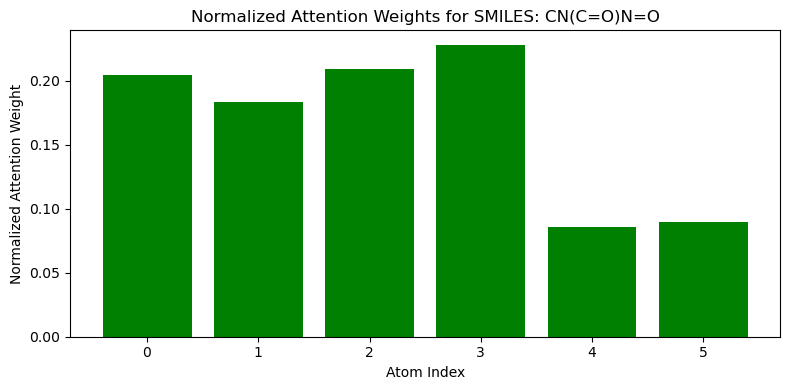

Top 5: SMILES=C(C(CBr)Br)O, Prob=0.5978
SMILES: C(C(CBr)Br)O
  Atom 0 (C): Attention Score = 0.2616
  Atom 1 (C): Attention Score = 0.1185
  Atom 2 (C): Attention Score = 0.1470
  Atom 3 (Br): Attention Score = 0.0980
  Atom 4 (Br): Attention Score = 0.1164
  Atom 5 (O): Attention Score = 0.2584


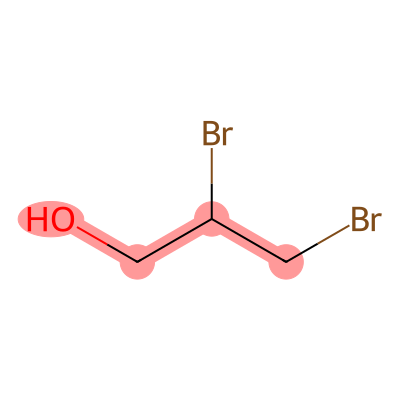

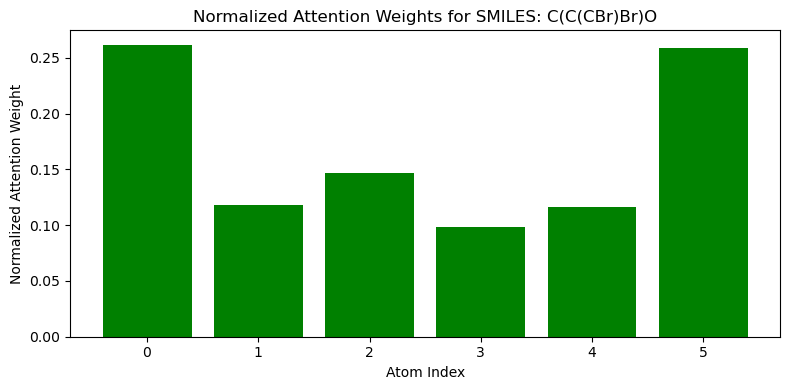

Top 6: SMILES=C1=CC(=CC=C1N)OC2=CC=C(C=C2)Cl, Prob=0.5685
SMILES: C1=CC(=CC=C1N)OC2=CC=C(C=C2)Cl
  Atom 0 (C): Attention Score = 0.0870
  Atom 1 (C): Attention Score = 0.0870
  Atom 2 (C): Attention Score = 0.0540
  Atom 3 (C): Attention Score = 0.0870
  Atom 4 (C): Attention Score = 0.0870
  Atom 5 (C): Attention Score = 0.0633
  Atom 6 (N): Attention Score = 0.0322
  Atom 7 (O): Attention Score = 0.0330
  Atom 8 (C): Attention Score = 0.0540
  Atom 9 (C): Attention Score = 0.0870
  Atom 10 (C): Attention Score = 0.0870
  Atom 11 (C): Attention Score = 0.0356
  Atom 12 (C): Attention Score = 0.0870
  Atom 13 (C): Attention Score = 0.0870
  Atom 14 (Cl): Attention Score = 0.0322


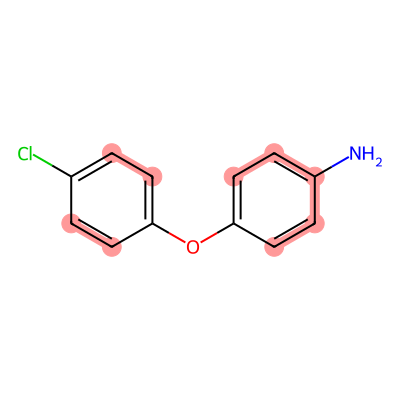

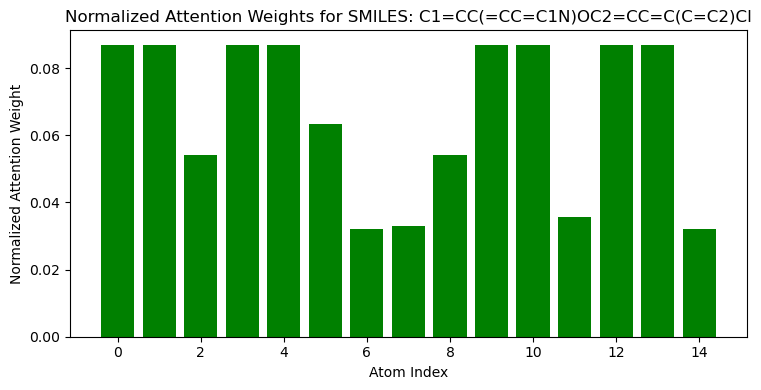

Top 7: SMILES=CC1(C(=C)[C@@]2(C([C@]1(C(C2(Cl)Cl)(Cl)Cl)Cl)Cl)Cl)C, Prob=0.5413
SMILES: CC1(C(=C)[C@@]2(C([C@]1(C(C2(Cl)Cl)(Cl)Cl)Cl)Cl)Cl)C
  Atom 0 (C): Attention Score = 0.0998
  Atom 1 (C): Attention Score = 0.0979
  Atom 2 (C): Attention Score = 0.0573
  Atom 3 (C): Attention Score = 0.0989
  Atom 4 (C): Attention Score = 0.0559
  Atom 5 (C): Attention Score = 0.0432
  Atom 6 (C): Attention Score = 0.0457
  Atom 7 (C): Attention Score = 0.0384
  Atom 8 (C): Attention Score = 0.0388
  Atom 9 (Cl): Attention Score = 0.0380
  Atom 10 (Cl): Attention Score = 0.0380
  Atom 11 (Cl): Attention Score = 0.0380
  Atom 12 (Cl): Attention Score = 0.0380
  Atom 13 (Cl): Attention Score = 0.0376
  Atom 14 (Cl): Attention Score = 0.0970
  Atom 15 (Cl): Attention Score = 0.0379
  Atom 16 (C): Attention Score = 0.0998


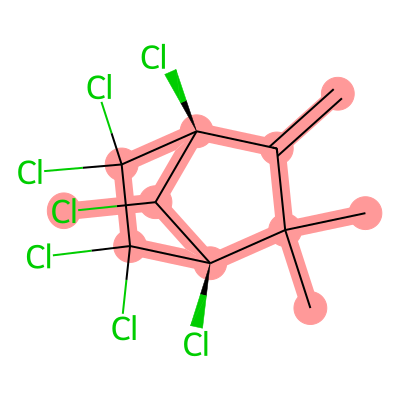

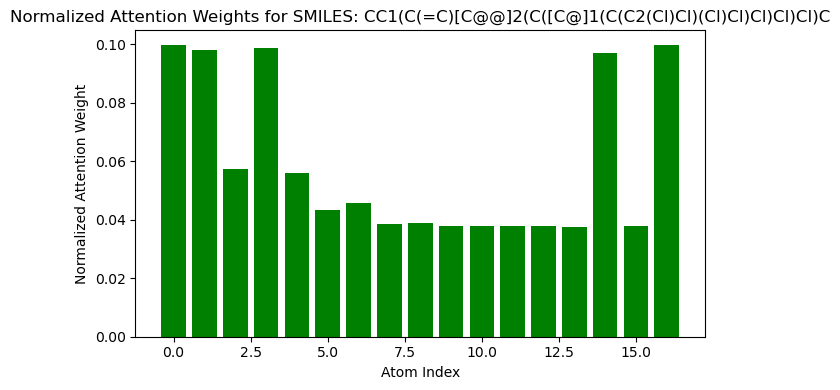


Task mgl — Fold 3 (2nd highest AUROC)
Top 1: SMILES=CC1(C(=C)[C@@]2(C([C@]1(C(C2(Cl)Cl)(Cl)Cl)Cl)Cl)Cl)C, Prob=0.5629
SMILES: CC1(C(=C)[C@@]2(C([C@]1(C(C2(Cl)Cl)(Cl)Cl)Cl)Cl)Cl)C
  Atom 0 (C): Attention Score = 0.0998
  Atom 1 (C): Attention Score = 0.0979
  Atom 2 (C): Attention Score = 0.0573
  Atom 3 (C): Attention Score = 0.0989
  Atom 4 (C): Attention Score = 0.0559
  Atom 5 (C): Attention Score = 0.0432
  Atom 6 (C): Attention Score = 0.0457
  Atom 7 (C): Attention Score = 0.0384
  Atom 8 (C): Attention Score = 0.0388
  Atom 9 (Cl): Attention Score = 0.0380
  Atom 10 (Cl): Attention Score = 0.0380
  Atom 11 (Cl): Attention Score = 0.0380
  Atom 12 (Cl): Attention Score = 0.0380
  Atom 13 (Cl): Attention Score = 0.0376
  Atom 14 (Cl): Attention Score = 0.0970
  Atom 15 (Cl): Attention Score = 0.0379
  Atom 16 (C): Attention Score = 0.0998


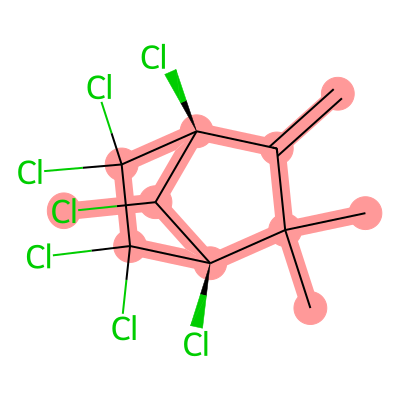

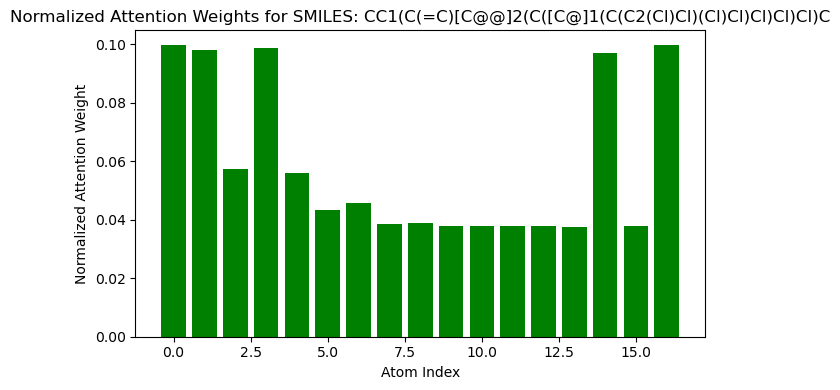

Top 2: SMILES=CC(=O)N(C1=CC=CC2=C1CC3=CC=CC=C32)C(=O)C, Prob=0.5426
SMILES: CC(=O)N(C1=CC=CC2=C1CC3=CC=CC=C32)C(=O)C
  Atom 0 (C): Attention Score = 0.0293
  Atom 1 (C): Attention Score = 0.0284
  Atom 2 (O): Attention Score = 0.0290
  Atom 3 (N): Attention Score = 0.0280
  Atom 4 (C): Attention Score = 0.0298
  Atom 5 (C): Attention Score = 0.0748
  Atom 6 (C): Attention Score = 0.0752
  Atom 7 (C): Attention Score = 0.0748
  Atom 8 (C): Attention Score = 0.0692
  Atom 9 (C): Attention Score = 0.0346
  Atom 10 (C): Attention Score = 0.0298
  Atom 11 (C): Attention Score = 0.0409
  Atom 12 (C): Attention Score = 0.0748
  Atom 13 (C): Attention Score = 0.0752
  Atom 14 (C): Attention Score = 0.0752
  Atom 15 (C): Attention Score = 0.0748
  Atom 16 (C): Attention Score = 0.0692
  Atom 17 (C): Attention Score = 0.0284
  Atom 18 (O): Attention Score = 0.0290
  Atom 19 (C): Attention Score = 0.0293


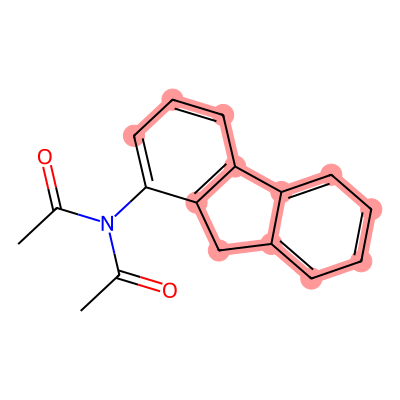

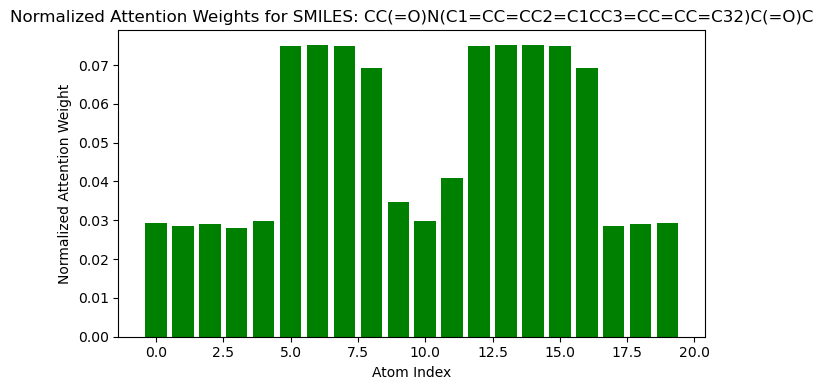

Top 3: SMILES=C1=CC(=CC=C1N)OC2=CC=C(C=C2)Cl, Prob=0.5262
SMILES: C1=CC(=CC=C1N)OC2=CC=C(C=C2)Cl
  Atom 0 (C): Attention Score = 0.0870
  Atom 1 (C): Attention Score = 0.0870
  Atom 2 (C): Attention Score = 0.0540
  Atom 3 (C): Attention Score = 0.0870
  Atom 4 (C): Attention Score = 0.0870
  Atom 5 (C): Attention Score = 0.0633
  Atom 6 (N): Attention Score = 0.0322
  Atom 7 (O): Attention Score = 0.0330
  Atom 8 (C): Attention Score = 0.0540
  Atom 9 (C): Attention Score = 0.0870
  Atom 10 (C): Attention Score = 0.0870
  Atom 11 (C): Attention Score = 0.0356
  Atom 12 (C): Attention Score = 0.0870
  Atom 13 (C): Attention Score = 0.0870
  Atom 14 (Cl): Attention Score = 0.0322


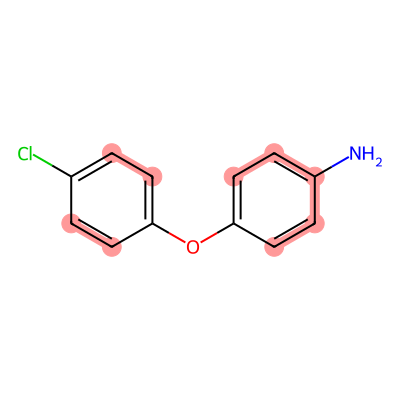

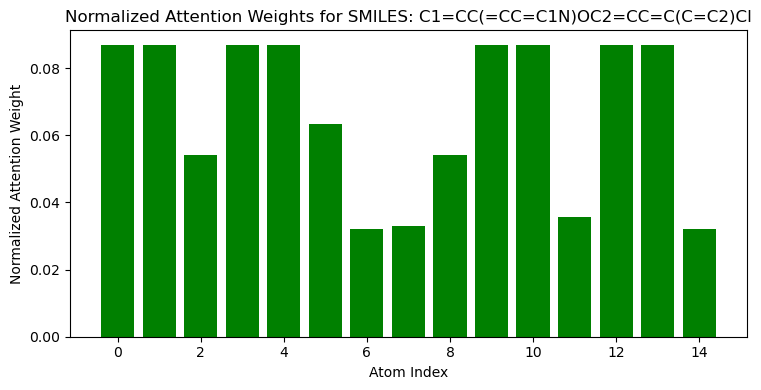

Top 4: SMILES=C1=CC=C2C(=C1)C3=C4[C@@]25[C@@H](O5)C(C(C4=CC=C3)O)O, Prob=0.5241
SMILES: C1=CC=C2C(=C1)C3=C4[C@@]25[C@@H](O5)C(C(C4=CC=C3)O)O
  Atom 0 (C): Attention Score = 0.0716
  Atom 1 (C): Attention Score = 0.0716
  Atom 2 (C): Attention Score = 0.0708
  Atom 3 (C): Attention Score = 0.0311
  Atom 4 (C): Attention Score = 0.0503
  Atom 5 (C): Attention Score = 0.0708
  Atom 6 (C): Attention Score = 0.0503
  Atom 7 (C): Attention Score = 0.0278
  Atom 8 (C): Attention Score = 0.0273
  Atom 9 (C): Attention Score = 0.0271
  Atom 10 (O): Attention Score = 0.0266
  Atom 11 (C): Attention Score = 0.0377
  Atom 12 (C): Attention Score = 0.0442
  Atom 13 (C): Attention Score = 0.0602
  Atom 14 (C): Attention Score = 0.0708
  Atom 15 (C): Attention Score = 0.0716
  Atom 16 (C): Attention Score = 0.0708
  Atom 17 (O): Attention Score = 0.0596
  Atom 18 (O): Attention Score = 0.0596


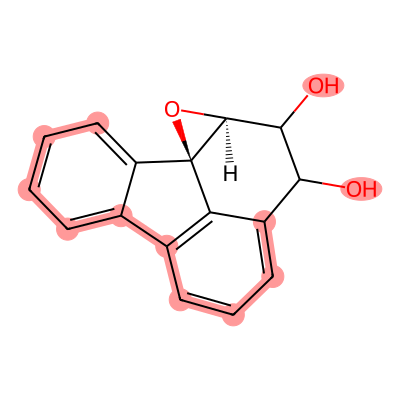

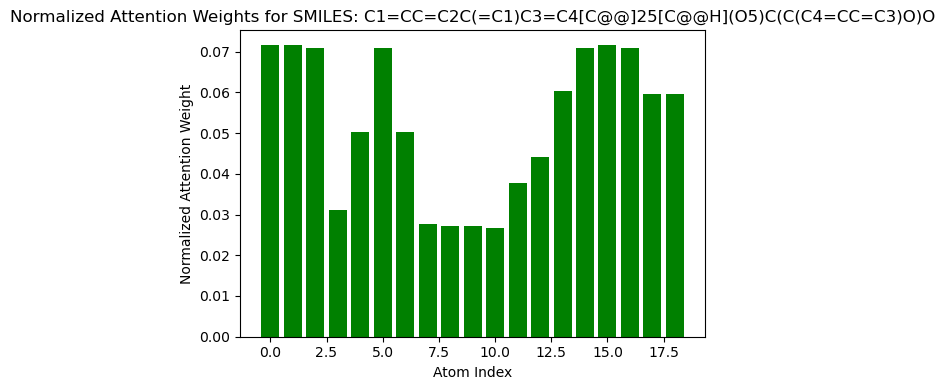

Top 5: SMILES=C1=CC=C2C=C3C=C(C=CC3=CC2=C1)N, Prob=0.5096
SMILES: C1=CC=C2C=C3C=C(C=CC3=CC2=C1)N
  Atom 0 (C): Attention Score = 0.0810
  Atom 1 (C): Attention Score = 0.0810
  Atom 2 (C): Attention Score = 0.0793
  Atom 3 (C): Attention Score = 0.0697
  Atom 4 (C): Attention Score = 0.0575
  Atom 5 (C): Attention Score = 0.0697
  Atom 6 (C): Attention Score = 0.0575
  Atom 7 (C): Attention Score = 0.0395
  Atom 8 (C): Attention Score = 0.0793
  Atom 9 (C): Attention Score = 0.0793
  Atom 10 (C): Attention Score = 0.0697
  Atom 11 (C): Attention Score = 0.0575
  Atom 12 (C): Attention Score = 0.0697
  Atom 13 (C): Attention Score = 0.0793
  Atom 14 (N): Attention Score = 0.0298


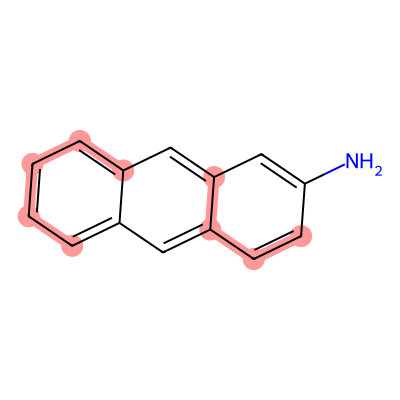

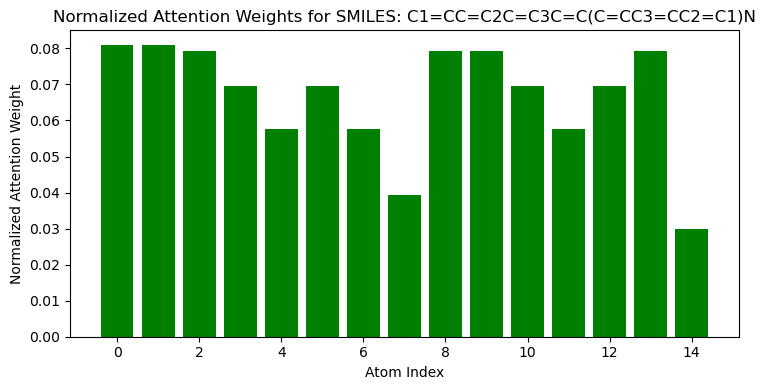

Top 6: SMILES=CC1CN1P(=O)(N2CC2C)N3CC3C, Prob=0.4845
SMILES: CC1CN1P(=O)(N2CC2C)N3CC3C
  Atom 0 (C): Attention Score = 0.1046
  Atom 1 (C): Attention Score = 0.0819
  Atom 2 (C): Attention Score = 0.0798
  Atom 3 (N): Attention Score = 0.0413
  Atom 4 (P): Attention Score = 0.0386
  Atom 5 (O): Attention Score = 0.0386
  Atom 6 (N): Attention Score = 0.0413
  Atom 7 (C): Attention Score = 0.0798
  Atom 8 (C): Attention Score = 0.0819
  Atom 9 (C): Attention Score = 0.1046
  Atom 10 (N): Attention Score = 0.0413
  Atom 11 (C): Attention Score = 0.0798
  Atom 12 (C): Attention Score = 0.0819
  Atom 13 (C): Attention Score = 0.1046


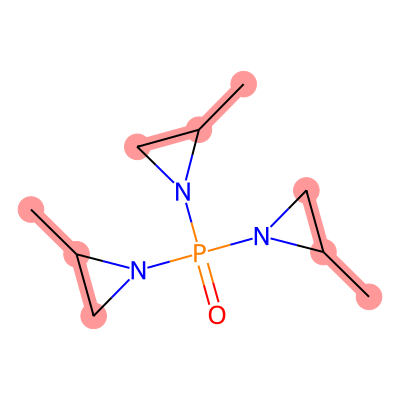

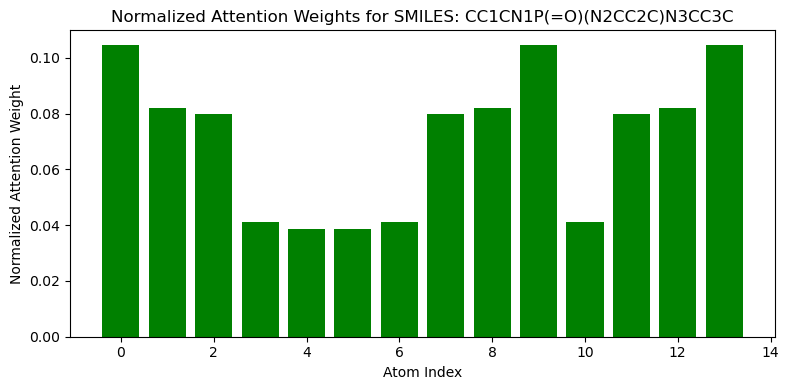

Top 7: SMILES=CCCCN(C(=O)N)N=O, Prob=0.4682
SMILES: CCCCN(C(=O)N)N=O
  Atom 0 (C): Attention Score = 0.1676
  Atom 1 (C): Attention Score = 0.1549
  Atom 2 (C): Attention Score = 0.1205
  Atom 3 (C): Attention Score = 0.0838
  Atom 4 (N): Attention Score = 0.0680
  Atom 5 (C): Attention Score = 0.0735
  Atom 6 (O): Attention Score = 0.1226
  Atom 7 (N): Attention Score = 0.0801
  Atom 8 (N): Attention Score = 0.0629
  Atom 9 (O): Attention Score = 0.0660


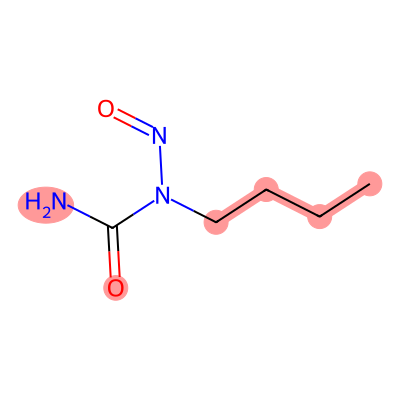

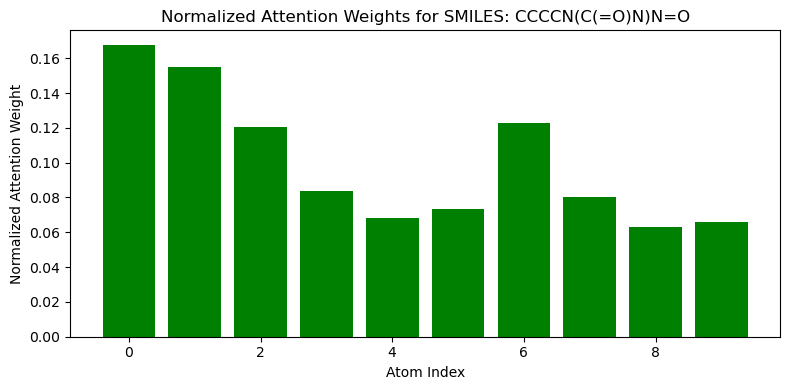

In [20]:
class MultiTaskGAT(nn.Module):
    def __init__(self, num_features, n_heads1, output_dim_idx, dropout, num_tasks=4):
        super(MultiTaskGAT, self).__init__()

        self.conv2 = GATConv(num_features, num_features, heads=n_heads1, dropout=dropout)
        self.relu = nn.ReLU()
        self.graph_norm2 = GraphNorm(num_features * n_heads1)
        
        # Generate task combinations (combinations of 3 out of n_tasks)
        self.task_combinations_2 = list(combinations(range(num_tasks), 3))
        
        # Define hidden layers for each task combination
        self.hidden_layer2 = nn.ModuleList([
            nn.Sequential(
                nn.Linear(num_features * n_heads1, output_dim_idx),
                nn.ReLU(),
                nn.Dropout(dropout),
            ) for _ in self.task_combinations_2
        ])
        
        # Defining the final output layer
        self.final_layer = nn.ModuleList([nn.Linear(output_dim_idx, 1) for _ in range(num_tasks)])
        self.sigmoid = nn.Sigmoid()

        self.attention_net = nn.Sequential(
            nn.Linear(num_features * n_heads1, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

        self.global_attention = GlobalAttention(gate_nn=self.attention_net)
        
        self.node_dropout = nn.Dropout(dropout)
        
        self.weight_matrix = nn.Parameter(torch.ones(len(self.task_combinations_2)))

    def forward(self, data, selected_tasks):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x2 = self.conv2(x, edge_index)
        x = self.graph_norm2(x2, batch)
        x = self.relu(x)
        x = self.node_dropout(x)

        # Attention Pooling
        x, attention_scores = self.global_attention(x, batch)

        # hidden_layer2: 3-task combination
        outputs = {task: [] for task in selected_tasks}
        for idx, (layer, combo) in enumerate(zip(self.hidden_layer2, self.task_combinations_2)):
            if set(combo).issubset(selected_tasks):
                output = layer(x)
                weight = self.weight_matrix[idx]
                for task in combo:
                    outputs[task].append(output * weight)
        
        # Combine the output 
        final_outputs = []
        for task in selected_tasks:
            if outputs[task]:
                combined_output = torch.sum(torch.stack(outputs[task]), dim=0) / len(outputs[task])
                final_output = self.final_layer[task](combined_output).view(-1)
                final_outputs.append(self.sigmoid(final_output))
            else:
                raise IndexError(f"Task {task} has no corresponding output in outputs dictionary.")

        return x, tuple(final_outputs), attention_scores

def visualize_attention_with_highlights(smiles, node_attention, top_percent=0.3):
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Invalid SMILES string: {smiles}")
        return
    num_atoms = mol.GetNumAtoms()
    highlight_atom_indices = []

    if isinstance(node_attention, torch.Tensor):
        node_attention = node_attention.cpu().numpy().tolist()
    elif isinstance(node_attention, np.ndarray):
        node_attention = node_attention.tolist()
    elif isinstance(node_attention, list):
        pass  
    else:
        print(f"Unsupported node_attention type: {type(node_attention)}")
        return

    if len(node_attention) != num_atoms:
        print(f"Warning: Attention scores count ({len(node_attention)}) does not match number of atoms ({num_atoms}).")
        min_len = min(len(node_attention), num_atoms)
        node_attention = node_attention[:min_len]
        num_atoms = min_len

    top_n = max(1, int(np.ceil(top_percent * num_atoms)))
    sorted_indices = sorted(range(num_atoms), key=lambda i: node_attention[i], reverse=True)
    highlight_atom_indices = sorted(sorted_indices[:top_n])
    
    # Node attention score output
    print(f"SMILES: {smiles}")
    for idx, (atom, attn) in enumerate(zip(mol.GetAtoms(), node_attention)):
        print(f"  Atom {idx} ({atom.GetSymbol()}): Attention Score = {attn:.4f}")

    highlight_atom_indices = sorted(set(highlight_atom_indices))
    
    if len(highlight_atom_indices) > 0:
        highlight_colors = {idx: (1.0, 0.6, 0.6) for idx in highlight_atom_indices}
    else:
        highlight_colors = {}

    # Molecular visualisation
    drawer = Draw.MolDraw2DCairo(400, 400)
    opts = drawer.drawOptions()
    opts.highlightColour = (1.0, 0.0, 0.0)
    drawer.DrawMolecule(mol, highlightAtoms=highlight_atom_indices, highlightAtomColors=highlight_colors)
    drawer.FinishDrawing()
    img_data = drawer.GetDrawingText()
    
    img = Image.open(io.BytesIO(img_data))
    display(img)
    
    # Normalised Attention Weights bar graph visualisation
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(node_attention)), node_attention, color='green')
    plt.title(f'Normalized Attention Weights for SMILES: {smiles}')
    plt.xlabel('Atom Index')
    plt.ylabel('Normalized Attention Weight')
    plt.tight_layout()
    plt.show()

# Define a function to output performance metrics
def printPerformance_multi(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = np.nan
    try:
        pr_auc = average_precision_score(y_true, y_pred)
    except ValueError:
        pr_auc = np.nan
    y_pred_labels = (y_pred >= 0.45).astype(int)
    accuracy = accuracy_score(y_true, y_pred_labels)
    print(f"  AUC: {auc:.4f}, PR AUC: {pr_auc:.4f}, Accuracy: {accuracy:.4f}")


def extract_attention_scores_per_molecule(batch, node_attention, smiles):
    
    attention_scores_per_molecule = []
    selected_smiles = []
    
    num_molecules = batch.num_graphs
    
    for i in range(num_molecules):
        node_indices = (batch.batch == i).nonzero(as_tuple=True)[0]
        molecule_attention = node_attention[node_indices].cpu().numpy().flatten().tolist()
        molecule_smiles = smiles[i]
        selected_smiles.append(molecule_smiles)
        
        mol = Chem.MolFromSmiles(molecule_smiles)
        if mol is None:
            print(f"Invalid SMILES string: {molecule_smiles}")
            attention_scores_per_molecule.append([])
            continue
        
        num_atoms = mol.GetNumAtoms()
        atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
        
        if len(molecule_attention) != num_atoms:
            print(f"Warning: Attention scores count ({len(molecule_attention)}) does not match number of atoms ({num_atoms}).")
        
        attention_scores_per_molecule.append(molecule_attention)
    
    return attention_scores_per_molecule, selected_smiles

def save_predictions_to_csv(all_fold_results, list_tissue, output_dir='prediction_results'):
    
    os.makedirs(output_dir, exist_ok=True)
    
    task_data = {task: {'fold': [], 'smiles': [], 'y_true': [], 'y_pred': []} for task in list_tissue}
    
    for fold_result in all_fold_results:
        fold = fold_result['fold']
        smiles_list = fold_result['smiles']
        task_metrics = fold_result['task_metrics']
        
        for task_idx, task_name in enumerate(list_tissue):
            task_key = f"task_{task_idx}"
            y_true = task_metrics[task_key]['y_true']
            y_pred = task_metrics[task_key]['y_pred']
            
            for i, smiles in enumerate(smiles_list):
                task_data[task_name]['fold'].append(fold)
                task_data[task_name]['smiles'].append(smiles)
                task_data[task_name]['y_true'].append(y_true[i])
                task_data[task_name]['y_pred'].append(y_pred[i])
    
    for task_name, data in task_data.items():
        df = pd.DataFrame(data)
        csv_path = os.path.join(output_dir, f'{task_name}_predictions.csv')
        df.to_csv(csv_path, index=False)
        print(f"Saved predictions for task '{task_name}' to {csv_path}")

def test_and_collect(model, criterion, test_loader, device, list_tissue):
    model.eval()
    task_losses = defaultdict(float)
    num_batches = defaultdict(int)
    task_metrics = defaultdict(lambda: {'y_true': [], 'y_pred': []})
    
    all_node_attention_scores = []
    all_smiles = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            
            x, list_task, node_attention_scores = model(batch, selected_tasks=tuple(range(len(list_tissue))))
            
            for task_idx, task in enumerate(list_tissue):
                task_key = f"task_{task_idx}"
                task_metrics[task_key]['y_true'].extend(batch.y[:, task_idx].cpu().tolist())
                task_metrics[task_key]['y_pred'].extend(list_task[task_idx].cpu().tolist())

            attention_scores_per_molecule, selected_smiles = extract_attention_scores_per_molecule(
                batch, node_attention_scores, smiles=batch.smiles)
            all_node_attention_scores.extend(attention_scores_per_molecule)
            all_smiles.extend(selected_smiles)

    task_results = {}
    
    for task_idx, task_name in enumerate(list_tissue):
        task_key = f"task_{task_idx}"
        if task_key in task_metrics:
            y_true = np.array(task_metrics[task_key]['y_true'])
            y_pred = np.array(task_metrics[task_key]['y_pred'])
            try:
                auc = roc_auc_score(y_true, y_pred)
            except ValueError:
                auc = np.nan

            try:
                pr_auc = average_precision_score(y_true, y_pred)
            except ValueError:
                pr_auc = np.nan

            y_pred_labels = (y_pred >= 0.45).astype(int)
            accuracy = accuracy_score(y_true, y_pred_labels)
            avg_loss = np.nan  
            task_results[task_key] = {
                'loss': avg_loss,
                'auc': auc,
                'pr_auc': pr_auc,
                'accuracy': accuracy
            }
        else:
            task_results[task_key] = {
                'loss': np.nan,
                'auc': np.nan,
                'pr_auc': np.nan,
                'accuracy': np.nan
            }
    return task_results, task_metrics, all_node_attention_scores, all_smiles

def main():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    K = 20
    list_tissue = ["liv", "lun", "sto", "mgl"]

    data_dir = '/data/home/dbswn0814/2025JCM/model/multi task3/data'
    models_dir = '/data/home/dbswn0814/2025JCM/model/multi task3/model'

    model = MultiTaskGAT(
        num_features=75, n_heads1=2,
        output_dim_idx=16, dropout=0.2,
        num_tasks=len(list_tissue)
    ).to(device)
    criterion = FocalLoss(alpha=0.25, gamma=4.0, reduction='mean')

    all_fold_results = []
    fold_attention_data = {}
    all_task_results = defaultdict(lambda: {'auc': [], 'pr_auc': [], 'accuracy': []})

    for fold in range(1, K+1):
        test_path = os.path.join(data_dir, f'fold_{fold}_test.pt')
        model_path = os.path.join(models_dir, f'fold_{fold}_final.pth')
        if not os.path.exists(test_path) or not os.path.exists(model_path):
            print(f"Skipping fold {fold}: data or model file missing.")
            continue

        test_dataset = torch.load(test_path)
        test_loader = TorchDataLoader(
            test_dataset, batch_size=8,
            shuffle=False, collate_fn=Batch.from_data_list
        )
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint)
        model.eval()

        # 평가
        test_results, task_metrics, attn_scores, smiles_list = test_and_collect(
            model, criterion, test_loader, device, list_tissue
        )

        all_fold_results.append({
            'fold': fold,
            'test_results': test_results,
            'task_metrics': task_metrics,
            'node_attention_scores': attn_scores,
            'smiles': smiles_list
        })
        fold_attention_data[fold] = {
            'test_results': test_results,
            'task_metrics': task_metrics,
            'node_attention_scores': attn_scores,
            'smiles': smiles_list
        }
        for key, res in test_results.items():
            all_task_results[key]['auc'].append(res['auc'])
            all_task_results[key]['pr_auc'].append(res['pr_auc'])
            all_task_results[key]['accuracy'].append(res['accuracy'])

    print("\n=== Average results across all folds ===")
    for idx, name in enumerate(list_tissue):
        key = f"task_{idx}"
        aucs = np.array(all_task_results[key]['auc'])
        pr_aucs = np.array(all_task_results[key]['pr_auc'])
        accs = np.array(all_task_results[key]['accuracy'])
        print(f"Task {name}: AUC={np.nanmean(aucs):.4f}±{np.nanstd(aucs):.4f}, "
              f"PR AUC={np.nanmean(pr_aucs):.4f}±{np.nanstd(pr_aucs):.4f}, "
              f"Acc={np.nanmean(accs):.4f}")

    pr_list = []
    for fr in all_fold_results:
        pr_vals = [fr['test_results'][f"task_{i}"]['pr_auc'] for i in range(len(list_tissue))]
        pr_list.append((fr['fold'], np.nanmean(pr_vals)))
    pr_sorted = sorted(pr_list, key=lambda x: x[1], reverse=True)
    if pr_sorted:
        best_fold, best_pr = pr_sorted[0]
        worst_fold, worst_pr = pr_sorted[-1]
        print(f"\nBest fold(PR AUC): {best_fold} ({best_pr:.4f}), Worst fold(PR AUC): {worst_fold} ({worst_pr:.4f})")

    auc_list = []
    for fr in all_fold_results:
        auc_vals = [fr['test_results'][f"task_{i}"]['auc'] for i in range(len(list_tissue))]
        auc_list.append((fr['fold'], np.nanmean(auc_vals)))
    auc_sorted = sorted(auc_list, key=lambda x: x[1], reverse=True)

    if len(auc_sorted) >= 2:
        second_fold, second_auc = auc_sorted[1]
        print(f"\nFold with the 2nd highest average AUROC: Fold {second_fold} ({second_auc:.4f})")

        data2 = fold_attention_data[second_fold]
        tm2 = data2['task_metrics']
        ns2 = data2['node_attention_scores']
        sm2 = data2['smiles']

        task_details_2nd = {f"task_{i}": [] for i in range(len(list_tissue))}
        for i, (attn, smi) in enumerate(zip(ns2, sm2)):
            for idx in range(len(list_tissue)):
                key = f"task_{idx}"
                if tm2[key]['y_true'][i] == 1 and tm2[key]['y_pred'][i] >= 0.45:
                    task_details_2nd[key].append((smi, attn))

        for idx, name in enumerate(list_tissue):
            key = f"task_{idx}"
            print("\n" + "="*80)
            print(f"Task {name} — Fold {second_fold} (2nd highest AUROC)")
            if not task_details_2nd[key]:
                print("  No positive samples with y_true=1 & y_pred>=0.45.")
                continue

            # top 10 by probability
            preds = np.array(tm2[key]['y_pred'])
            pos_idx = [i for i, (yt, yp) in enumerate(zip(tm2[key]['y_true'], tm2[key]['y_pred']))
                       if yt == 1 and yp >= 0.45]
            pos_data = [(preds[i], task_details_2nd[key][j]) for j, i in enumerate(pos_idx)]
            top_data = sorted(pos_data, key=lambda x: x[0], reverse=True)[:10]

            for rank, (prob, (smi, attn)) in enumerate(top_data, 1):
                print(f"Top {rank}: SMILES={smi}, Prob={prob:.4f}")
                visualize_attention_with_highlights(smi, attn, top_percent=0.6)
    else:
        print("fail.")


if __name__ == "__main__":
    main()


=== Average results across all folds ===
Task liv: AUC=0.7338±0.1214, PR AUC=0.7496±0.1293, Acc=0.6814
Task lun: AUC=0.7674±0.1016, PR AUC=0.7995±0.1047, Acc=0.7291
Task sto: AUC=0.8087±0.1273, PR AUC=0.8482±0.1054, Acc=0.7310
Task mgl: AUC=0.7766±0.1071, PR AUC=0.8026±0.0910, Acc=0.7288

Best fold(PR AUC): 14 (0.9689), Worst fold(PR AUC): 8 (0.6127)

Fold with the 3rd highest average AUROC: Fold 17 (0.8646)

Task liv — Fold 17 (3rd highest AUROC)
Top 1: SMILES=CCCCCC(=O)N, Prob=0.5440
SMILES: CCCCCC(=O)N
  Atom 0 (C): Attention Score = 0.2096
  Atom 1 (C): Attention Score = 0.2042
  Atom 2 (C): Attention Score = 0.1087
  Atom 3 (C): Attention Score = 0.1087
  Atom 4 (C): Attention Score = 0.1085
  Atom 5 (C): Attention Score = 0.0887
  Atom 6 (O): Attention Score = 0.0905
  Atom 7 (N): Attention Score = 0.0812


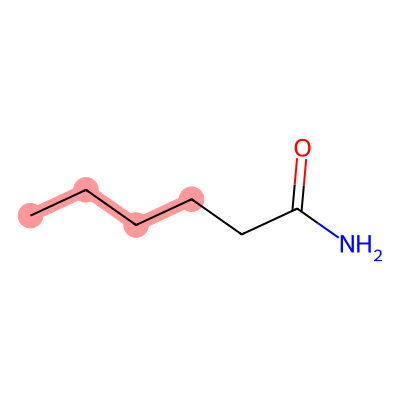

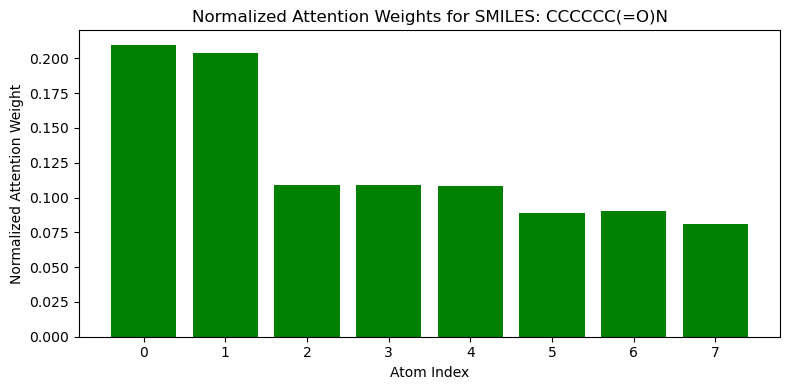

Top 2: SMILES=CC1CN(CC(O1)C)N=O, Prob=0.5396
SMILES: CC1CN(CC(O1)C)N=O
  Atom 0 (C): Attention Score = 0.1503
  Atom 1 (C): Attention Score = 0.1258
  Atom 2 (C): Attention Score = 0.0675
  Atom 3 (N): Attention Score = 0.0579
  Atom 4 (C): Attention Score = 0.0675
  Atom 5 (C): Attention Score = 0.1258
  Atom 6 (O): Attention Score = 0.1402
  Atom 7 (C): Attention Score = 0.1503
  Atom 8 (N): Attention Score = 0.0557
  Atom 9 (O): Attention Score = 0.0592


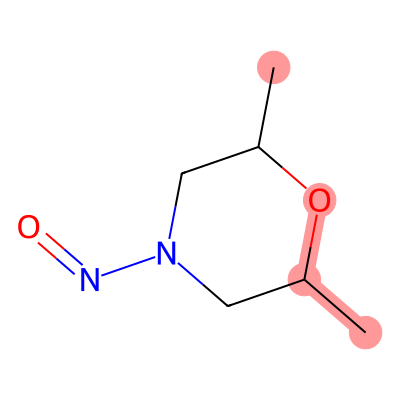

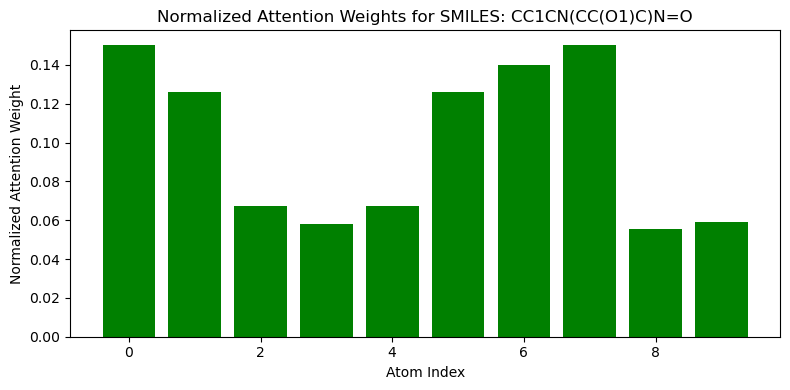

Top 3: SMILES=C1=CC=C2C(=C1)C=CC3=C2C4=C(N3)C=CC5=CC=CC=C54, Prob=0.5216
SMILES: C1=CC=C2C(=C1)C=CC3=C2C4=C(N3)C=CC5=CC=CC=C54
  Atom 0 (C): Attention Score = 0.0622
  Atom 1 (C): Attention Score = 0.0622
  Atom 2 (C): Attention Score = 0.0611
  Atom 3 (C): Attention Score = 0.0259
  Atom 4 (C): Attention Score = 0.0464
  Atom 5 (C): Attention Score = 0.0611
  Atom 6 (C): Attention Score = 0.0611
  Atom 7 (C): Attention Score = 0.0611
  Atom 8 (C): Attention Score = 0.0242
  Atom 9 (C): Attention Score = 0.0232
  Atom 10 (C): Attention Score = 0.0232
  Atom 11 (C): Attention Score = 0.0242
  Atom 12 (N): Attention Score = 0.0231
  Atom 13 (C): Attention Score = 0.0611
  Atom 14 (C): Attention Score = 0.0611
  Atom 15 (C): Attention Score = 0.0464
  Atom 16 (C): Attention Score = 0.0611
  Atom 17 (C): Attention Score = 0.0622
  Atom 18 (C): Attention Score = 0.0622
  Atom 19 (C): Attention Score = 0.0611
  Atom 20 (C): Attention Score = 0.0259


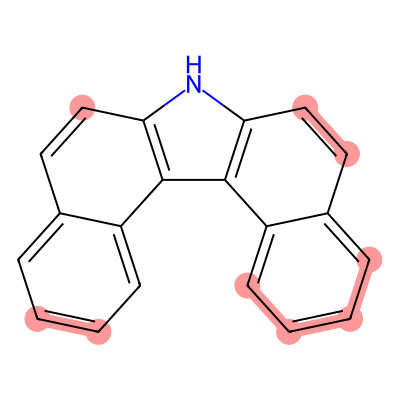

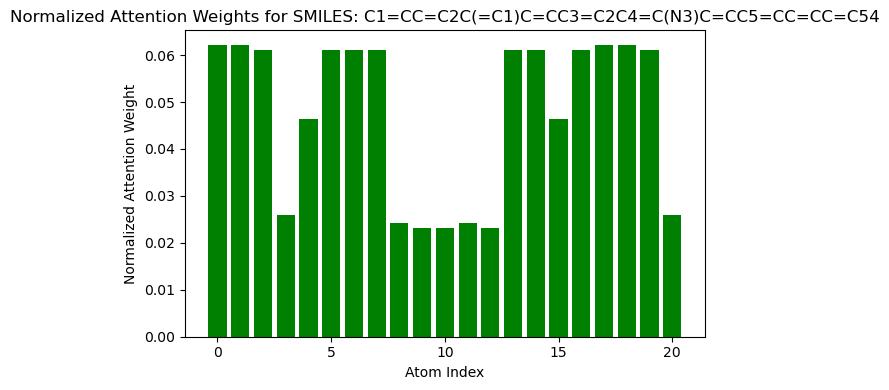

Top 4: SMILES=C1=CN=CC=C1C(=O)NN, Prob=0.5016
SMILES: C1=CN=CC=C1C(=O)NN
  Atom 0 (C): Attention Score = 0.1338
  Atom 1 (C): Attention Score = 0.1338
  Atom 2 (N): Attention Score = 0.1338
  Atom 3 (C): Attention Score = 0.1338
  Atom 4 (C): Attention Score = 0.1338
  Atom 5 (C): Attention Score = 0.1303
  Atom 6 (C): Attention Score = 0.0513
  Atom 7 (O): Attention Score = 0.0497
  Atom 8 (N): Attention Score = 0.0500
  Atom 9 (N): Attention Score = 0.0498


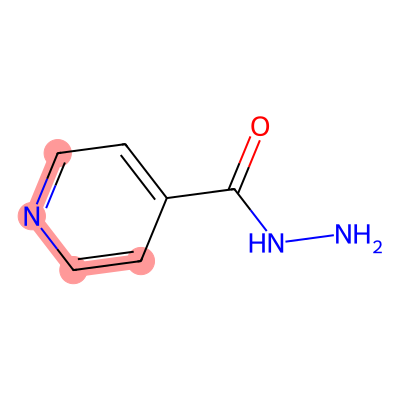

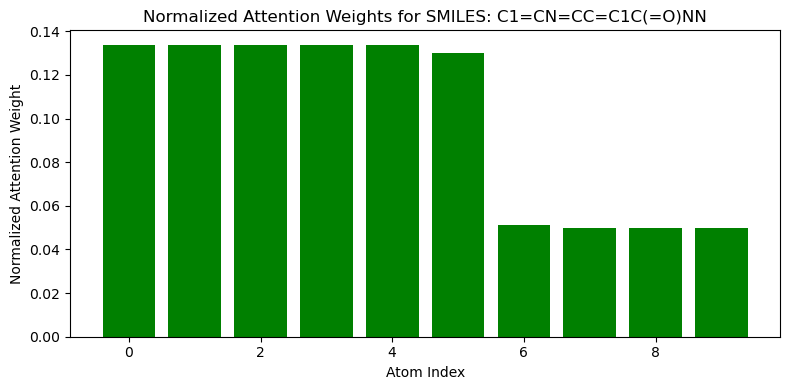

Top 5: SMILES=C1=C(C=C(C(=C1Cl)N)Cl)Cl, Prob=0.4832
SMILES: C1=C(C=C(C(=C1Cl)N)Cl)Cl
  Atom 0 (C): Attention Score = 0.1460
  Atom 1 (C): Attention Score = 0.1460
  Atom 2 (C): Attention Score = 0.1460
  Atom 3 (C): Attention Score = 0.1350
  Atom 4 (C): Attention Score = 0.0718
  Atom 5 (C): Attention Score = 0.1350
  Atom 6 (Cl): Attention Score = 0.0543
  Atom 7 (N): Attention Score = 0.0572
  Atom 8 (Cl): Attention Score = 0.0543
  Atom 9 (Cl): Attention Score = 0.0543


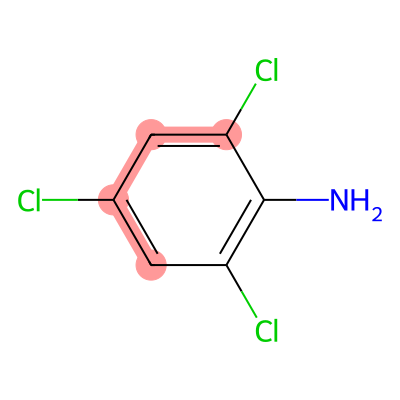

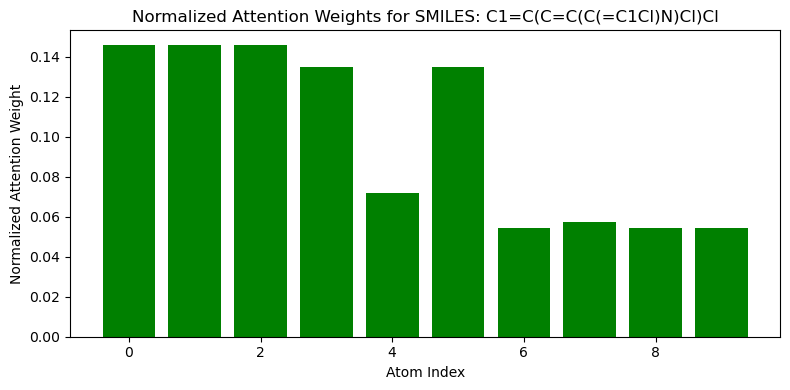

Top 6: SMILES=C1C2=CC=CC=C2C3=C1C=C(C=C3)NC(=O)C(F)(F)F, Prob=0.4804
SMILES: C1C2=CC=CC=C2C3=C1C=C(C=C3)NC(=O)C(F)(F)F
  Atom 0 (C): Attention Score = 0.0295
  Atom 1 (C): Attention Score = 0.0464
  Atom 2 (C): Attention Score = 0.0708
  Atom 3 (C): Attention Score = 0.0708
  Atom 4 (C): Attention Score = 0.0708
  Atom 5 (C): Attention Score = 0.0708
  Atom 6 (C): Attention Score = 0.0618
  Atom 7 (C): Attention Score = 0.0618
  Atom 8 (C): Attention Score = 0.0464
  Atom 9 (C): Attention Score = 0.0675
  Atom 10 (C): Attention Score = 0.0706
  Atom 11 (C): Attention Score = 0.0708
  Atom 12 (C): Attention Score = 0.0708
  Atom 13 (N): Attention Score = 0.0301
  Atom 14 (C): Attention Score = 0.0274
  Atom 15 (O): Attention Score = 0.0294
  Atom 16 (C): Attention Score = 0.0261
  Atom 17 (F): Attention Score = 0.0261
  Atom 18 (F): Attention Score = 0.0261
  Atom 19 (F): Attention Score = 0.0261


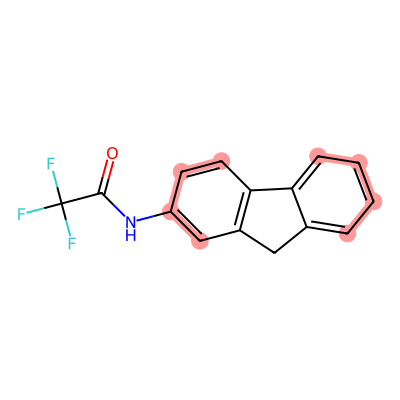

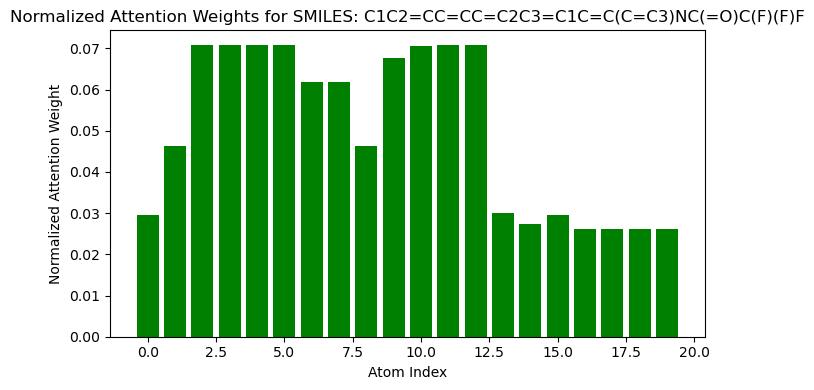

Top 7: SMILES=C(CO)N(CCO)N=O, Prob=0.4788
SMILES: C(CO)N(CCO)N=O
  Atom 0 (C): Attention Score = 0.0714
  Atom 1 (C): Attention Score = 0.1590
  Atom 2 (O): Attention Score = 0.1709
  Atom 3 (N): Attention Score = 0.0687
  Atom 4 (C): Attention Score = 0.0714
  Atom 5 (C): Attention Score = 0.1590
  Atom 6 (O): Attention Score = 0.1709
  Atom 7 (N): Attention Score = 0.0640
  Atom 8 (O): Attention Score = 0.0648


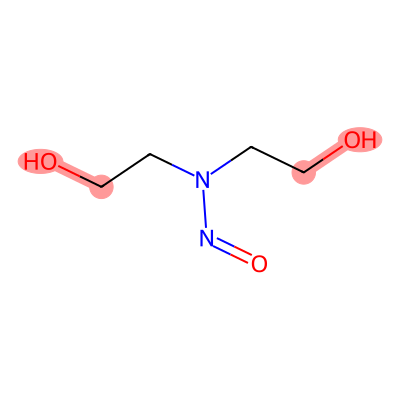

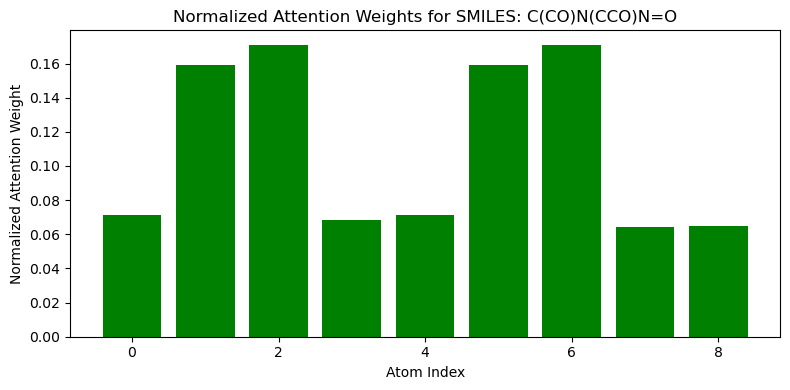


Task lun — Fold 17 (3rd highest AUROC)
Top 1: SMILES=CCCCCC(=O)N, Prob=0.5855
SMILES: CCCCCC(=O)N
  Atom 0 (C): Attention Score = 0.2096
  Atom 1 (C): Attention Score = 0.2042
  Atom 2 (C): Attention Score = 0.1087
  Atom 3 (C): Attention Score = 0.1087
  Atom 4 (C): Attention Score = 0.1085
  Atom 5 (C): Attention Score = 0.0887
  Atom 6 (O): Attention Score = 0.0905
  Atom 7 (N): Attention Score = 0.0812


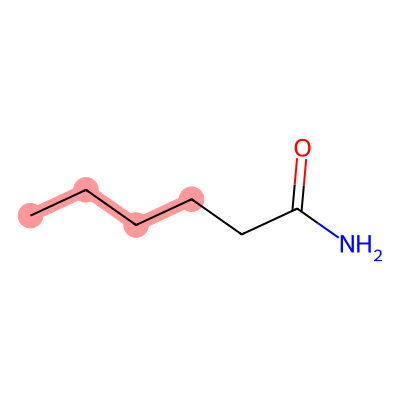

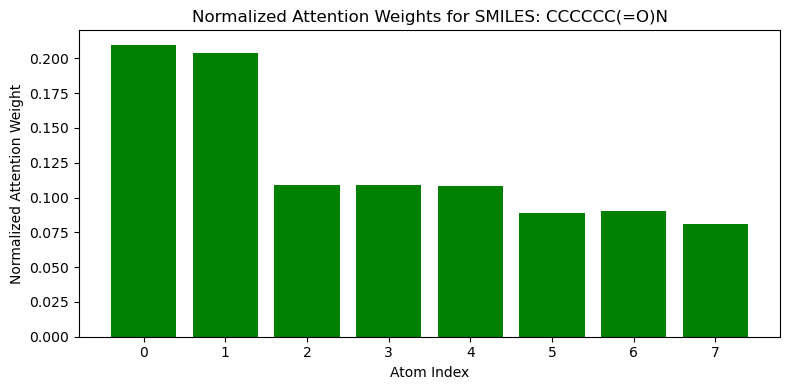

Top 2: SMILES=CC1CN(CC(O1)C)N=O, Prob=0.5643
SMILES: CC1CN(CC(O1)C)N=O
  Atom 0 (C): Attention Score = 0.1503
  Atom 1 (C): Attention Score = 0.1258
  Atom 2 (C): Attention Score = 0.0675
  Atom 3 (N): Attention Score = 0.0579
  Atom 4 (C): Attention Score = 0.0675
  Atom 5 (C): Attention Score = 0.1258
  Atom 6 (O): Attention Score = 0.1402
  Atom 7 (C): Attention Score = 0.1503
  Atom 8 (N): Attention Score = 0.0557
  Atom 9 (O): Attention Score = 0.0592


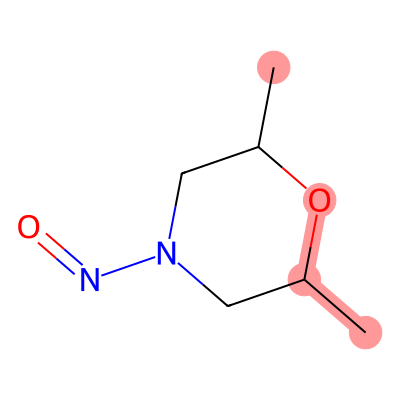

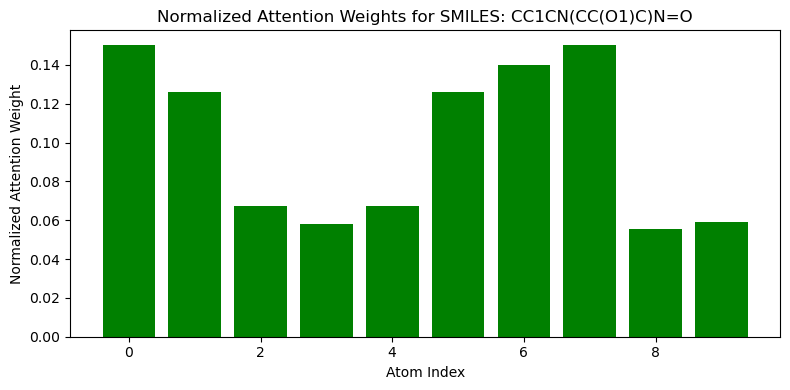

Top 3: SMILES=C1=CC=C2C(=C1)C=CC3=C2C4=C(N3)C=CC5=CC=CC=C54, Prob=0.5401
SMILES: C1=CC=C2C(=C1)C=CC3=C2C4=C(N3)C=CC5=CC=CC=C54
  Atom 0 (C): Attention Score = 0.0622
  Atom 1 (C): Attention Score = 0.0622
  Atom 2 (C): Attention Score = 0.0611
  Atom 3 (C): Attention Score = 0.0259
  Atom 4 (C): Attention Score = 0.0464
  Atom 5 (C): Attention Score = 0.0611
  Atom 6 (C): Attention Score = 0.0611
  Atom 7 (C): Attention Score = 0.0611
  Atom 8 (C): Attention Score = 0.0242
  Atom 9 (C): Attention Score = 0.0232
  Atom 10 (C): Attention Score = 0.0232
  Atom 11 (C): Attention Score = 0.0242
  Atom 12 (N): Attention Score = 0.0231
  Atom 13 (C): Attention Score = 0.0611
  Atom 14 (C): Attention Score = 0.0611
  Atom 15 (C): Attention Score = 0.0464
  Atom 16 (C): Attention Score = 0.0611
  Atom 17 (C): Attention Score = 0.0622
  Atom 18 (C): Attention Score = 0.0622
  Atom 19 (C): Attention Score = 0.0611
  Atom 20 (C): Attention Score = 0.0259


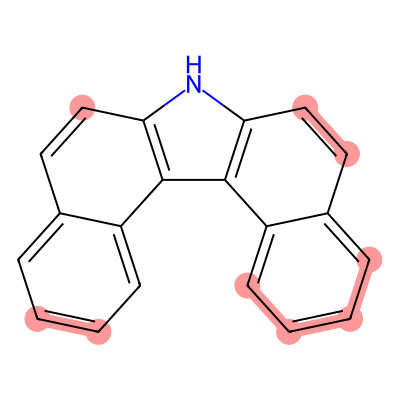

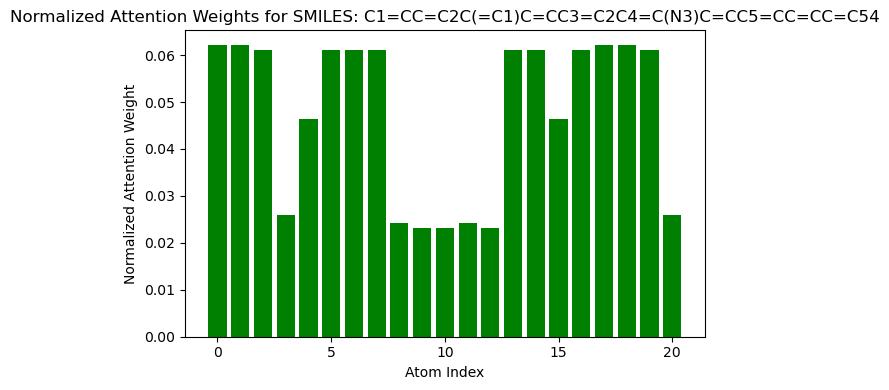

Top 4: SMILES=C=CCN(CC=C)N, Prob=0.5291
SMILES: C=CCN(CC=C)N
  Atom 0 (C): Attention Score = 0.1759
  Atom 1 (C): Attention Score = 0.1732
  Atom 2 (C): Attention Score = 0.0855
  Atom 3 (N): Attention Score = 0.0662
  Atom 4 (C): Attention Score = 0.0855
  Atom 5 (C): Attention Score = 0.1732
  Atom 6 (C): Attention Score = 0.1759
  Atom 7 (N): Attention Score = 0.0648


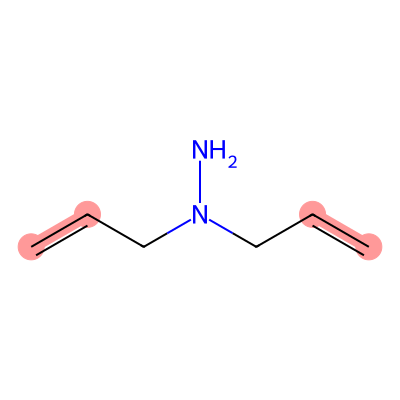

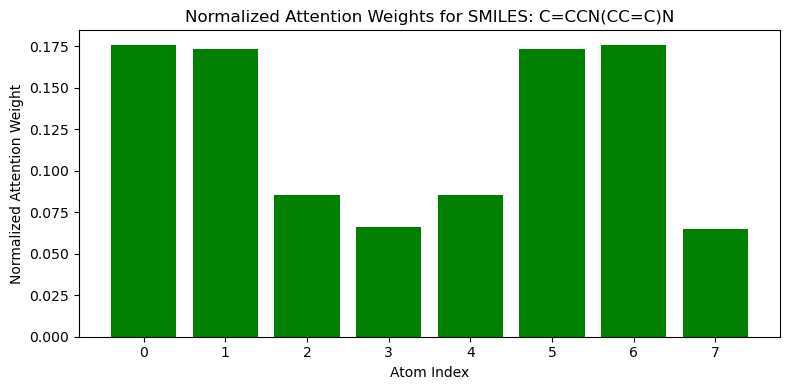

Top 5: SMILES=C1=CN=CC=C1C(=O)NN, Prob=0.5146
SMILES: C1=CN=CC=C1C(=O)NN
  Atom 0 (C): Attention Score = 0.1338
  Atom 1 (C): Attention Score = 0.1338
  Atom 2 (N): Attention Score = 0.1338
  Atom 3 (C): Attention Score = 0.1338
  Atom 4 (C): Attention Score = 0.1338
  Atom 5 (C): Attention Score = 0.1303
  Atom 6 (C): Attention Score = 0.0513
  Atom 7 (O): Attention Score = 0.0497
  Atom 8 (N): Attention Score = 0.0500
  Atom 9 (N): Attention Score = 0.0498


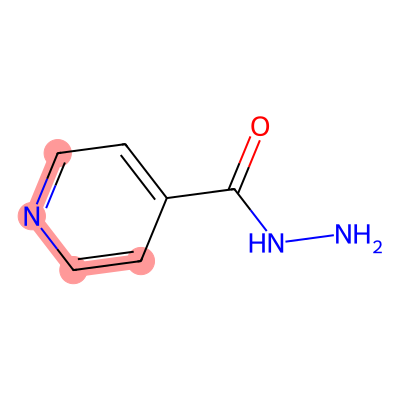

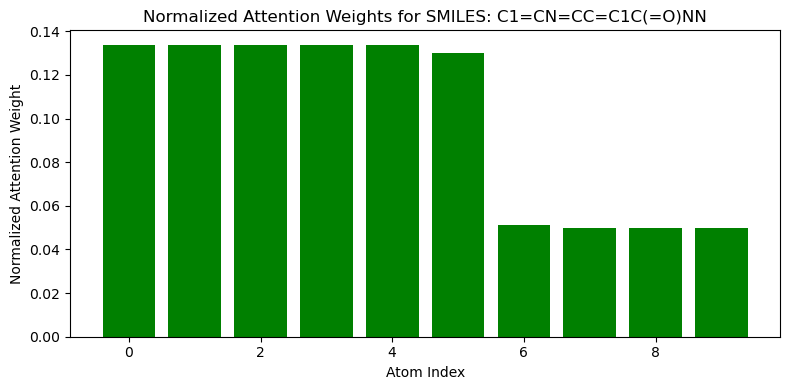

Top 6: SMILES=C(CO)N(CCO)N=O, Prob=0.5100
SMILES: C(CO)N(CCO)N=O
  Atom 0 (C): Attention Score = 0.0714
  Atom 1 (C): Attention Score = 0.1590
  Atom 2 (O): Attention Score = 0.1709
  Atom 3 (N): Attention Score = 0.0687
  Atom 4 (C): Attention Score = 0.0714
  Atom 5 (C): Attention Score = 0.1590
  Atom 6 (O): Attention Score = 0.1709
  Atom 7 (N): Attention Score = 0.0640
  Atom 8 (O): Attention Score = 0.0648


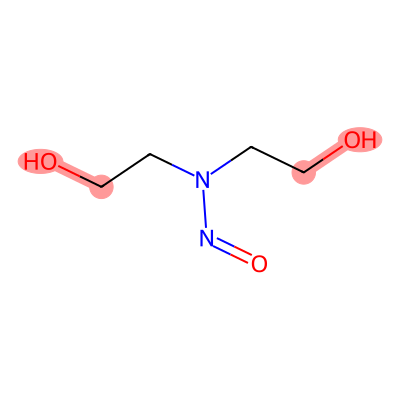

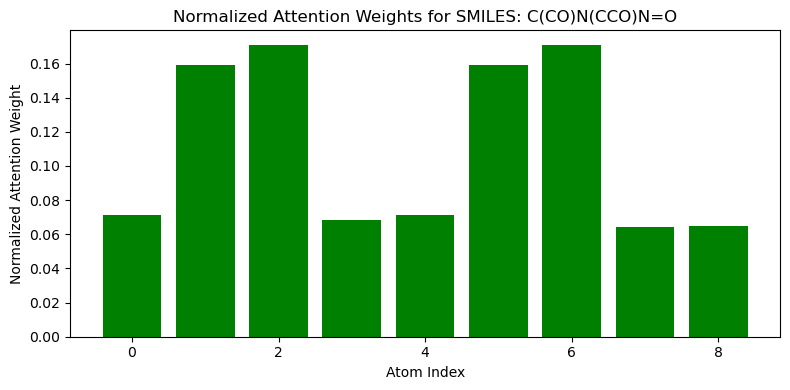

Top 7: SMILES=CC(CN1CC(=O)NC(=O)C1)N2CC(=O)NC(=O)C2, Prob=0.4900
SMILES: CC(CN1CC(=O)NC(=O)C1)N2CC(=O)NC(=O)C2
  Atom 0 (C): Attention Score = 0.0822
  Atom 1 (C): Attention Score = 0.0763
  Atom 2 (C): Attention Score = 0.0358
  Atom 3 (N): Attention Score = 0.0323
  Atom 4 (C): Attention Score = 0.0316
  Atom 5 (C): Attention Score = 0.0795
  Atom 6 (O): Attention Score = 0.0335
  Atom 7 (N): Attention Score = 0.0791
  Atom 8 (C): Attention Score = 0.0795
  Atom 9 (O): Attention Score = 0.0335
  Atom 10 (C): Attention Score = 0.0316
  Atom 11 (N): Attention Score = 0.0370
  Atom 12 (C): Attention Score = 0.0316
  Atom 13 (C): Attention Score = 0.0795
  Atom 14 (O): Attention Score = 0.0335
  Atom 15 (N): Attention Score = 0.0791
  Atom 16 (C): Attention Score = 0.0795
  Atom 17 (O): Attention Score = 0.0335
  Atom 18 (C): Attention Score = 0.0316


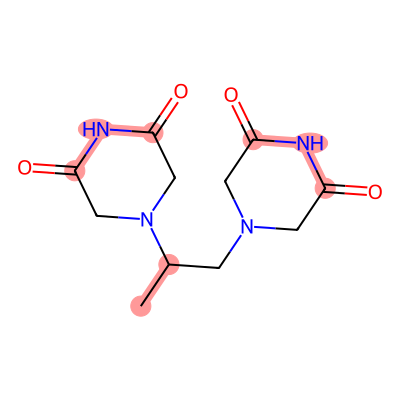

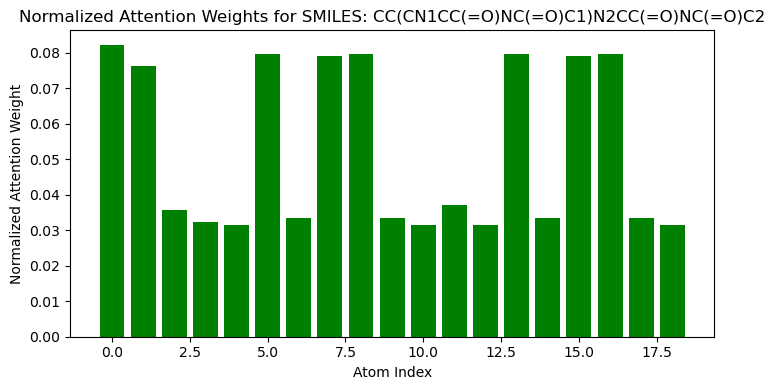

Top 8: SMILES=C1=C(C=C(C(=C1Cl)N)Cl)Cl, Prob=0.4866
SMILES: C1=C(C=C(C(=C1Cl)N)Cl)Cl
  Atom 0 (C): Attention Score = 0.1460
  Atom 1 (C): Attention Score = 0.1460
  Atom 2 (C): Attention Score = 0.1460
  Atom 3 (C): Attention Score = 0.1350
  Atom 4 (C): Attention Score = 0.0718
  Atom 5 (C): Attention Score = 0.1350
  Atom 6 (Cl): Attention Score = 0.0543
  Atom 7 (N): Attention Score = 0.0572
  Atom 8 (Cl): Attention Score = 0.0543
  Atom 9 (Cl): Attention Score = 0.0543


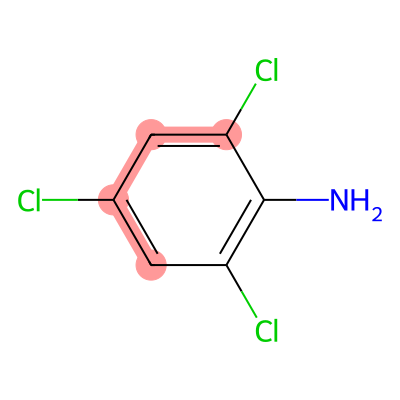

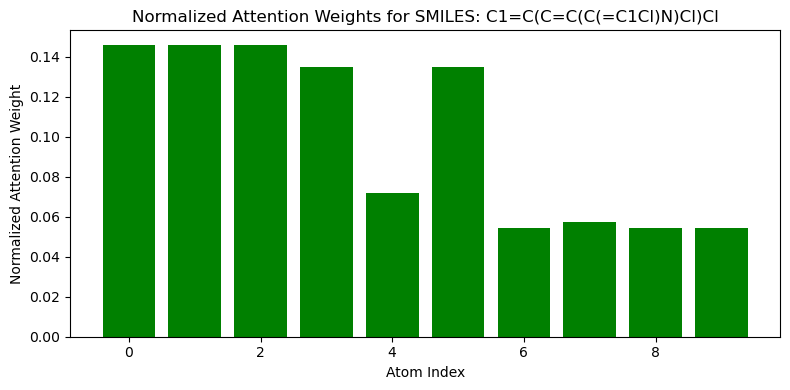


Task sto — Fold 17 (3rd highest AUROC)
Top 1: SMILES=CC1CN(CC(O1)C)N=O, Prob=0.6817
SMILES: CC1CN(CC(O1)C)N=O
  Atom 0 (C): Attention Score = 0.1503
  Atom 1 (C): Attention Score = 0.1258
  Atom 2 (C): Attention Score = 0.0675
  Atom 3 (N): Attention Score = 0.0579
  Atom 4 (C): Attention Score = 0.0675
  Atom 5 (C): Attention Score = 0.1258
  Atom 6 (O): Attention Score = 0.1402
  Atom 7 (C): Attention Score = 0.1503
  Atom 8 (N): Attention Score = 0.0557
  Atom 9 (O): Attention Score = 0.0592


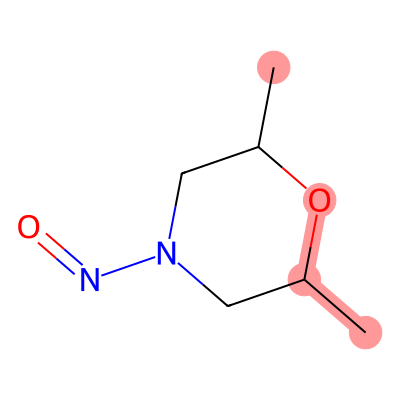

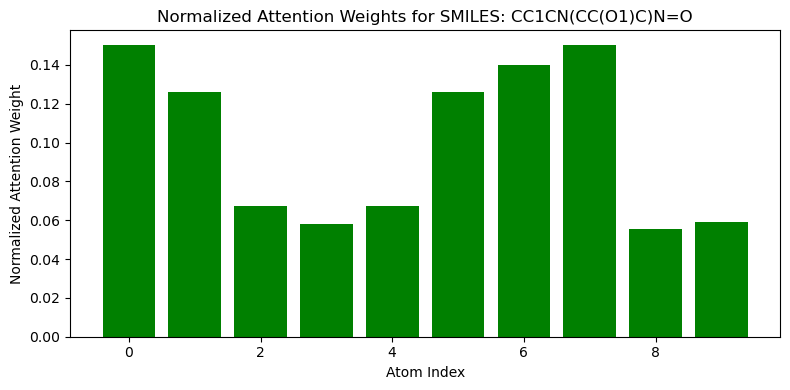

Top 2: SMILES=CCCCCC(=O)N, Prob=0.6304
SMILES: CCCCCC(=O)N
  Atom 0 (C): Attention Score = 0.2096
  Atom 1 (C): Attention Score = 0.2042
  Atom 2 (C): Attention Score = 0.1087
  Atom 3 (C): Attention Score = 0.1087
  Atom 4 (C): Attention Score = 0.1085
  Atom 5 (C): Attention Score = 0.0887
  Atom 6 (O): Attention Score = 0.0905
  Atom 7 (N): Attention Score = 0.0812


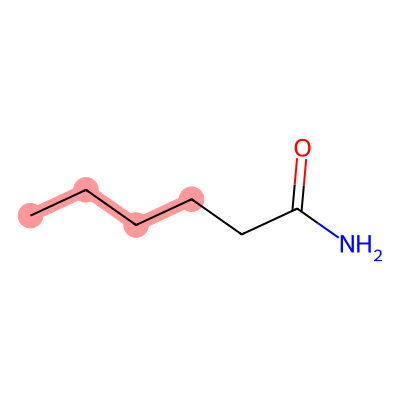

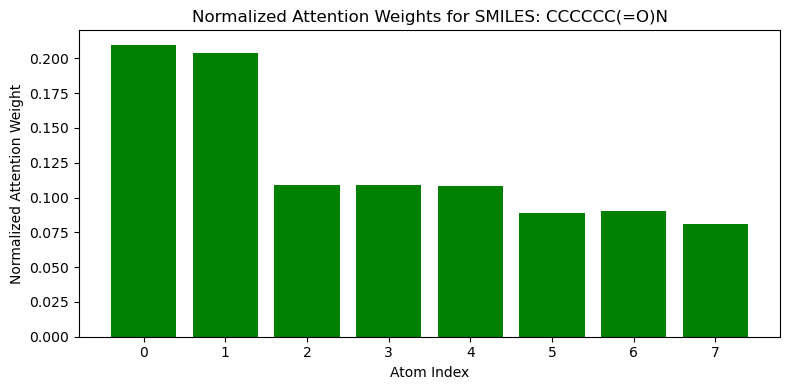

Top 3: SMILES=C=CCN(CC=C)N, Prob=0.5775
SMILES: C=CCN(CC=C)N
  Atom 0 (C): Attention Score = 0.1759
  Atom 1 (C): Attention Score = 0.1732
  Atom 2 (C): Attention Score = 0.0855
  Atom 3 (N): Attention Score = 0.0662
  Atom 4 (C): Attention Score = 0.0855
  Atom 5 (C): Attention Score = 0.1732
  Atom 6 (C): Attention Score = 0.1759
  Atom 7 (N): Attention Score = 0.0648


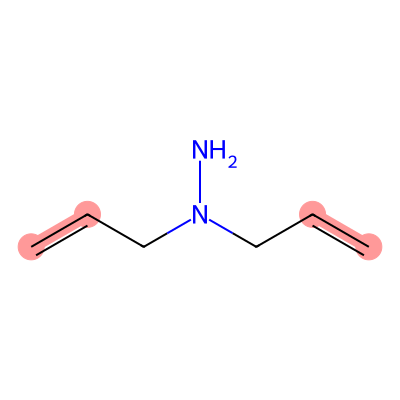

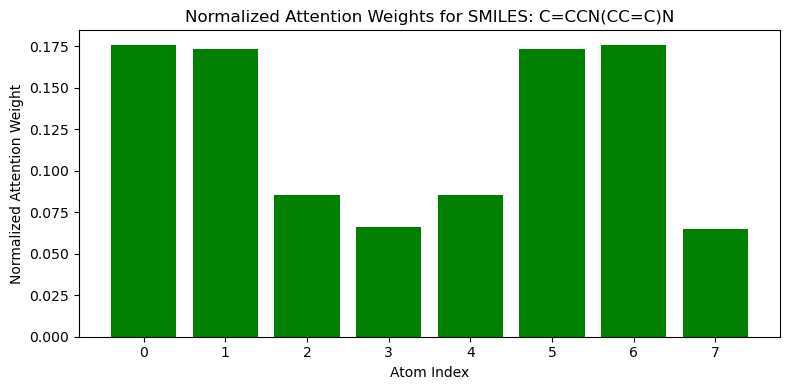

Top 4: SMILES=C(CO)N(CCO)N=O, Prob=0.5516
SMILES: C(CO)N(CCO)N=O
  Atom 0 (C): Attention Score = 0.0714
  Atom 1 (C): Attention Score = 0.1590
  Atom 2 (O): Attention Score = 0.1709
  Atom 3 (N): Attention Score = 0.0687
  Atom 4 (C): Attention Score = 0.0714
  Atom 5 (C): Attention Score = 0.1590
  Atom 6 (O): Attention Score = 0.1709
  Atom 7 (N): Attention Score = 0.0640
  Atom 8 (O): Attention Score = 0.0648


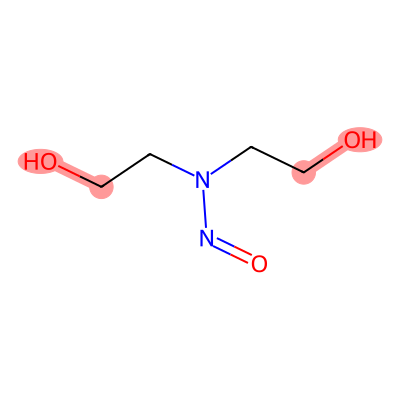

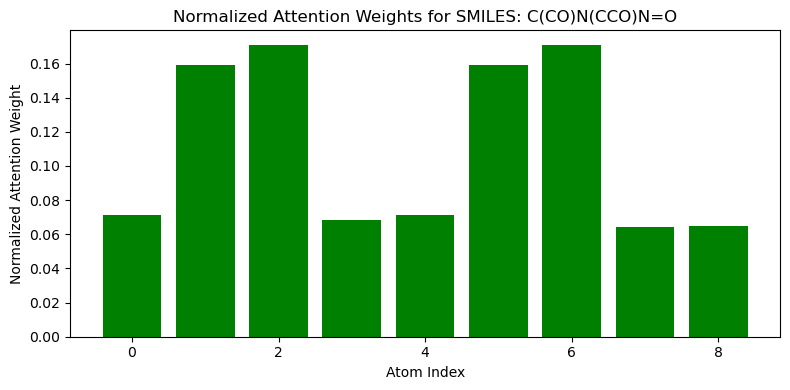

Top 5: SMILES=CN(C)C(=O)NN=O, Prob=0.5065
SMILES: CN(C)C(=O)NN=O
  Atom 0 (C): Attention Score = 0.1346
  Atom 1 (N): Attention Score = 0.1765
  Atom 2 (C): Attention Score = 0.1346
  Atom 3 (C): Attention Score = 0.1050
  Atom 4 (O): Attention Score = 0.0829
  Atom 5 (N): Attention Score = 0.1185
  Atom 6 (N): Attention Score = 0.1760
  Atom 7 (O): Attention Score = 0.0719


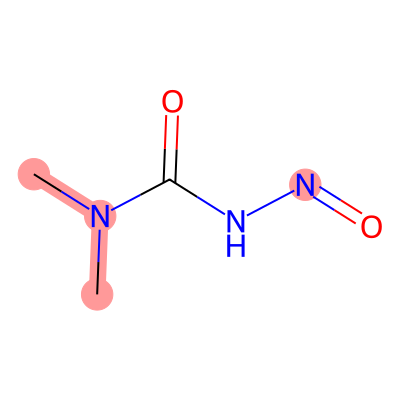

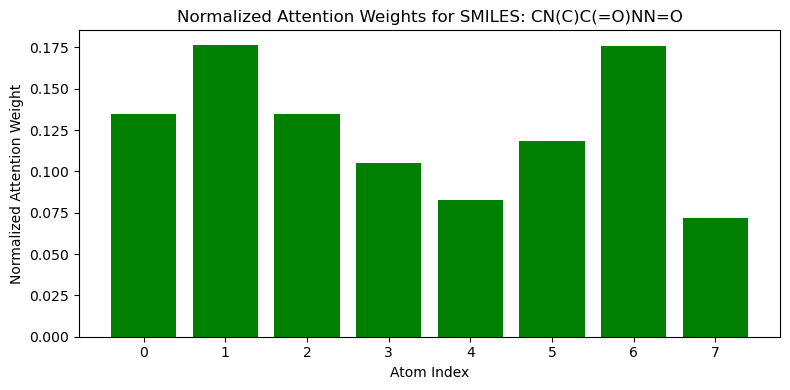

Top 6: SMILES=C1=CC=C2C(=C1)C=CC3=C2C4=C(N3)C=CC5=CC=CC=C54, Prob=0.5045
SMILES: C1=CC=C2C(=C1)C=CC3=C2C4=C(N3)C=CC5=CC=CC=C54
  Atom 0 (C): Attention Score = 0.0622
  Atom 1 (C): Attention Score = 0.0622
  Atom 2 (C): Attention Score = 0.0611
  Atom 3 (C): Attention Score = 0.0259
  Atom 4 (C): Attention Score = 0.0464
  Atom 5 (C): Attention Score = 0.0611
  Atom 6 (C): Attention Score = 0.0611
  Atom 7 (C): Attention Score = 0.0611
  Atom 8 (C): Attention Score = 0.0242
  Atom 9 (C): Attention Score = 0.0232
  Atom 10 (C): Attention Score = 0.0232
  Atom 11 (C): Attention Score = 0.0242
  Atom 12 (N): Attention Score = 0.0231
  Atom 13 (C): Attention Score = 0.0611
  Atom 14 (C): Attention Score = 0.0611
  Atom 15 (C): Attention Score = 0.0464
  Atom 16 (C): Attention Score = 0.0611
  Atom 17 (C): Attention Score = 0.0622
  Atom 18 (C): Attention Score = 0.0622
  Atom 19 (C): Attention Score = 0.0611
  Atom 20 (C): Attention Score = 0.0259


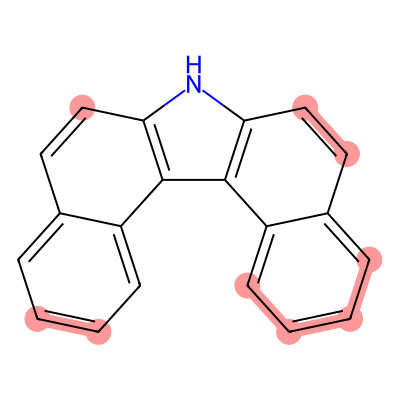

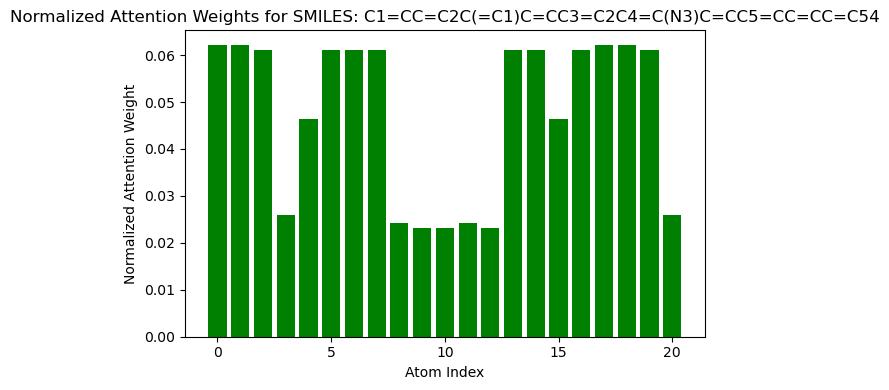

Top 7: SMILES=C1=C(C=C(C(=C1Cl)N)Cl)Cl, Prob=0.4609
SMILES: C1=C(C=C(C(=C1Cl)N)Cl)Cl
  Atom 0 (C): Attention Score = 0.1460
  Atom 1 (C): Attention Score = 0.1460
  Atom 2 (C): Attention Score = 0.1460
  Atom 3 (C): Attention Score = 0.1350
  Atom 4 (C): Attention Score = 0.0718
  Atom 5 (C): Attention Score = 0.1350
  Atom 6 (Cl): Attention Score = 0.0543
  Atom 7 (N): Attention Score = 0.0572
  Atom 8 (Cl): Attention Score = 0.0543
  Atom 9 (Cl): Attention Score = 0.0543


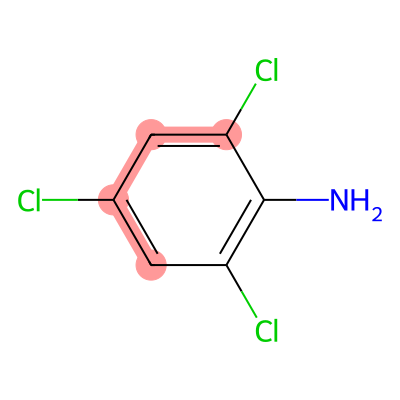

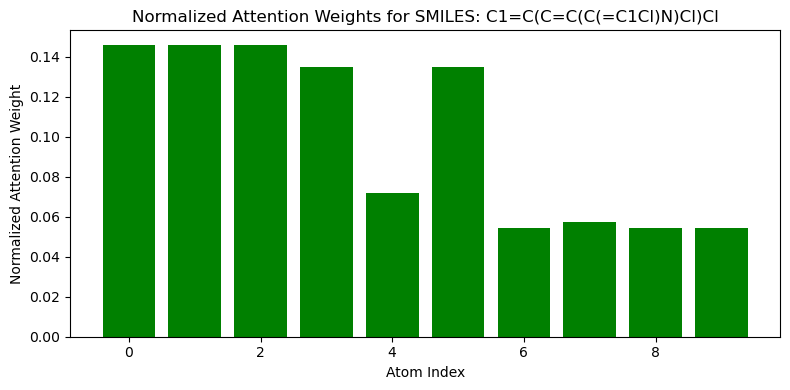

Top 8: SMILES=CC(CN1CC(=O)NC(=O)C1)N2CC(=O)NC(=O)C2, Prob=0.4575
SMILES: CC(CN1CC(=O)NC(=O)C1)N2CC(=O)NC(=O)C2
  Atom 0 (C): Attention Score = 0.0822
  Atom 1 (C): Attention Score = 0.0763
  Atom 2 (C): Attention Score = 0.0358
  Atom 3 (N): Attention Score = 0.0323
  Atom 4 (C): Attention Score = 0.0316
  Atom 5 (C): Attention Score = 0.0795
  Atom 6 (O): Attention Score = 0.0335
  Atom 7 (N): Attention Score = 0.0791
  Atom 8 (C): Attention Score = 0.0795
  Atom 9 (O): Attention Score = 0.0335
  Atom 10 (C): Attention Score = 0.0316
  Atom 11 (N): Attention Score = 0.0370
  Atom 12 (C): Attention Score = 0.0316
  Atom 13 (C): Attention Score = 0.0795
  Atom 14 (O): Attention Score = 0.0335
  Atom 15 (N): Attention Score = 0.0791
  Atom 16 (C): Attention Score = 0.0795
  Atom 17 (O): Attention Score = 0.0335
  Atom 18 (C): Attention Score = 0.0316


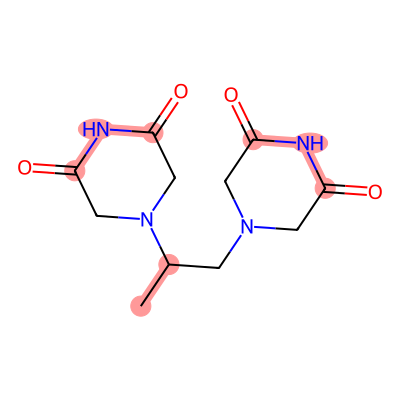

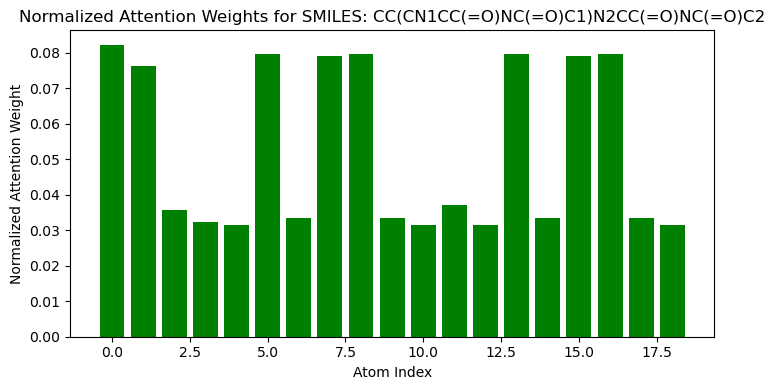


Task mgl — Fold 17 (3rd highest AUROC)
Top 1: SMILES=C1=CN=CC=C1C(=O)NN, Prob=0.5311
SMILES: C1=CN=CC=C1C(=O)NN
  Atom 0 (C): Attention Score = 0.1338
  Atom 1 (C): Attention Score = 0.1338
  Atom 2 (N): Attention Score = 0.1338
  Atom 3 (C): Attention Score = 0.1338
  Atom 4 (C): Attention Score = 0.1338
  Atom 5 (C): Attention Score = 0.1303
  Atom 6 (C): Attention Score = 0.0513
  Atom 7 (O): Attention Score = 0.0497
  Atom 8 (N): Attention Score = 0.0500
  Atom 9 (N): Attention Score = 0.0498


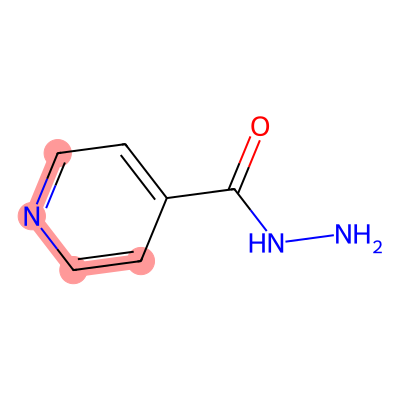

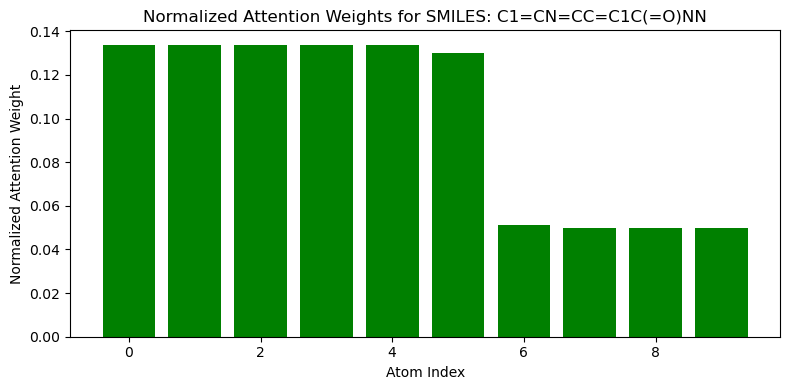

Top 2: SMILES=C1C2=CC=CC=C2C3=C1C=C(C=C3)NC(=O)C(F)(F)F, Prob=0.5220
SMILES: C1C2=CC=CC=C2C3=C1C=C(C=C3)NC(=O)C(F)(F)F
  Atom 0 (C): Attention Score = 0.0295
  Atom 1 (C): Attention Score = 0.0464
  Atom 2 (C): Attention Score = 0.0708
  Atom 3 (C): Attention Score = 0.0708
  Atom 4 (C): Attention Score = 0.0708
  Atom 5 (C): Attention Score = 0.0708
  Atom 6 (C): Attention Score = 0.0618
  Atom 7 (C): Attention Score = 0.0618
  Atom 8 (C): Attention Score = 0.0464
  Atom 9 (C): Attention Score = 0.0675
  Atom 10 (C): Attention Score = 0.0706
  Atom 11 (C): Attention Score = 0.0708
  Atom 12 (C): Attention Score = 0.0708
  Atom 13 (N): Attention Score = 0.0301
  Atom 14 (C): Attention Score = 0.0274
  Atom 15 (O): Attention Score = 0.0294
  Atom 16 (C): Attention Score = 0.0261
  Atom 17 (F): Attention Score = 0.0261
  Atom 18 (F): Attention Score = 0.0261
  Atom 19 (F): Attention Score = 0.0261


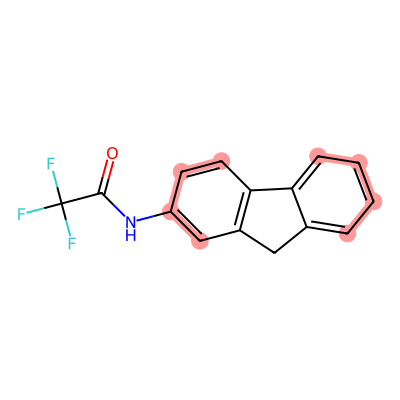

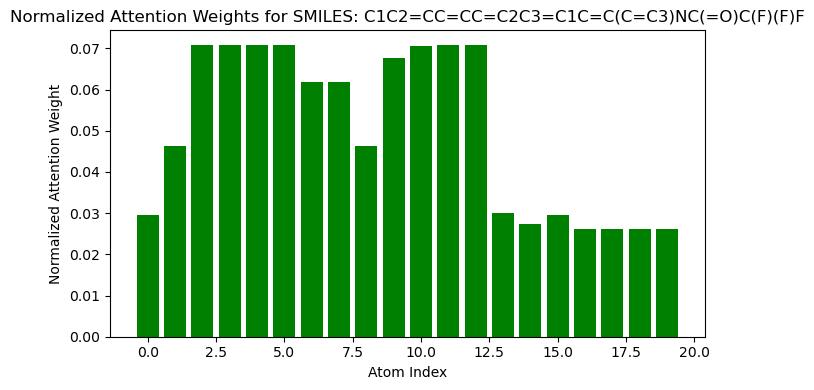

Top 3: SMILES=C1=C(C=C(C(=C1Cl)N)Cl)Cl, Prob=0.5129
SMILES: C1=C(C=C(C(=C1Cl)N)Cl)Cl
  Atom 0 (C): Attention Score = 0.1460
  Atom 1 (C): Attention Score = 0.1460
  Atom 2 (C): Attention Score = 0.1460
  Atom 3 (C): Attention Score = 0.1350
  Atom 4 (C): Attention Score = 0.0718
  Atom 5 (C): Attention Score = 0.1350
  Atom 6 (Cl): Attention Score = 0.0543
  Atom 7 (N): Attention Score = 0.0572
  Atom 8 (Cl): Attention Score = 0.0543
  Atom 9 (Cl): Attention Score = 0.0543


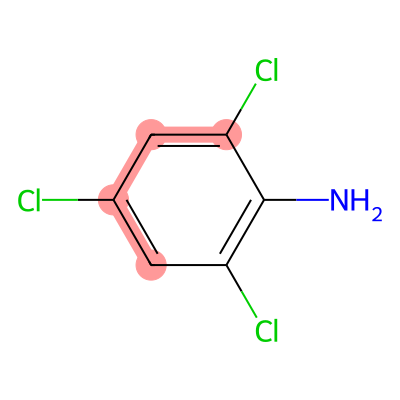

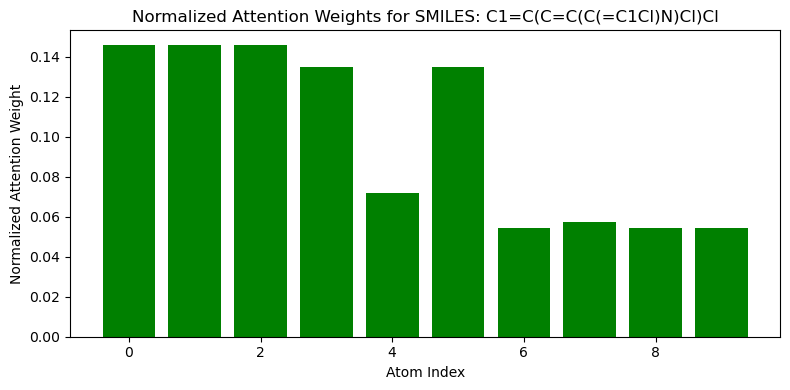

Top 4: SMILES=CCCCCC(=O)N, Prob=0.4993
SMILES: CCCCCC(=O)N
  Atom 0 (C): Attention Score = 0.2096
  Atom 1 (C): Attention Score = 0.2042
  Atom 2 (C): Attention Score = 0.1087
  Atom 3 (C): Attention Score = 0.1087
  Atom 4 (C): Attention Score = 0.1085
  Atom 5 (C): Attention Score = 0.0887
  Atom 6 (O): Attention Score = 0.0905
  Atom 7 (N): Attention Score = 0.0812


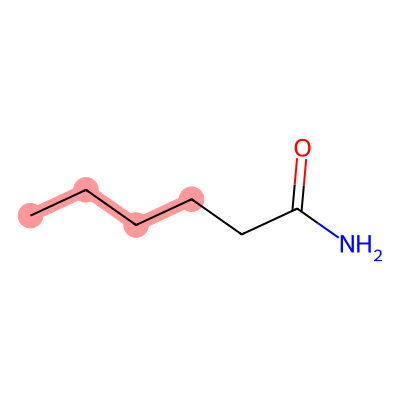

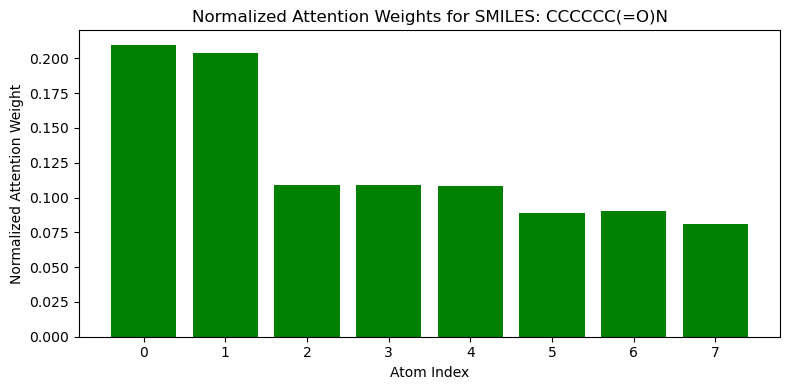

Top 5: SMILES=CCNC1=NC(=NC(=N1)Cl)NC(C)(C)C#N, Prob=0.4670
SMILES: CCNC1=NC(=NC(=N1)Cl)NC(C)(C)C#N
  Atom 0 (C): Attention Score = 0.0768
  Atom 1 (C): Attention Score = 0.0835
  Atom 2 (N): Attention Score = 0.0762
  Atom 3 (C): Attention Score = 0.0665
  Atom 4 (N): Attention Score = 0.0814
  Atom 5 (C): Attention Score = 0.0665
  Atom 6 (N): Attention Score = 0.0814
  Atom 7 (C): Attention Score = 0.0325
  Atom 8 (N): Attention Score = 0.0814
  Atom 9 (Cl): Attention Score = 0.0316
  Atom 10 (N): Attention Score = 0.0638
  Atom 11 (C): Attention Score = 0.0811
  Atom 12 (C): Attention Score = 0.0555
  Atom 13 (C): Attention Score = 0.0555
  Atom 14 (C): Attention Score = 0.0317
  Atom 15 (N): Attention Score = 0.0347


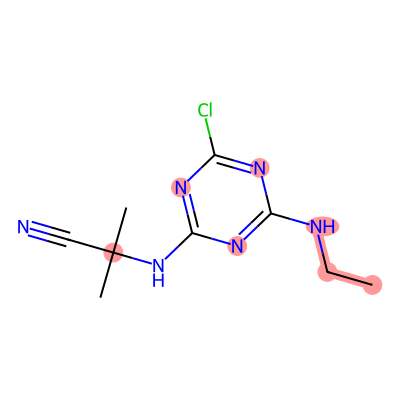

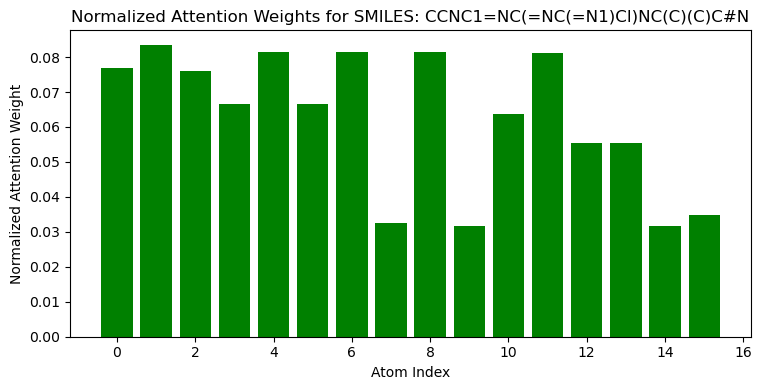

Top 6: SMILES=C1=CC(=CC=C1CCCC(=O)O)N(CCCl)CCCl, Prob=0.4641
SMILES: C1=CC(=CC=C1CCCC(=O)O)N(CCCl)CCCl
  Atom 0 (C): Attention Score = 0.0830
  Atom 1 (C): Attention Score = 0.0830
  Atom 2 (C): Attention Score = 0.0826
  Atom 3 (C): Attention Score = 0.0830
  Atom 4 (C): Attention Score = 0.0830
  Atom 5 (C): Attention Score = 0.0829
  Atom 6 (C): Attention Score = 0.0355
  Atom 7 (C): Attention Score = 0.0342
  Atom 8 (C): Attention Score = 0.0339
  Atom 9 (C): Attention Score = 0.0649
  Atom 10 (O): Attention Score = 0.0315
  Atom 11 (O): Attention Score = 0.0792
  Atom 12 (N): Attention Score = 0.0329
  Atom 13 (C): Attention Score = 0.0323
  Atom 14 (C): Attention Score = 0.0318
  Atom 15 (Cl): Attention Score = 0.0310
  Atom 16 (C): Attention Score = 0.0323
  Atom 17 (C): Attention Score = 0.0318
  Atom 18 (Cl): Attention Score = 0.0310


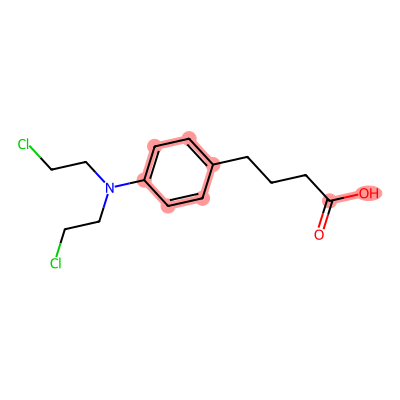

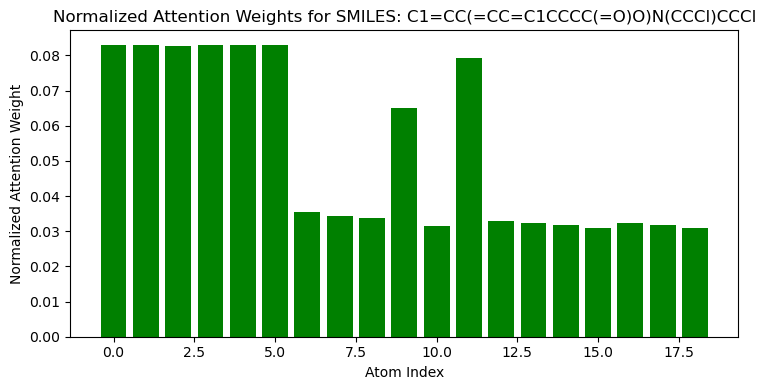

Top 7: SMILES=CC(CN1CC(=O)NC(=O)C1)N2CC(=O)NC(=O)C2, Prob=0.4545
SMILES: CC(CN1CC(=O)NC(=O)C1)N2CC(=O)NC(=O)C2
  Atom 0 (C): Attention Score = 0.0822
  Atom 1 (C): Attention Score = 0.0763
  Atom 2 (C): Attention Score = 0.0358
  Atom 3 (N): Attention Score = 0.0323
  Atom 4 (C): Attention Score = 0.0316
  Atom 5 (C): Attention Score = 0.0795
  Atom 6 (O): Attention Score = 0.0335
  Atom 7 (N): Attention Score = 0.0791
  Atom 8 (C): Attention Score = 0.0795
  Atom 9 (O): Attention Score = 0.0335
  Atom 10 (C): Attention Score = 0.0316
  Atom 11 (N): Attention Score = 0.0370
  Atom 12 (C): Attention Score = 0.0316
  Atom 13 (C): Attention Score = 0.0795
  Atom 14 (O): Attention Score = 0.0335
  Atom 15 (N): Attention Score = 0.0791
  Atom 16 (C): Attention Score = 0.0795
  Atom 17 (O): Attention Score = 0.0335
  Atom 18 (C): Attention Score = 0.0316


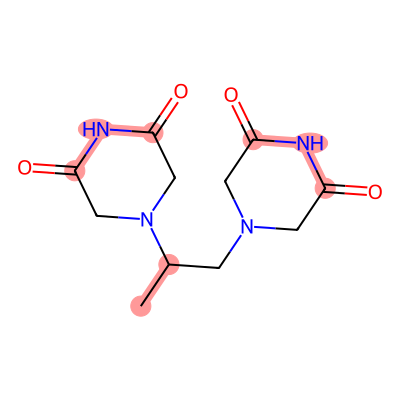

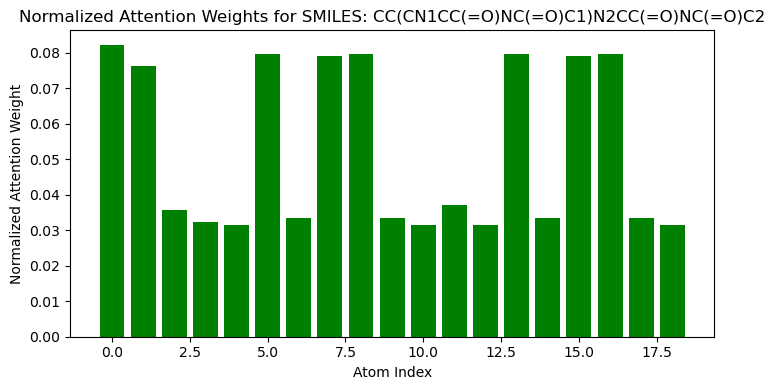

In [21]:
class MultiTaskGAT(nn.Module):
    def __init__(self, num_features, n_heads1, output_dim_idx, dropout, num_tasks=4):
        super(MultiTaskGAT, self).__init__()

        self.conv2 = GATConv(num_features, num_features, heads=n_heads1, dropout=dropout)
        self.relu = nn.ReLU()
        self.graph_norm2 = GraphNorm(num_features * n_heads1)
        
        # Generate task combinations (combinations of 3 out of n_tasks)
        self.task_combinations_2 = list(combinations(range(num_tasks), 3))
        
        # Define hidden layers for each task combination
        self.hidden_layer2 = nn.ModuleList([
            nn.Sequential(
                nn.Linear(num_features * n_heads1, output_dim_idx),
                nn.ReLU(),
                nn.Dropout(dropout),
            ) for _ in self.task_combinations_2
        ])
        
        # Defining the final output layer
        self.final_layer = nn.ModuleList([nn.Linear(output_dim_idx, 1) for _ in range(num_tasks)])
        self.sigmoid = nn.Sigmoid()

        self.attention_net = nn.Sequential(
            nn.Linear(num_features * n_heads1, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

        self.global_attention = GlobalAttention(gate_nn=self.attention_net)
        
        self.node_dropout = nn.Dropout(dropout)
        
        self.weight_matrix = nn.Parameter(torch.ones(len(self.task_combinations_2)))

    def forward(self, data, selected_tasks):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x2 = self.conv2(x, edge_index)
        x = self.graph_norm2(x2, batch)
        x = self.relu(x)
        x = self.node_dropout(x)

        # Attention Pooling
        x, attention_scores = self.global_attention(x, batch)

        # hidden_layer2: 3-task combination
        outputs = {task: [] for task in selected_tasks}
        for idx, (layer, combo) in enumerate(zip(self.hidden_layer2, self.task_combinations_2)):
            if set(combo).issubset(selected_tasks):
                output = layer(x)
                weight = self.weight_matrix[idx]
                for task in combo:
                    outputs[task].append(output * weight)
        
        # Combine the output 
        final_outputs = []
        for task in selected_tasks:
            if outputs[task]:
                combined_output = torch.sum(torch.stack(outputs[task]), dim=0) / len(outputs[task])
                final_output = self.final_layer[task](combined_output).view(-1)
                final_outputs.append(self.sigmoid(final_output))
            else:
                raise IndexError(f"Task {task} has no corresponding output in outputs dictionary.")

        return x, tuple(final_outputs), attention_scores

def visualize_attention_with_highlights(smiles, node_attention, top_percent=0.3):
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Invalid SMILES string: {smiles}")
        return
    num_atoms = mol.GetNumAtoms()
    highlight_atom_indices = []

    if isinstance(node_attention, torch.Tensor):
        node_attention = node_attention.cpu().numpy().tolist()
    elif isinstance(node_attention, np.ndarray):
        node_attention = node_attention.tolist()
    elif isinstance(node_attention, list):
        pass  
    else:
        print(f"Unsupported node_attention type: {type(node_attention)}")
        return

    if len(node_attention) != num_atoms:
        print(f"Warning: Attention scores count ({len(node_attention)}) does not match number of atoms ({num_atoms}).")
        min_len = min(len(node_attention), num_atoms)
        node_attention = node_attention[:min_len]
        num_atoms = min_len

    top_n = max(1, int(np.ceil(top_percent * num_atoms)))
    sorted_indices = sorted(range(num_atoms), key=lambda i: node_attention[i], reverse=True)
    highlight_atom_indices = sorted(sorted_indices[:top_n])
    
    # Node attention score output
    print(f"SMILES: {smiles}")
    for idx, (atom, attn) in enumerate(zip(mol.GetAtoms(), node_attention)):
        print(f"  Atom {idx} ({atom.GetSymbol()}): Attention Score = {attn:.4f}")

    highlight_atom_indices = sorted(set(highlight_atom_indices))
    
    if len(highlight_atom_indices) > 0:
        highlight_colors = {idx: (1.0, 0.6, 0.6) for idx in highlight_atom_indices}
    else:
        highlight_colors = {}

    # Molecular visualisation
    drawer = Draw.MolDraw2DCairo(400, 400)
    opts = drawer.drawOptions()
    opts.highlightColour = (1.0, 0.0, 0.0)
    drawer.DrawMolecule(mol, highlightAtoms=highlight_atom_indices, highlightAtomColors=highlight_colors)
    drawer.FinishDrawing()
    img_data = drawer.GetDrawingText()
    
    img = Image.open(io.BytesIO(img_data))
    display(img)
    
    # Normalised Attention Weights bar graph visualisation
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(node_attention)), node_attention, color='green')
    plt.title(f'Normalized Attention Weights for SMILES: {smiles}')
    plt.xlabel('Atom Index')
    plt.ylabel('Normalized Attention Weight')
    plt.tight_layout()
    plt.show()

# Define a function to output performance metrics
def printPerformance_multi(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = np.nan
    try:
        pr_auc = average_precision_score(y_true, y_pred)
    except ValueError:
        pr_auc = np.nan
    y_pred_labels = (y_pred >= 0.45).astype(int)
    accuracy = accuracy_score(y_true, y_pred_labels)
    print(f"  AUC: {auc:.4f}, PR AUC: {pr_auc:.4f}, Accuracy: {accuracy:.4f}")


def extract_attention_scores_per_molecule(batch, node_attention, smiles):
    
    attention_scores_per_molecule = []
    selected_smiles = []
    
    num_molecules = batch.num_graphs
    
    for i in range(num_molecules):
        node_indices = (batch.batch == i).nonzero(as_tuple=True)[0]
        molecule_attention = node_attention[node_indices].cpu().numpy().flatten().tolist()
        molecule_smiles = smiles[i]
        selected_smiles.append(molecule_smiles)
        
        mol = Chem.MolFromSmiles(molecule_smiles)
        if mol is None:
            print(f"Invalid SMILES string: {molecule_smiles}")
            attention_scores_per_molecule.append([])
            continue
        
        num_atoms = mol.GetNumAtoms()
        atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
        
        if len(molecule_attention) != num_atoms:
            print(f"Warning: Attention scores count ({len(molecule_attention)}) does not match number of atoms ({num_atoms}).")
        
        attention_scores_per_molecule.append(molecule_attention)
    
    return attention_scores_per_molecule, selected_smiles

def save_predictions_to_csv(all_fold_results, list_tissue, output_dir='prediction_results'):
    
    os.makedirs(output_dir, exist_ok=True)
    
    task_data = {task: {'fold': [], 'smiles': [], 'y_true': [], 'y_pred': []} for task in list_tissue}
    
    for fold_result in all_fold_results:
        fold = fold_result['fold']
        smiles_list = fold_result['smiles']
        task_metrics = fold_result['task_metrics']
        
        for task_idx, task_name in enumerate(list_tissue):
            task_key = f"task_{task_idx}"
            y_true = task_metrics[task_key]['y_true']
            y_pred = task_metrics[task_key]['y_pred']
            
            for i, smiles in enumerate(smiles_list):
                task_data[task_name]['fold'].append(fold)
                task_data[task_name]['smiles'].append(smiles)
                task_data[task_name]['y_true'].append(y_true[i])
                task_data[task_name]['y_pred'].append(y_pred[i])
    
    for task_name, data in task_data.items():
        df = pd.DataFrame(data)
        csv_path = os.path.join(output_dir, f'{task_name}_predictions.csv')
        df.to_csv(csv_path, index=False)
        print(f"Saved predictions for task '{task_name}' to {csv_path}")

def test_and_collect(model, criterion, test_loader, device, list_tissue):
    model.eval()
    task_losses = defaultdict(float)
    num_batches = defaultdict(int)
    task_metrics = defaultdict(lambda: {'y_true': [], 'y_pred': []})
    
    all_node_attention_scores = []
    all_smiles = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            
            x, list_task, node_attention_scores = model(batch, selected_tasks=tuple(range(len(list_tissue))))
            
            for task_idx, task in enumerate(list_tissue):
                task_key = f"task_{task_idx}"
                task_metrics[task_key]['y_true'].extend(batch.y[:, task_idx].cpu().tolist())
                task_metrics[task_key]['y_pred'].extend(list_task[task_idx].cpu().tolist())

            attention_scores_per_molecule, selected_smiles = extract_attention_scores_per_molecule(
                batch, node_attention_scores, smiles=batch.smiles)
            all_node_attention_scores.extend(attention_scores_per_molecule)
            all_smiles.extend(selected_smiles)

    task_results = {}
    
    for task_idx, task_name in enumerate(list_tissue):
        task_key = f"task_{task_idx}"
        if task_key in task_metrics:
            y_true = np.array(task_metrics[task_key]['y_true'])
            y_pred = np.array(task_metrics[task_key]['y_pred'])
            try:
                auc = roc_auc_score(y_true, y_pred)
            except ValueError:
                auc = np.nan

            try:
                pr_auc = average_precision_score(y_true, y_pred)
            except ValueError:
                pr_auc = np.nan

            y_pred_labels = (y_pred >= 0.45).astype(int)
            accuracy = accuracy_score(y_true, y_pred_labels)
            avg_loss = np.nan  
            task_results[task_key] = {
                'loss': avg_loss,
                'auc': auc,
                'pr_auc': pr_auc,
                'accuracy': accuracy
            }
        else:
            task_results[task_key] = {
                'loss': np.nan,
                'auc': np.nan,
                'pr_auc': np.nan,
                'accuracy': np.nan
            }
    return task_results, task_metrics, all_node_attention_scores, all_smiles

def main():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    K = 20
    list_tissue = ["liv", "lun", "sto", "mgl"]

    data_dir = '/data/home/dbswn0814/2025JCM/model/multi task3/data'
    models_dir = '/data/home/dbswn0814/2025JCM/model/multi task3/model'

    model = MultiTaskGAT(
        num_features=75, n_heads1=2,
        output_dim_idx=16, dropout=0.2,
        num_tasks=len(list_tissue)
    ).to(device)
    criterion = FocalLoss(alpha=0.25, gamma=4.0, reduction='mean')

    all_fold_results = []
    fold_attention_data = {}
    all_task_results = defaultdict(lambda: {'auc': [], 'pr_auc': [], 'accuracy': []})

    for fold in range(1, K+1):
        test_path = os.path.join(data_dir, f'fold_{fold}_test.pt')
        model_path = os.path.join(models_dir, f'fold_{fold}_final.pth')
        if not os.path.exists(test_path) or not os.path.exists(model_path):
            print(f"Skipping fold {fold}: data or model file missing.")
            continue

        test_dataset = torch.load(test_path)
        test_loader = TorchDataLoader(
            test_dataset, batch_size=8,
            shuffle=False, collate_fn=Batch.from_data_list
        )
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint)
        model.eval()


        test_results, task_metrics, attn_scores, smiles_list = test_and_collect(
            model, criterion, test_loader, device, list_tissue
        )

        all_fold_results.append({
            'fold': fold,
            'test_results': test_results,
            'task_metrics': task_metrics,
            'node_attention_scores': attn_scores,
            'smiles': smiles_list
        })
        fold_attention_data[fold] = {
            'test_results': test_results,
            'task_metrics': task_metrics,
            'node_attention_scores': attn_scores,
            'smiles': smiles_list
        }

        for key, res in test_results.items():
            all_task_results[key]['auc'].append(res['auc'])
            all_task_results[key]['pr_auc'].append(res['pr_auc'])
            all_task_results[key]['accuracy'].append(res['accuracy'])


    print("\n=== Average results across all folds ===")
    for idx, name in enumerate(list_tissue):
        key = f"task_{idx}"
        aucs = np.array(all_task_results[key]['auc'])
        pr_aucs = np.array(all_task_results[key]['pr_auc'])
        accs = np.array(all_task_results[key]['accuracy'])
        print(f"Task {name}: AUC={np.nanmean(aucs):.4f}±{np.nanstd(aucs):.4f}, "
              f"PR AUC={np.nanmean(pr_aucs):.4f}±{np.nanstd(pr_aucs):.4f}, "
              f"Acc={np.nanmean(accs):.4f}")


    pr_list = []
    for fr in all_fold_results:
        pr_vals = [fr['test_results'][f"task_{i}"]['pr_auc'] for i in range(len(list_tissue))]
        pr_list.append((fr['fold'], np.nanmean(pr_vals)))
    pr_sorted = sorted(pr_list, key=lambda x: x[1], reverse=True)
    if pr_sorted:
        best_fold, best_pr = pr_sorted[0]
        worst_fold, worst_pr = pr_sorted[-1]
        print(f"\nBest fold(PR AUC): {best_fold} ({best_pr:.4f}), Worst fold(PR AUC): {worst_fold} ({worst_pr:.4f})")


    auc_list = []
    for fr in all_fold_results:
        auc_vals = [fr['test_results'][f"task_{i}"]['auc'] for i in range(len(list_tissue))]
        auc_list.append((fr['fold'], np.nanmean(auc_vals)))
    auc_sorted = sorted(auc_list, key=lambda x: x[1], reverse=True)


    if len(auc_sorted) >= 3:
        third_fold, third_auc = auc_sorted[2]
        print(f"\nFold with the 3rd highest average AUROC: Fold {third_fold} ({third_auc:.4f})")

        data3 = fold_attention_data[third_fold]
        tm3 = data3['task_metrics']
        ns3 = data3['node_attention_scores']
        sm3 = data3['smiles']


        task_details_3rd = {f"task_{i}": [] for i in range(len(list_tissue))}
        for i, (attn, smi) in enumerate(zip(ns3, sm3)):
            for idx in range(len(list_tissue)):
                key = f"task_{idx}"
                if tm3[key]['y_true'][i] == 1 and tm3[key]['y_pred'][i] >= 0.45:
                    task_details_3rd[key].append((smi, attn))


        for idx, name in enumerate(list_tissue):
            key = f"task_{idx}"
            print("\n" + "="*80)
            print(f"Task {name} — Fold {third_fold} (3rd highest AUROC)")
            if not task_details_3rd[key]:
                print("  No positive samples with y_true=1 & y_pred>=0.45.")
                continue

            preds = np.array(tm3[key]['y_pred'])
            pos_idx = [
                i for i, (yt, yp) in enumerate(zip(tm3[key]['y_true'], tm3[key]['y_pred']))
                if yt == 1 and yp >= 0.45
            ]
            pos_data = [(preds[i], task_details_3rd[key][j]) for j, i in enumerate(pos_idx)]
            top_data = sorted(pos_data, key=lambda x: x[0], reverse=True)[:10]

            for rank, (prob, (smi, attn)) in enumerate(top_data, 1):
                print(f"Top {rank}: SMILES={smi}, Prob={prob:.4f}")
                visualize_attention_with_highlights(smi, attn, top_percent=0.4)
    else:
        print("fail.")
        
if __name__ == "__main__":
    main()


=== Average results across all folds ===
Task liv: AUC=0.7338±0.1214, PR AUC=0.7496±0.1293, Acc=0.6814
Task lun: AUC=0.7674±0.1016, PR AUC=0.7995±0.1047, Acc=0.7291
Task sto: AUC=0.8087±0.1273, PR AUC=0.8482±0.1054, Acc=0.7310
Task mgl: AUC=0.7766±0.1071, PR AUC=0.8026±0.0910, Acc=0.7288

Best fold(PR AUC): 14 (0.9689), Worst fold(PR AUC): 8 (0.6127)

Fold with the 3rd highest average AUROC: Fold 20 (0.8502)

Task liv — Fold 20 (3rd highest AUROC)
Top 1: SMILES=CCCCCN(C)N=O, Prob=0.5641
SMILES: CCCCCN(C)N=O
  Atom 0 (C): Attention Score = 0.1619
  Atom 1 (C): Attention Score = 0.1547
  Atom 2 (C): Attention Score = 0.1408
  Atom 3 (C): Attention Score = 0.1408
  Atom 4 (C): Attention Score = 0.0658
  Atom 5 (N): Attention Score = 0.0684
  Atom 6 (C): Attention Score = 0.1444
  Atom 7 (N): Attention Score = 0.0612
  Atom 8 (O): Attention Score = 0.0620


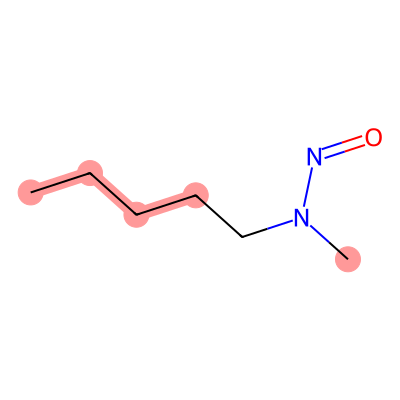

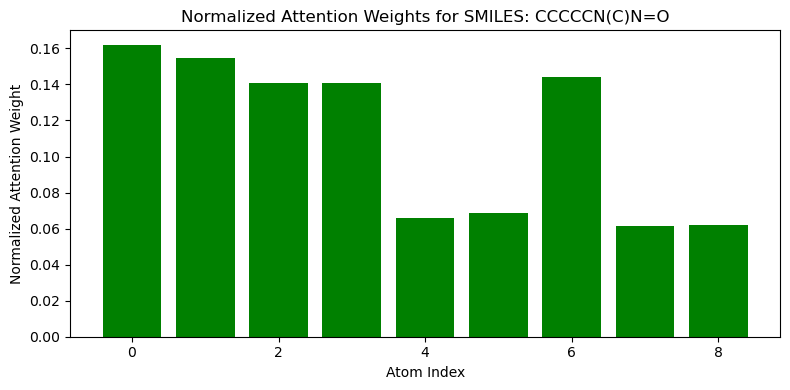

Top 2: SMILES=CN(C)N, Prob=0.5314
SMILES: CN(C)N
  Atom 0 (C): Attention Score = 0.2714
  Atom 1 (N): Attention Score = 0.3287
  Atom 2 (C): Attention Score = 0.2714
  Atom 3 (N): Attention Score = 0.1286


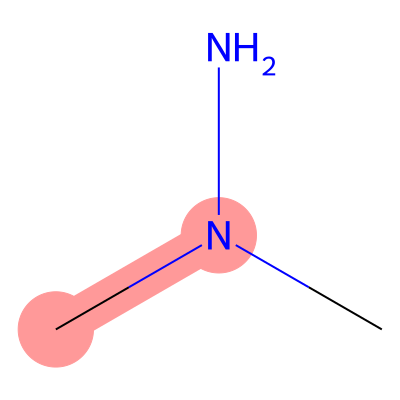

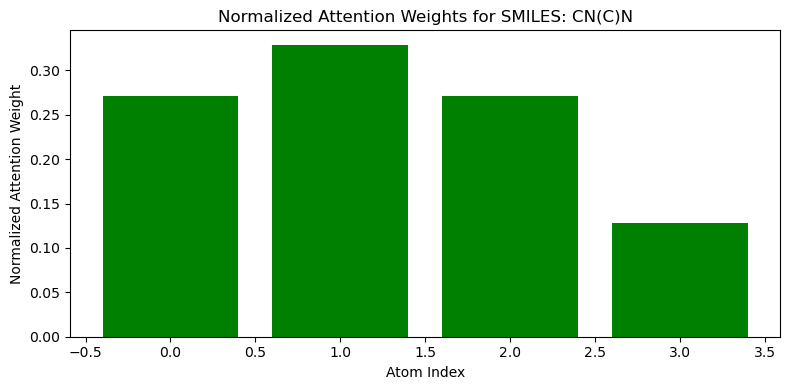

Top 3: SMILES=C1=CC(=C(C=C1C2=CC(=C(C=C2)N)Cl)Cl)N, Prob=0.5265
SMILES: C1=CC(=C(C=C1C2=CC(=C(C=C2)N)Cl)Cl)N
  Atom 0 (C): Attention Score = 0.0902
  Atom 1 (C): Attention Score = 0.0902
  Atom 2 (C): Attention Score = 0.0428
  Atom 3 (C): Attention Score = 0.0351
  Atom 4 (C): Attention Score = 0.0852
  Atom 5 (C): Attention Score = 0.0900
  Atom 6 (C): Attention Score = 0.0900
  Atom 7 (C): Attention Score = 0.0852
  Atom 8 (C): Attention Score = 0.0351
  Atom 9 (C): Attention Score = 0.0428
  Atom 10 (C): Attention Score = 0.0902
  Atom 11 (C): Attention Score = 0.0902
  Atom 12 (N): Attention Score = 0.0333
  Atom 13 (Cl): Attention Score = 0.0332
  Atom 14 (Cl): Attention Score = 0.0332
  Atom 15 (N): Attention Score = 0.0333


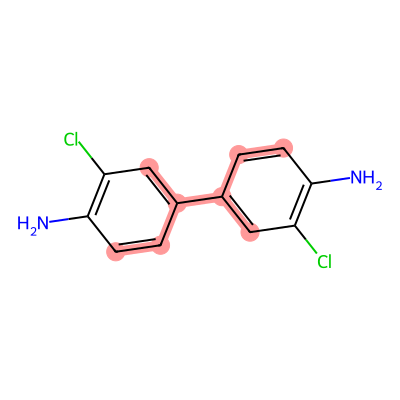

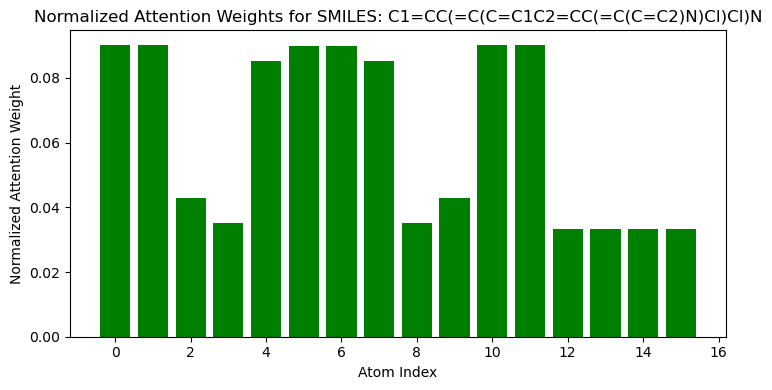

Top 4: SMILES=C=CCl, Prob=0.5113
SMILES: C=CCl
  Atom 0 (C): Attention Score = 0.5661
  Atom 1 (C): Attention Score = 0.2219
  Atom 2 (Cl): Attention Score = 0.2120


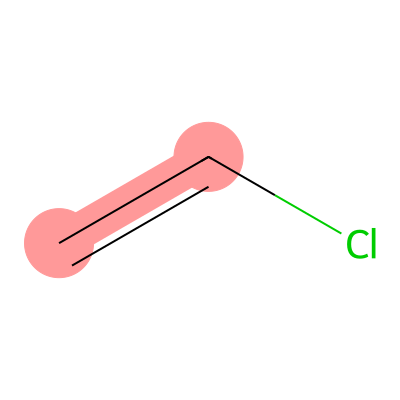

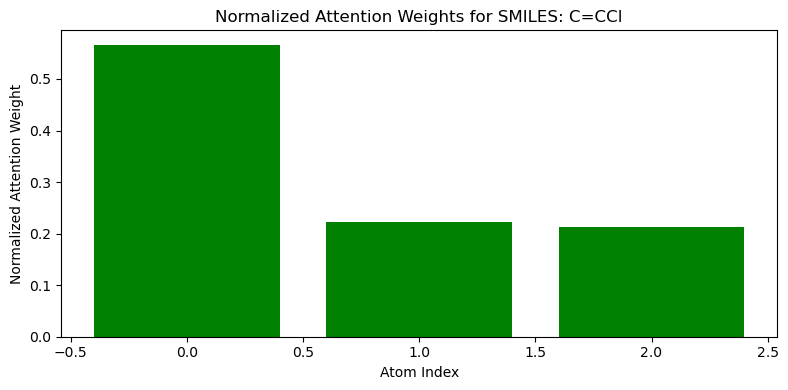

Top 5: SMILES=C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=C(C=C3Br)Br)N, Prob=0.5005
SMILES: C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=C(C=C3Br)Br)N
  Atom 0 (C): Attention Score = 0.0844
  Atom 1 (C): Attention Score = 0.0844
  Atom 2 (C): Attention Score = 0.0844
  Atom 3 (C): Attention Score = 0.0744
  Atom 4 (C): Attention Score = 0.0744
  Atom 5 (C): Attention Score = 0.0844
  Atom 6 (C): Attention Score = 0.0345
  Atom 7 (O): Attention Score = 0.0314
  Atom 8 (C): Attention Score = 0.0512
  Atom 9 (C): Attention Score = 0.0512
  Atom 10 (C): Attention Score = 0.0345
  Atom 11 (O): Attention Score = 0.0314
  Atom 12 (C): Attention Score = 0.0332
  Atom 13 (C): Attention Score = 0.0345
  Atom 14 (C): Attention Score = 0.0836
  Atom 15 (C): Attention Score = 0.0345
  Atom 16 (Br): Attention Score = 0.0311
  Atom 17 (Br): Attention Score = 0.0311
  Atom 18 (N): Attention Score = 0.0313


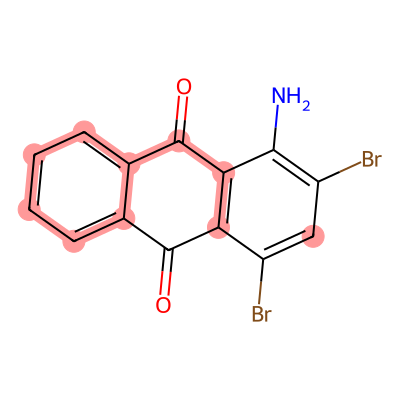

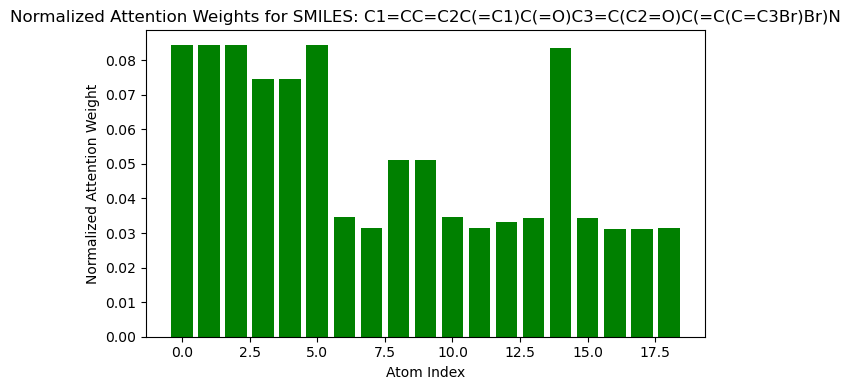

Top 6: SMILES=C1=CC(=CC=C1C2=CC=C(C=C2)N)N, Prob=0.4916
SMILES: C1=CC(=CC=C1C2=CC=C(C=C2)N)N
  Atom 0 (C): Attention Score = 0.0879
  Atom 1 (C): Attention Score = 0.0879
  Atom 2 (C): Attention Score = 0.0406
  Atom 3 (C): Attention Score = 0.0879
  Atom 4 (C): Attention Score = 0.0879
  Atom 5 (C): Attention Score = 0.0755
  Atom 6 (C): Attention Score = 0.0755
  Atom 7 (C): Attention Score = 0.0879
  Atom 8 (C): Attention Score = 0.0879
  Atom 9 (C): Attention Score = 0.0406
  Atom 10 (C): Attention Score = 0.0879
  Atom 11 (C): Attention Score = 0.0879
  Atom 12 (N): Attention Score = 0.0325
  Atom 13 (N): Attention Score = 0.0325


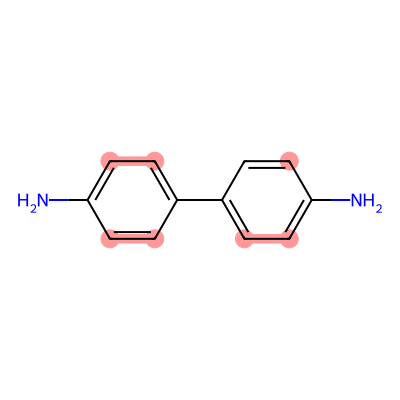

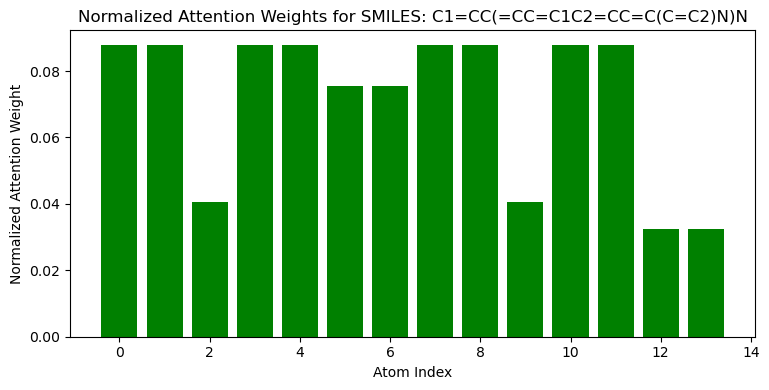

Top 7: SMILES=CC(C)CCCCCCOC(=O)C1=CC=CC=C1C(=O)OCCCCCCC(C)C, Prob=0.4793
SMILES: CC(C)CCCCCCOC(=O)C1=CC=CC=C1C(=O)OCCCCCCC(C)C
  Atom 0 (C): Attention Score = 0.0509
  Atom 1 (C): Attention Score = 0.0418
  Atom 2 (C): Attention Score = 0.0509
  Atom 3 (C): Attention Score = 0.0228
  Atom 4 (C): Attention Score = 0.0222
  Atom 5 (C): Attention Score = 0.0222
  Atom 6 (C): Attention Score = 0.0222
  Atom 7 (C): Attention Score = 0.0222
  Atom 8 (C): Attention Score = 0.0216
  Atom 9 (O): Attention Score = 0.0211
  Atom 10 (C): Attention Score = 0.0209
  Atom 11 (O): Attention Score = 0.0208
  Atom 12 (C): Attention Score = 0.0484
  Atom 13 (C): Attention Score = 0.0560
  Atom 14 (C): Attention Score = 0.0560
  Atom 15 (C): Attention Score = 0.0560
  Atom 16 (C): Attention Score = 0.0560
  Atom 17 (C): Attention Score = 0.0484
  Atom 18 (C): Attention Score = 0.0209
  Atom 19 (O): Attention Score = 0.0208
  Atom 20 (O): Attention Score = 0.0211
  Atom 21 (C): Attention Score = 0.0216
  A

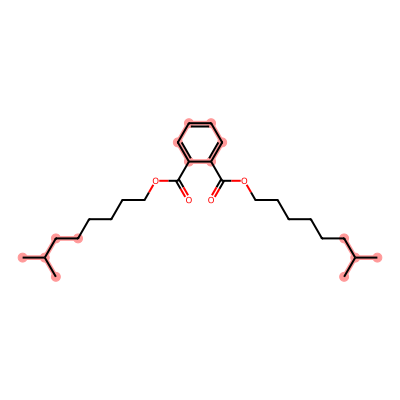

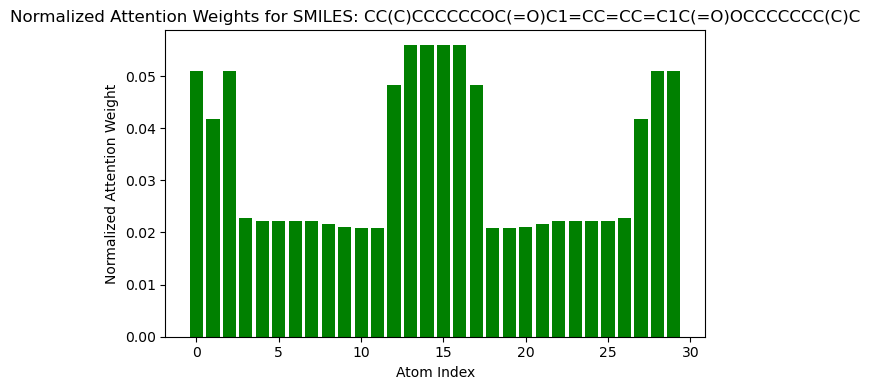


Task lun — Fold 20 (3rd highest AUROC)
Top 1: SMILES=C=CCl, Prob=0.6271
SMILES: C=CCl
  Atom 0 (C): Attention Score = 0.5661
  Atom 1 (C): Attention Score = 0.2219
  Atom 2 (Cl): Attention Score = 0.2120


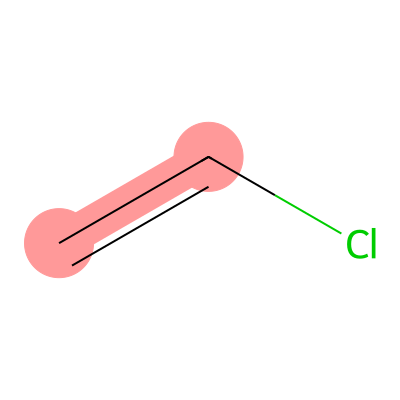

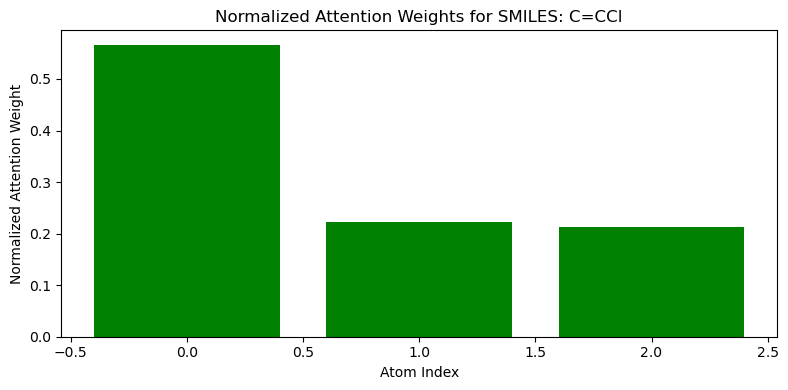

Top 2: SMILES=CCCCCN(C)N=O, Prob=0.6123
SMILES: CCCCCN(C)N=O
  Atom 0 (C): Attention Score = 0.1619
  Atom 1 (C): Attention Score = 0.1547
  Atom 2 (C): Attention Score = 0.1408
  Atom 3 (C): Attention Score = 0.1408
  Atom 4 (C): Attention Score = 0.0658
  Atom 5 (N): Attention Score = 0.0684
  Atom 6 (C): Attention Score = 0.1444
  Atom 7 (N): Attention Score = 0.0612
  Atom 8 (O): Attention Score = 0.0620


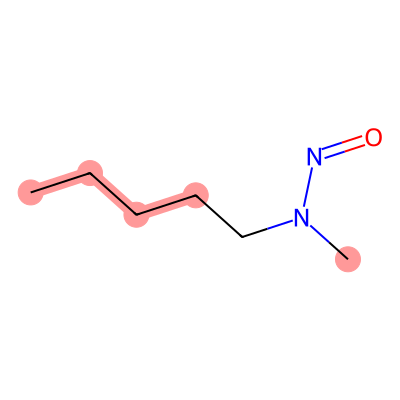

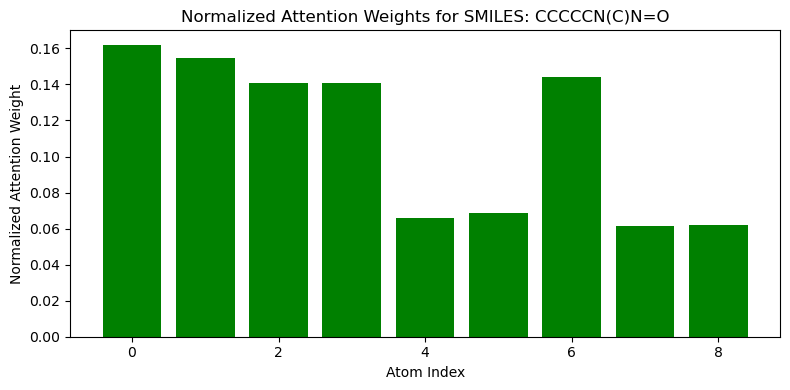

Top 3: SMILES=CCCCCCN(C(=O)N)N=O, Prob=0.5933
SMILES: CCCCCCN(C(=O)N)N=O
  Atom 0 (C): Attention Score = 0.1380
  Atom 1 (C): Attention Score = 0.1344
  Atom 2 (C): Attention Score = 0.1105
  Atom 3 (C): Attention Score = 0.1105
  Atom 4 (C): Attention Score = 0.1105
  Atom 5 (C): Attention Score = 0.0568
  Atom 6 (N): Attention Score = 0.0525
  Atom 7 (C): Attention Score = 0.0566
  Atom 8 (O): Attention Score = 0.0716
  Atom 9 (N): Attention Score = 0.0550
  Atom 10 (N): Attention Score = 0.0515
  Atom 11 (O): Attention Score = 0.0520


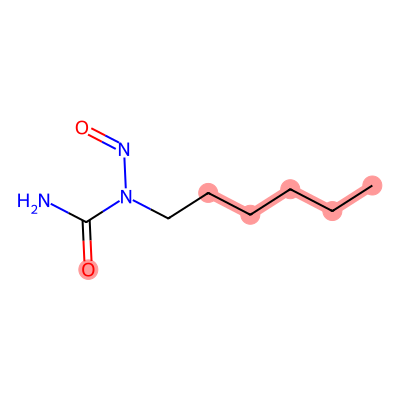

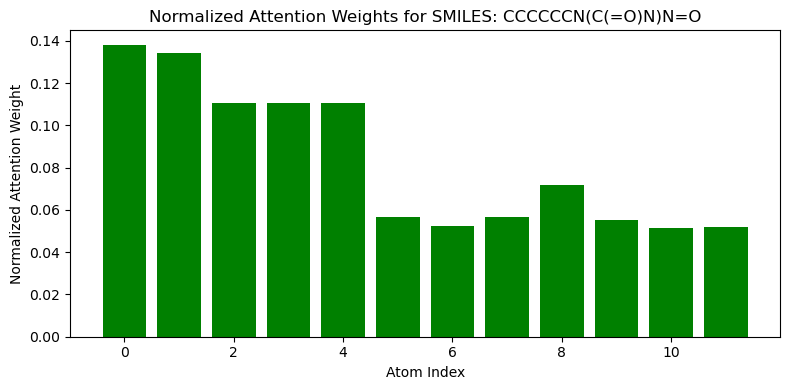

Top 4: SMILES=CN(C)N, Prob=0.5755
SMILES: CN(C)N
  Atom 0 (C): Attention Score = 0.2714
  Atom 1 (N): Attention Score = 0.3287
  Atom 2 (C): Attention Score = 0.2714
  Atom 3 (N): Attention Score = 0.1286


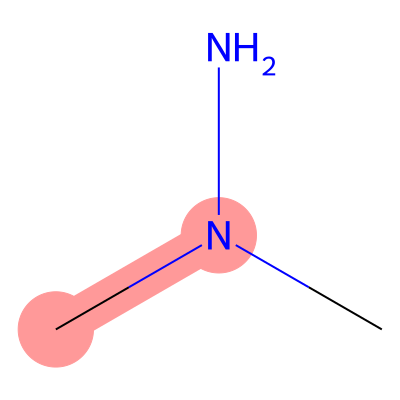

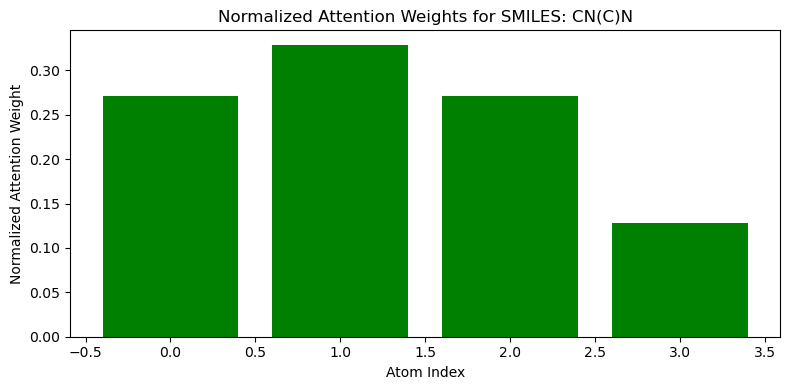

Top 5: SMILES=C1=CC(=C(C=C1C2=CC(=C(C=C2)N)Cl)Cl)N, Prob=0.5254
SMILES: C1=CC(=C(C=C1C2=CC(=C(C=C2)N)Cl)Cl)N
  Atom 0 (C): Attention Score = 0.0902
  Atom 1 (C): Attention Score = 0.0902
  Atom 2 (C): Attention Score = 0.0428
  Atom 3 (C): Attention Score = 0.0351
  Atom 4 (C): Attention Score = 0.0852
  Atom 5 (C): Attention Score = 0.0900
  Atom 6 (C): Attention Score = 0.0900
  Atom 7 (C): Attention Score = 0.0852
  Atom 8 (C): Attention Score = 0.0351
  Atom 9 (C): Attention Score = 0.0428
  Atom 10 (C): Attention Score = 0.0902
  Atom 11 (C): Attention Score = 0.0902
  Atom 12 (N): Attention Score = 0.0333
  Atom 13 (Cl): Attention Score = 0.0332
  Atom 14 (Cl): Attention Score = 0.0332
  Atom 15 (N): Attention Score = 0.0333


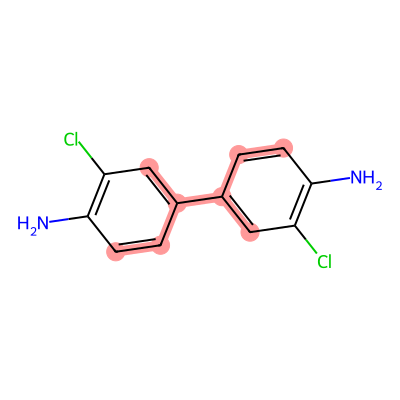

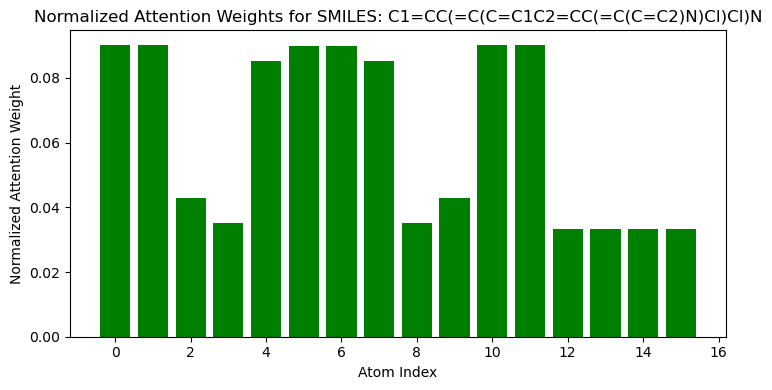

Top 6: SMILES=C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=C(C=C3Br)Br)N, Prob=0.5222
SMILES: C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=C(C=C3Br)Br)N
  Atom 0 (C): Attention Score = 0.0844
  Atom 1 (C): Attention Score = 0.0844
  Atom 2 (C): Attention Score = 0.0844
  Atom 3 (C): Attention Score = 0.0744
  Atom 4 (C): Attention Score = 0.0744
  Atom 5 (C): Attention Score = 0.0844
  Atom 6 (C): Attention Score = 0.0345
  Atom 7 (O): Attention Score = 0.0314
  Atom 8 (C): Attention Score = 0.0512
  Atom 9 (C): Attention Score = 0.0512
  Atom 10 (C): Attention Score = 0.0345
  Atom 11 (O): Attention Score = 0.0314
  Atom 12 (C): Attention Score = 0.0332
  Atom 13 (C): Attention Score = 0.0345
  Atom 14 (C): Attention Score = 0.0836
  Atom 15 (C): Attention Score = 0.0345
  Atom 16 (Br): Attention Score = 0.0311
  Atom 17 (Br): Attention Score = 0.0311
  Atom 18 (N): Attention Score = 0.0313


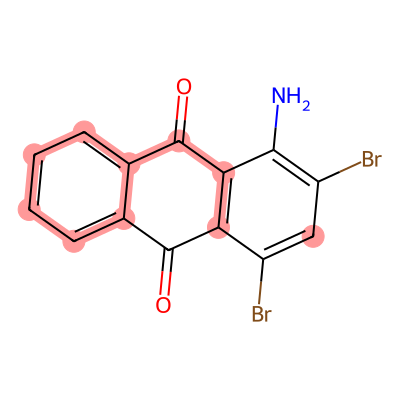

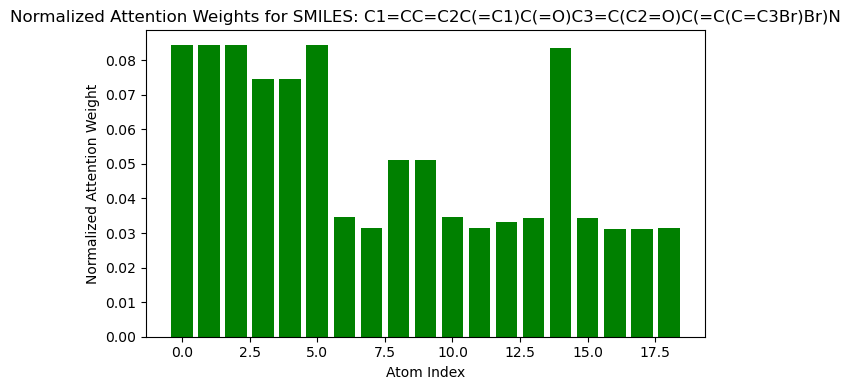

Top 7: SMILES=CC(C)CCCCCCOC(=O)C1=CC=CC=C1C(=O)OCCCCCCC(C)C, Prob=0.4869
SMILES: CC(C)CCCCCCOC(=O)C1=CC=CC=C1C(=O)OCCCCCCC(C)C
  Atom 0 (C): Attention Score = 0.0509
  Atom 1 (C): Attention Score = 0.0418
  Atom 2 (C): Attention Score = 0.0509
  Atom 3 (C): Attention Score = 0.0228
  Atom 4 (C): Attention Score = 0.0222
  Atom 5 (C): Attention Score = 0.0222
  Atom 6 (C): Attention Score = 0.0222
  Atom 7 (C): Attention Score = 0.0222
  Atom 8 (C): Attention Score = 0.0216
  Atom 9 (O): Attention Score = 0.0211
  Atom 10 (C): Attention Score = 0.0209
  Atom 11 (O): Attention Score = 0.0208
  Atom 12 (C): Attention Score = 0.0484
  Atom 13 (C): Attention Score = 0.0560
  Atom 14 (C): Attention Score = 0.0560
  Atom 15 (C): Attention Score = 0.0560
  Atom 16 (C): Attention Score = 0.0560
  Atom 17 (C): Attention Score = 0.0484
  Atom 18 (C): Attention Score = 0.0209
  Atom 19 (O): Attention Score = 0.0208
  Atom 20 (O): Attention Score = 0.0211
  Atom 21 (C): Attention Score = 0.0216
  A

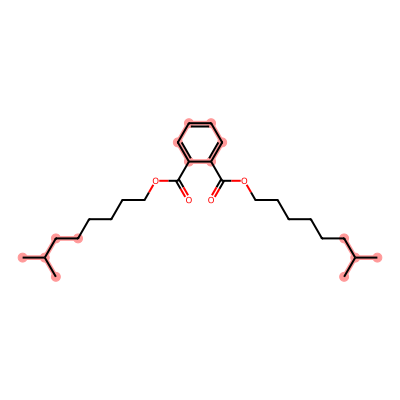

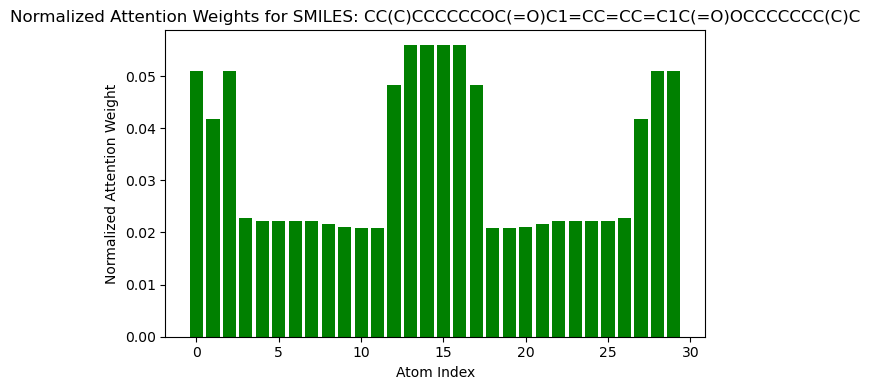


Task sto — Fold 20 (3rd highest AUROC)
Top 1: SMILES=CCCCCN(C)N=O, Prob=0.7323
SMILES: CCCCCN(C)N=O
  Atom 0 (C): Attention Score = 0.1619
  Atom 1 (C): Attention Score = 0.1547
  Atom 2 (C): Attention Score = 0.1408
  Atom 3 (C): Attention Score = 0.1408
  Atom 4 (C): Attention Score = 0.0658
  Atom 5 (N): Attention Score = 0.0684
  Atom 6 (C): Attention Score = 0.1444
  Atom 7 (N): Attention Score = 0.0612
  Atom 8 (O): Attention Score = 0.0620


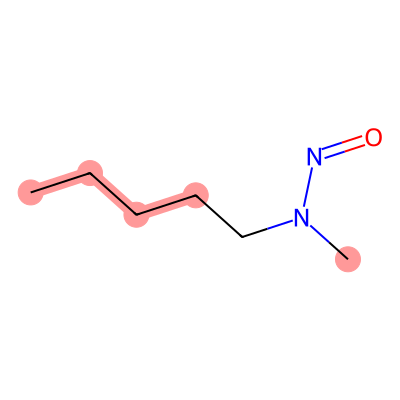

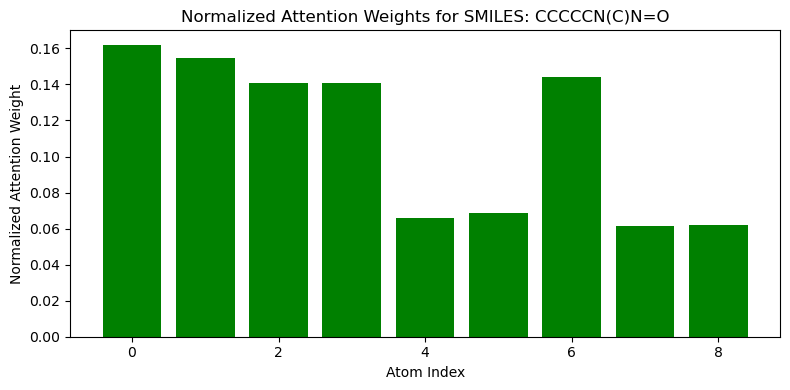

Top 2: SMILES=CCCCCCN(C(=O)N)N=O, Prob=0.6611
SMILES: CCCCCCN(C(=O)N)N=O
  Atom 0 (C): Attention Score = 0.1380
  Atom 1 (C): Attention Score = 0.1344
  Atom 2 (C): Attention Score = 0.1105
  Atom 3 (C): Attention Score = 0.1105
  Atom 4 (C): Attention Score = 0.1105
  Atom 5 (C): Attention Score = 0.0568
  Atom 6 (N): Attention Score = 0.0525
  Atom 7 (C): Attention Score = 0.0566
  Atom 8 (O): Attention Score = 0.0716
  Atom 9 (N): Attention Score = 0.0550
  Atom 10 (N): Attention Score = 0.0515
  Atom 11 (O): Attention Score = 0.0520


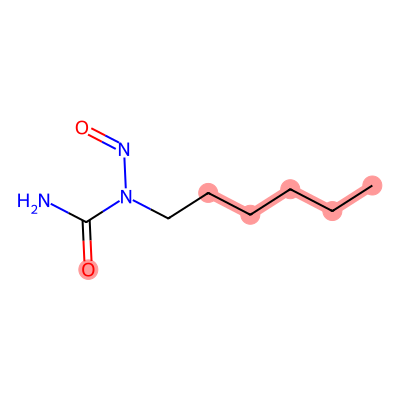

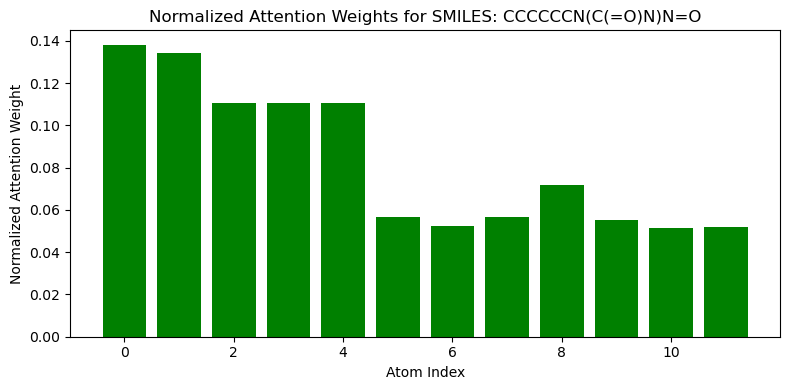

Top 3: SMILES=CN(C)N, Prob=0.6371
SMILES: CN(C)N
  Atom 0 (C): Attention Score = 0.2714
  Atom 1 (N): Attention Score = 0.3287
  Atom 2 (C): Attention Score = 0.2714
  Atom 3 (N): Attention Score = 0.1286


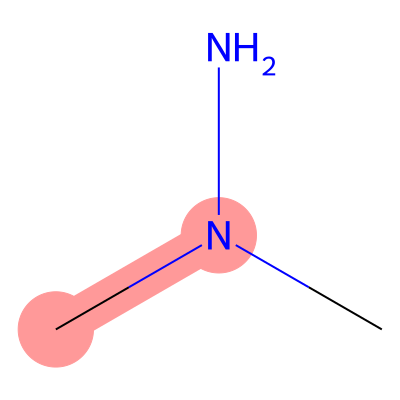

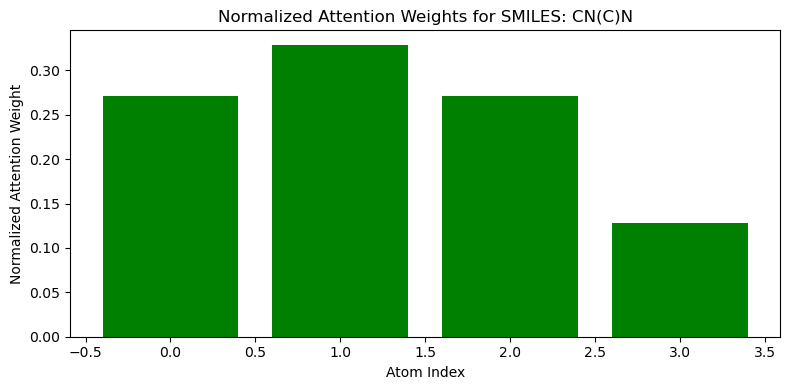

Top 4: SMILES=CC(CN(CC(CO)O)N=O)O, Prob=0.6236
SMILES: CC(CN(CC(CO)O)N=O)O
  Atom 0 (C): Attention Score = 0.1181
  Atom 1 (C): Attention Score = 0.1139
  Atom 2 (C): Attention Score = 0.0471
  Atom 3 (N): Attention Score = 0.0447
  Atom 4 (C): Attention Score = 0.0471
  Atom 5 (C): Attention Score = 0.0907
  Atom 6 (C): Attention Score = 0.1078
  Atom 7 (O): Attention Score = 0.1082
  Atom 8 (O): Attention Score = 0.1174
  Atom 9 (N): Attention Score = 0.0439
  Atom 10 (O): Attention Score = 0.0439
  Atom 11 (O): Attention Score = 0.1174


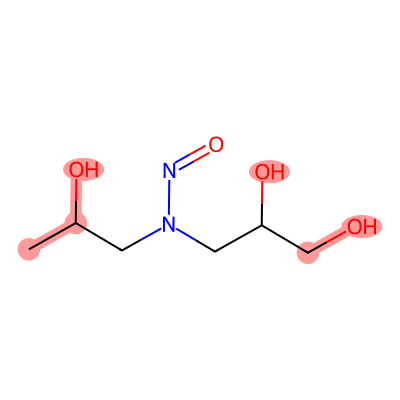

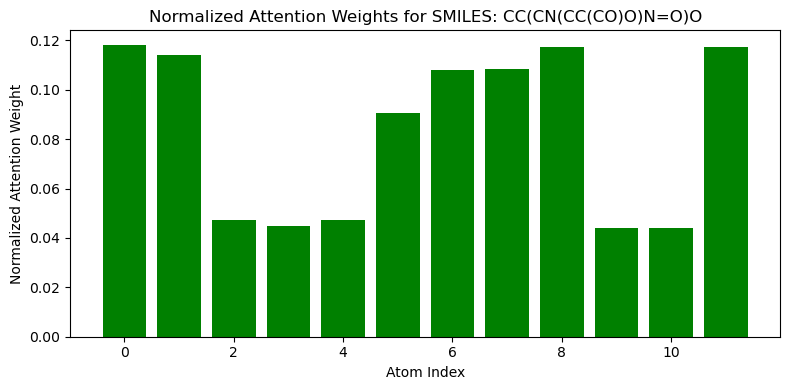

Top 5: SMILES=C1=CC(=C(C=C1C2=CC(=C(C=C2)N)Cl)Cl)N, Prob=0.5695
SMILES: C1=CC(=C(C=C1C2=CC(=C(C=C2)N)Cl)Cl)N
  Atom 0 (C): Attention Score = 0.0902
  Atom 1 (C): Attention Score = 0.0902
  Atom 2 (C): Attention Score = 0.0428
  Atom 3 (C): Attention Score = 0.0351
  Atom 4 (C): Attention Score = 0.0852
  Atom 5 (C): Attention Score = 0.0900
  Atom 6 (C): Attention Score = 0.0900
  Atom 7 (C): Attention Score = 0.0852
  Atom 8 (C): Attention Score = 0.0351
  Atom 9 (C): Attention Score = 0.0428
  Atom 10 (C): Attention Score = 0.0902
  Atom 11 (C): Attention Score = 0.0902
  Atom 12 (N): Attention Score = 0.0333
  Atom 13 (Cl): Attention Score = 0.0332
  Atom 14 (Cl): Attention Score = 0.0332
  Atom 15 (N): Attention Score = 0.0333


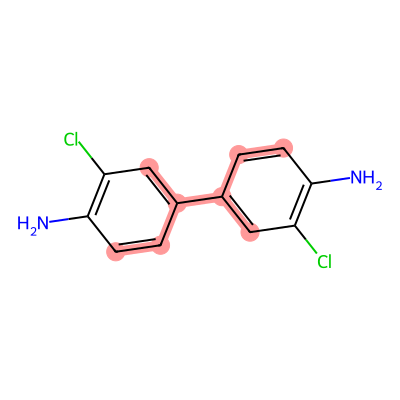

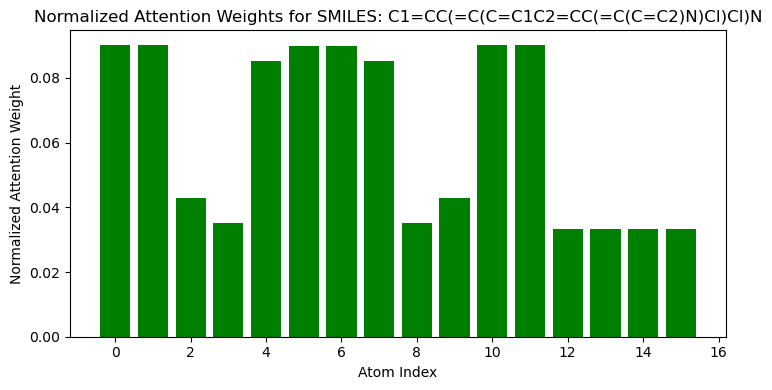

Top 6: SMILES=C=CCl, Prob=0.5572
SMILES: C=CCl
  Atom 0 (C): Attention Score = 0.5661
  Atom 1 (C): Attention Score = 0.2219
  Atom 2 (Cl): Attention Score = 0.2120


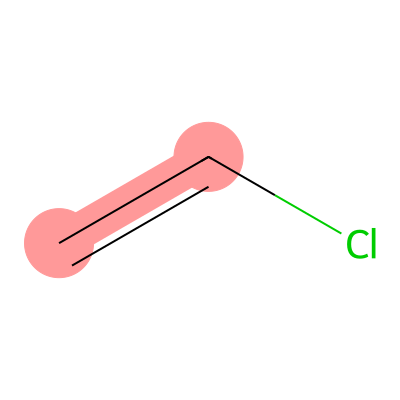

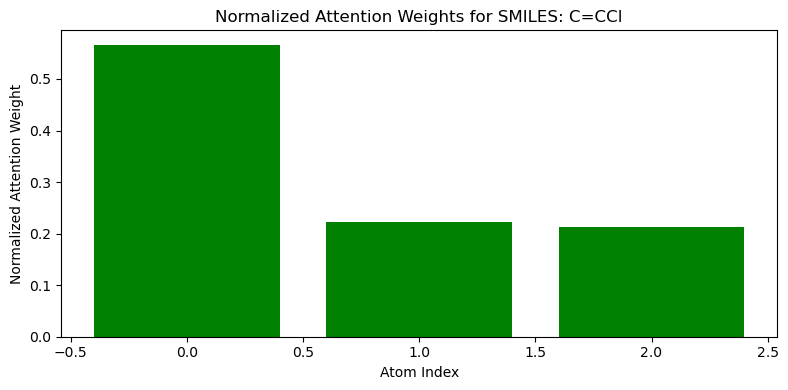

Top 7: SMILES=CC(C)CCCCCCOC(=O)C1=CC=CC=C1C(=O)OCCCCCCC(C)C, Prob=0.5374
SMILES: CC(C)CCCCCCOC(=O)C1=CC=CC=C1C(=O)OCCCCCCC(C)C
  Atom 0 (C): Attention Score = 0.0509
  Atom 1 (C): Attention Score = 0.0418
  Atom 2 (C): Attention Score = 0.0509
  Atom 3 (C): Attention Score = 0.0228
  Atom 4 (C): Attention Score = 0.0222
  Atom 5 (C): Attention Score = 0.0222
  Atom 6 (C): Attention Score = 0.0222
  Atom 7 (C): Attention Score = 0.0222
  Atom 8 (C): Attention Score = 0.0216
  Atom 9 (O): Attention Score = 0.0211
  Atom 10 (C): Attention Score = 0.0209
  Atom 11 (O): Attention Score = 0.0208
  Atom 12 (C): Attention Score = 0.0484
  Atom 13 (C): Attention Score = 0.0560
  Atom 14 (C): Attention Score = 0.0560
  Atom 15 (C): Attention Score = 0.0560
  Atom 16 (C): Attention Score = 0.0560
  Atom 17 (C): Attention Score = 0.0484
  Atom 18 (C): Attention Score = 0.0209
  Atom 19 (O): Attention Score = 0.0208
  Atom 20 (O): Attention Score = 0.0211
  Atom 21 (C): Attention Score = 0.0216
  A

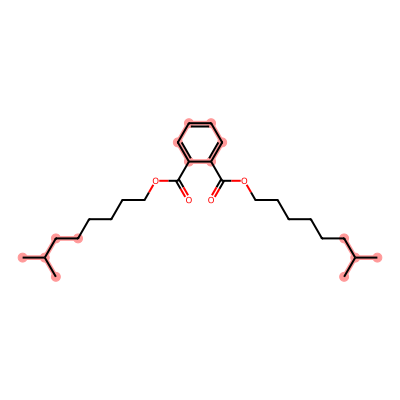

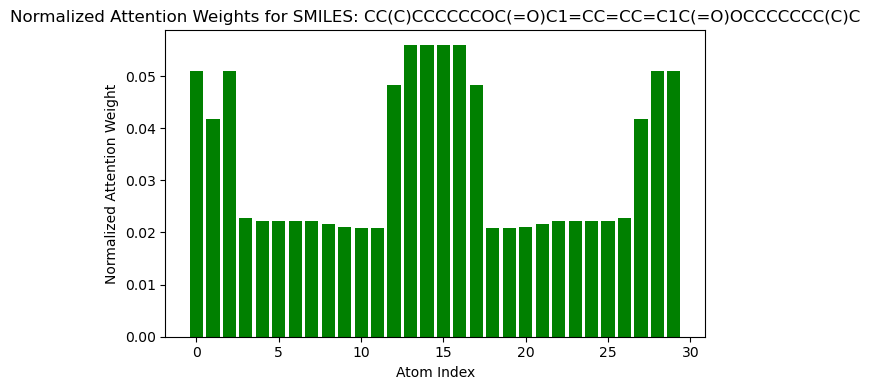

Top 8: SMILES=C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=C(C=C3Br)Br)N, Prob=0.4868
SMILES: C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=C(C=C3Br)Br)N
  Atom 0 (C): Attention Score = 0.0844
  Atom 1 (C): Attention Score = 0.0844
  Atom 2 (C): Attention Score = 0.0844
  Atom 3 (C): Attention Score = 0.0744
  Atom 4 (C): Attention Score = 0.0744
  Atom 5 (C): Attention Score = 0.0844
  Atom 6 (C): Attention Score = 0.0345
  Atom 7 (O): Attention Score = 0.0314
  Atom 8 (C): Attention Score = 0.0512
  Atom 9 (C): Attention Score = 0.0512
  Atom 10 (C): Attention Score = 0.0345
  Atom 11 (O): Attention Score = 0.0314
  Atom 12 (C): Attention Score = 0.0332
  Atom 13 (C): Attention Score = 0.0345
  Atom 14 (C): Attention Score = 0.0836
  Atom 15 (C): Attention Score = 0.0345
  Atom 16 (Br): Attention Score = 0.0311
  Atom 17 (Br): Attention Score = 0.0311
  Atom 18 (N): Attention Score = 0.0313


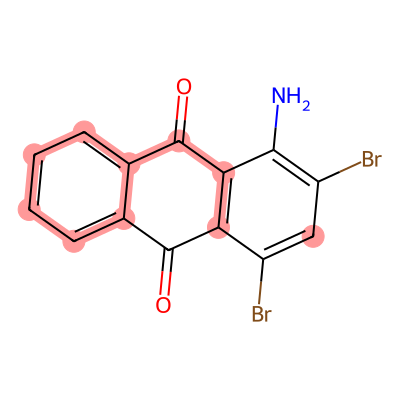

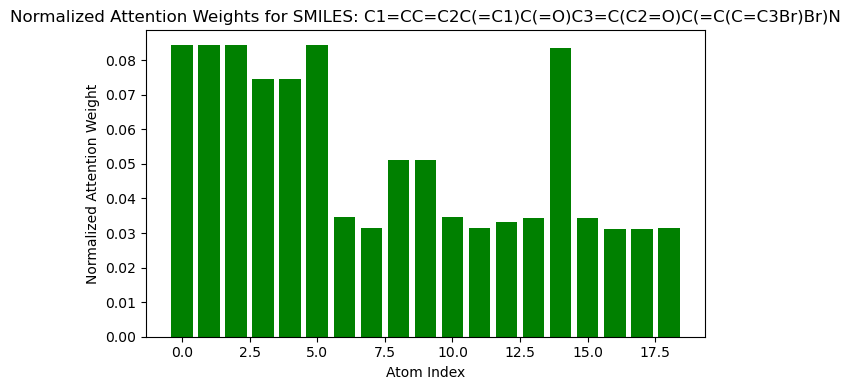


Task mgl — Fold 20 (3rd highest AUROC)
Top 1: SMILES=CN(C)C(=O)NC1=CC(=C(C=C1)Cl)Cl, Prob=0.5177
SMILES: CN(C)C(=O)NC1=CC(=C(C=C1)Cl)Cl
  Atom 0 (C): Attention Score = 0.0462
  Atom 1 (N): Attention Score = 0.0533
  Atom 2 (C): Attention Score = 0.0462
  Atom 3 (C): Attention Score = 0.0443
  Atom 4 (O): Attention Score = 0.0444
  Atom 5 (N): Attention Score = 0.0530
  Atom 6 (C): Attention Score = 0.1196
  Atom 7 (C): Attention Score = 0.1194
  Atom 8 (C): Attention Score = 0.0730
  Atom 9 (C): Attention Score = 0.0730
  Atom 10 (C): Attention Score = 0.1196
  Atom 11 (C): Attention Score = 0.1196
  Atom 12 (Cl): Attention Score = 0.0442
  Atom 13 (Cl): Attention Score = 0.0442


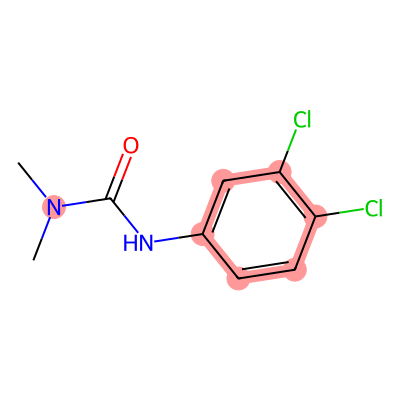

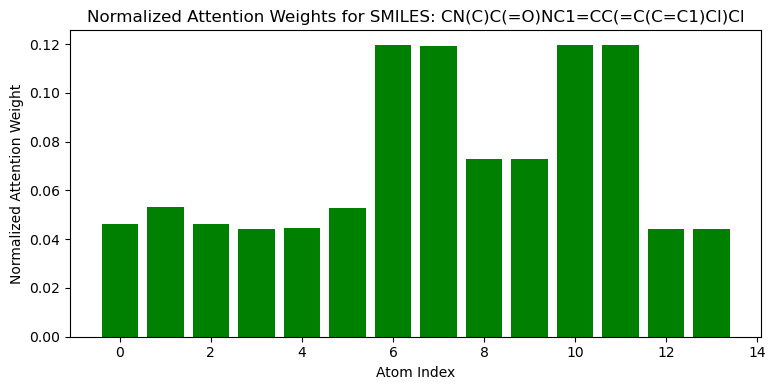

Top 2: SMILES=C1=CC(=C(C=C1C2=CC(=C(C=C2)N)Cl)Cl)N, Prob=0.4903
SMILES: C1=CC(=C(C=C1C2=CC(=C(C=C2)N)Cl)Cl)N
  Atom 0 (C): Attention Score = 0.0902
  Atom 1 (C): Attention Score = 0.0902
  Atom 2 (C): Attention Score = 0.0428
  Atom 3 (C): Attention Score = 0.0351
  Atom 4 (C): Attention Score = 0.0852
  Atom 5 (C): Attention Score = 0.0900
  Atom 6 (C): Attention Score = 0.0900
  Atom 7 (C): Attention Score = 0.0852
  Atom 8 (C): Attention Score = 0.0351
  Atom 9 (C): Attention Score = 0.0428
  Atom 10 (C): Attention Score = 0.0902
  Atom 11 (C): Attention Score = 0.0902
  Atom 12 (N): Attention Score = 0.0333
  Atom 13 (Cl): Attention Score = 0.0332
  Atom 14 (Cl): Attention Score = 0.0332
  Atom 15 (N): Attention Score = 0.0333


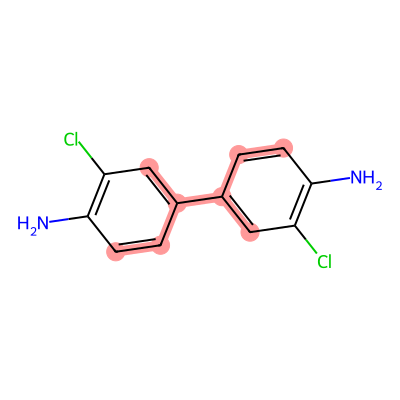

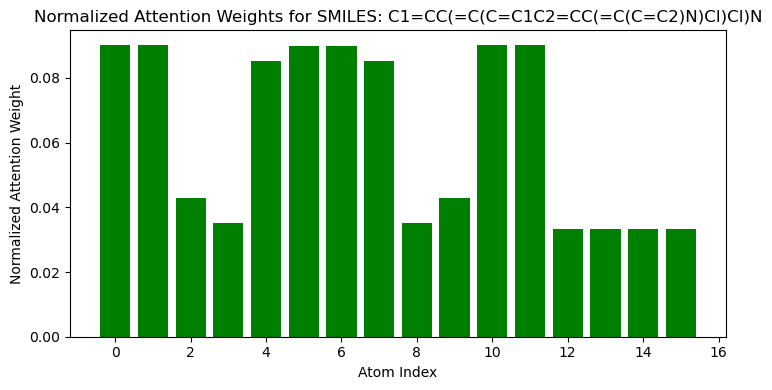

Top 3: SMILES=C=CCl, Prob=0.4849
SMILES: C=CCl
  Atom 0 (C): Attention Score = 0.5661
  Atom 1 (C): Attention Score = 0.2219
  Atom 2 (Cl): Attention Score = 0.2120


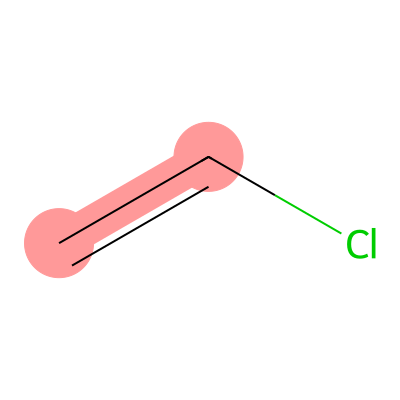

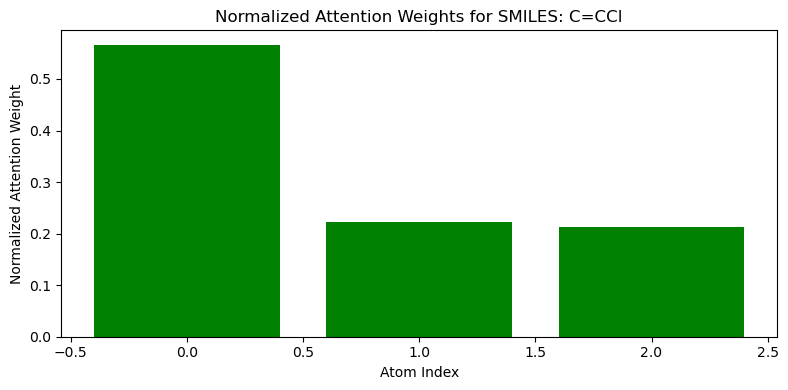

Top 4: SMILES=CC(C)CCCCCCOC(=O)C1=CC=CC=C1C(=O)OCCCCCCC(C)C, Prob=0.4831
SMILES: CC(C)CCCCCCOC(=O)C1=CC=CC=C1C(=O)OCCCCCCC(C)C
  Atom 0 (C): Attention Score = 0.0509
  Atom 1 (C): Attention Score = 0.0418
  Atom 2 (C): Attention Score = 0.0509
  Atom 3 (C): Attention Score = 0.0228
  Atom 4 (C): Attention Score = 0.0222
  Atom 5 (C): Attention Score = 0.0222
  Atom 6 (C): Attention Score = 0.0222
  Atom 7 (C): Attention Score = 0.0222
  Atom 8 (C): Attention Score = 0.0216
  Atom 9 (O): Attention Score = 0.0211
  Atom 10 (C): Attention Score = 0.0209
  Atom 11 (O): Attention Score = 0.0208
  Atom 12 (C): Attention Score = 0.0484
  Atom 13 (C): Attention Score = 0.0560
  Atom 14 (C): Attention Score = 0.0560
  Atom 15 (C): Attention Score = 0.0560
  Atom 16 (C): Attention Score = 0.0560
  Atom 17 (C): Attention Score = 0.0484
  Atom 18 (C): Attention Score = 0.0209
  Atom 19 (O): Attention Score = 0.0208
  Atom 20 (O): Attention Score = 0.0211
  Atom 21 (C): Attention Score = 0.0216
  A

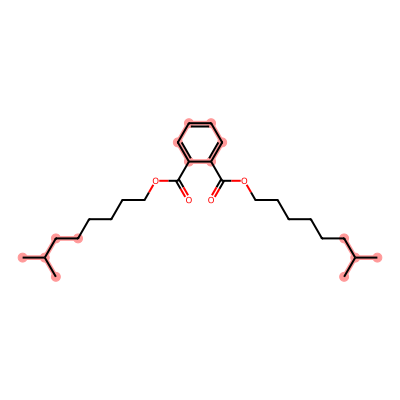

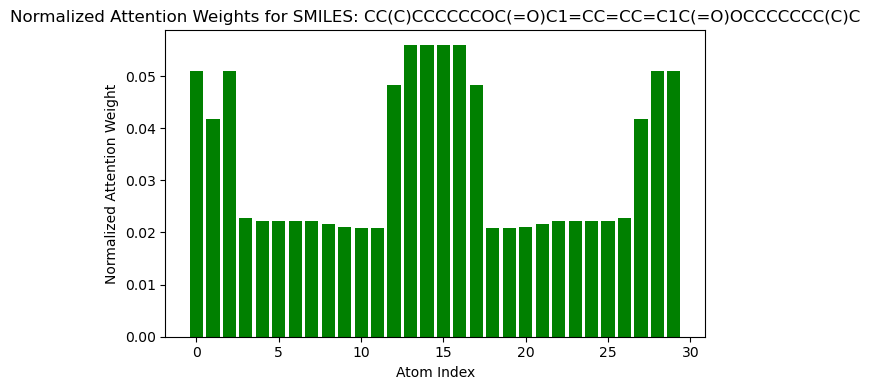

Top 5: SMILES=C1=CC(=CC=C1C2=CC=C(C=C2)N)N, Prob=0.4737
SMILES: C1=CC(=CC=C1C2=CC=C(C=C2)N)N
  Atom 0 (C): Attention Score = 0.0879
  Atom 1 (C): Attention Score = 0.0879
  Atom 2 (C): Attention Score = 0.0406
  Atom 3 (C): Attention Score = 0.0879
  Atom 4 (C): Attention Score = 0.0879
  Atom 5 (C): Attention Score = 0.0755
  Atom 6 (C): Attention Score = 0.0755
  Atom 7 (C): Attention Score = 0.0879
  Atom 8 (C): Attention Score = 0.0879
  Atom 9 (C): Attention Score = 0.0406
  Atom 10 (C): Attention Score = 0.0879
  Atom 11 (C): Attention Score = 0.0879
  Atom 12 (N): Attention Score = 0.0325
  Atom 13 (N): Attention Score = 0.0325


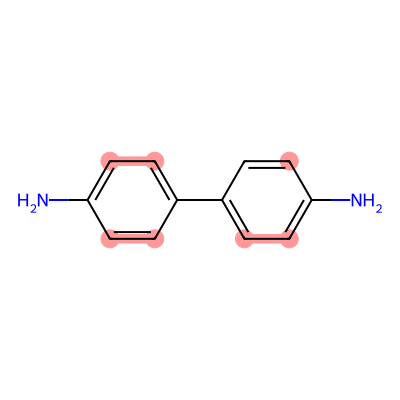

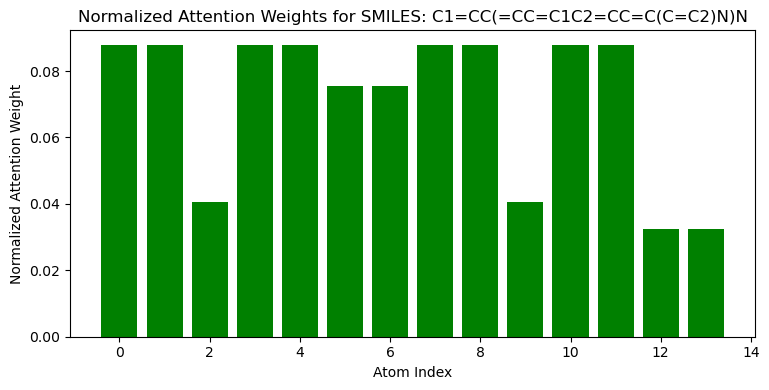

Top 6: SMILES=CCCCCCN(C(=O)N)N=O, Prob=0.4501
SMILES: CCCCCCN(C(=O)N)N=O
  Atom 0 (C): Attention Score = 0.1380
  Atom 1 (C): Attention Score = 0.1344
  Atom 2 (C): Attention Score = 0.1105
  Atom 3 (C): Attention Score = 0.1105
  Atom 4 (C): Attention Score = 0.1105
  Atom 5 (C): Attention Score = 0.0568
  Atom 6 (N): Attention Score = 0.0525
  Atom 7 (C): Attention Score = 0.0566
  Atom 8 (O): Attention Score = 0.0716
  Atom 9 (N): Attention Score = 0.0550
  Atom 10 (N): Attention Score = 0.0515
  Atom 11 (O): Attention Score = 0.0520


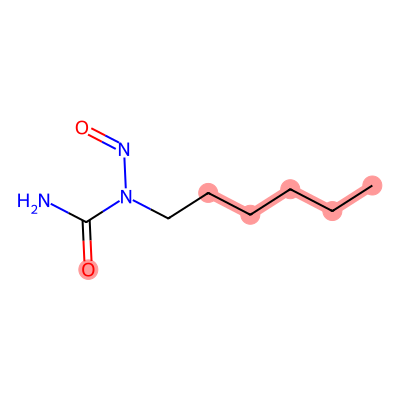

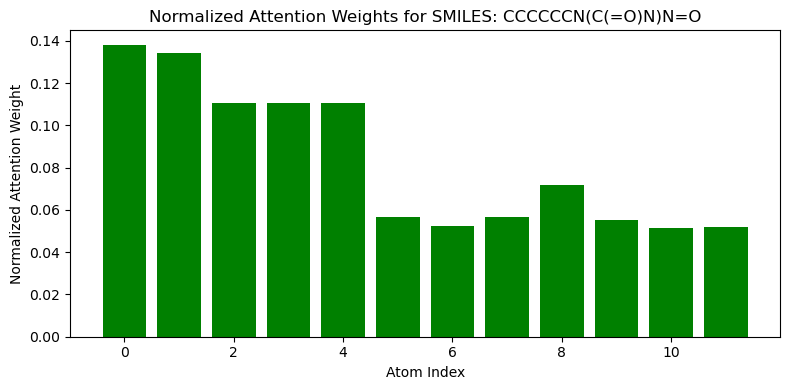

In [11]:
class MultiTaskGAT(nn.Module):
    def __init__(self, num_features, n_heads1, output_dim_idx, dropout, num_tasks=4):
        super(MultiTaskGAT, self).__init__()

        self.conv2 = GATConv(num_features, num_features, heads=n_heads1, dropout=dropout)
        self.relu = nn.ReLU()
        self.graph_norm2 = GraphNorm(num_features * n_heads1)
        
        # Generate task combinations (combinations of 3 out of n_tasks)
        self.task_combinations_2 = list(combinations(range(num_tasks), 3))
        
        # Define hidden layers for each task combination
        self.hidden_layer2 = nn.ModuleList([
            nn.Sequential(
                nn.Linear(num_features * n_heads1, output_dim_idx),
                nn.ReLU(),
                nn.Dropout(dropout),
            ) for _ in self.task_combinations_2
        ])
        
        # Defining the final output layer
        self.final_layer = nn.ModuleList([nn.Linear(output_dim_idx, 1) for _ in range(num_tasks)])
        self.sigmoid = nn.Sigmoid()

        self.attention_net = nn.Sequential(
            nn.Linear(num_features * n_heads1, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

        self.global_attention = GlobalAttention(gate_nn=self.attention_net)
        
        self.node_dropout = nn.Dropout(dropout)
        
        self.weight_matrix = nn.Parameter(torch.ones(len(self.task_combinations_2)))

    def forward(self, data, selected_tasks):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x2 = self.conv2(x, edge_index)
        x = self.graph_norm2(x2, batch)
        x = self.relu(x)
        x = self.node_dropout(x)

        # Attention Pooling
        x, attention_scores = self.global_attention(x, batch)

        # hidden_layer2: 3-task combination
        outputs = {task: [] for task in selected_tasks}
        for idx, (layer, combo) in enumerate(zip(self.hidden_layer2, self.task_combinations_2)):
            if set(combo).issubset(selected_tasks):
                output = layer(x)
                weight = self.weight_matrix[idx]
                for task in combo:
                    outputs[task].append(output * weight)
        
        # Combine the output 
        final_outputs = []
        for task in selected_tasks:
            if outputs[task]:
                combined_output = torch.sum(torch.stack(outputs[task]), dim=0) / len(outputs[task])
                final_output = self.final_layer[task](combined_output).view(-1)
                final_outputs.append(self.sigmoid(final_output))
            else:
                raise IndexError(f"Task {task} has no corresponding output in outputs dictionary.")

        return x, tuple(final_outputs), attention_scores

def visualize_attention_with_highlights(smiles, node_attention, top_percent=0.3):
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Invalid SMILES string: {smiles}")
        return
    num_atoms = mol.GetNumAtoms()
    highlight_atom_indices = []

    if isinstance(node_attention, torch.Tensor):
        node_attention = node_attention.cpu().numpy().tolist()
    elif isinstance(node_attention, np.ndarray):
        node_attention = node_attention.tolist()
    elif isinstance(node_attention, list):
        pass  
    else:
        print(f"Unsupported node_attention type: {type(node_attention)}")
        return

    if len(node_attention) != num_atoms:
        print(f"Warning: Attention scores count ({len(node_attention)}) does not match number of atoms ({num_atoms}).")
        min_len = min(len(node_attention), num_atoms)
        node_attention = node_attention[:min_len]
        num_atoms = min_len

    top_n = max(1, int(np.ceil(top_percent * num_atoms)))
    sorted_indices = sorted(range(num_atoms), key=lambda i: node_attention[i], reverse=True)
    highlight_atom_indices = sorted(sorted_indices[:top_n])
    
    # Node attention score output
    print(f"SMILES: {smiles}")
    for idx, (atom, attn) in enumerate(zip(mol.GetAtoms(), node_attention)):
        print(f"  Atom {idx} ({atom.GetSymbol()}): Attention Score = {attn:.4f}")

    highlight_atom_indices = sorted(set(highlight_atom_indices))
    
    if len(highlight_atom_indices) > 0:
        highlight_colors = {idx: (1.0, 0.6, 0.6) for idx in highlight_atom_indices}
    else:
        highlight_colors = {}

    # Molecular visualisation
    drawer = Draw.MolDraw2DCairo(400, 400)
    opts = drawer.drawOptions()
    opts.highlightColour = (1.0, 0.0, 0.0)
    drawer.DrawMolecule(mol, highlightAtoms=highlight_atom_indices, highlightAtomColors=highlight_colors)
    drawer.FinishDrawing()
    img_data = drawer.GetDrawingText()
    
    img = Image.open(io.BytesIO(img_data))
    display(img)
    
    # Normalised Attention Weights bar graph visualisation
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(node_attention)), node_attention, color='green')
    plt.title(f'Normalized Attention Weights for SMILES: {smiles}')
    plt.xlabel('Atom Index')
    plt.ylabel('Normalized Attention Weight')
    plt.tight_layout()
    plt.show()

# Define a function to output performance metrics
def printPerformance_multi(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = np.nan
    try:
        pr_auc = average_precision_score(y_true, y_pred)
    except ValueError:
        pr_auc = np.nan
    y_pred_labels = (y_pred >= 0.45).astype(int)
    accuracy = accuracy_score(y_true, y_pred_labels)
    print(f"  AUC: {auc:.4f}, PR AUC: {pr_auc:.4f}, Accuracy: {accuracy:.4f}")


def extract_attention_scores_per_molecule(batch, node_attention, smiles):
    
    attention_scores_per_molecule = []
    selected_smiles = []
    
    num_molecules = batch.num_graphs
    
    for i in range(num_molecules):
        node_indices = (batch.batch == i).nonzero(as_tuple=True)[0]
        molecule_attention = node_attention[node_indices].cpu().numpy().flatten().tolist()
        molecule_smiles = smiles[i]
        selected_smiles.append(molecule_smiles)
        
        mol = Chem.MolFromSmiles(molecule_smiles)
        if mol is None:
            print(f"Invalid SMILES string: {molecule_smiles}")
            attention_scores_per_molecule.append([])
            continue
        
        num_atoms = mol.GetNumAtoms()
        atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
        
        if len(molecule_attention) != num_atoms:
            print(f"Warning: Attention scores count ({len(molecule_attention)}) does not match number of atoms ({num_atoms}).")
        
        attention_scores_per_molecule.append(molecule_attention)
    
    return attention_scores_per_molecule, selected_smiles

def save_predictions_to_csv(all_fold_results, list_tissue, output_dir='prediction_results'):
    
    os.makedirs(output_dir, exist_ok=True)
    
    task_data = {task: {'fold': [], 'smiles': [], 'y_true': [], 'y_pred': []} for task in list_tissue}
    
    for fold_result in all_fold_results:
        fold = fold_result['fold']
        smiles_list = fold_result['smiles']
        task_metrics = fold_result['task_metrics']
        
        for task_idx, task_name in enumerate(list_tissue):
            task_key = f"task_{task_idx}"
            y_true = task_metrics[task_key]['y_true']
            y_pred = task_metrics[task_key]['y_pred']
            
            for i, smiles in enumerate(smiles_list):
                task_data[task_name]['fold'].append(fold)
                task_data[task_name]['smiles'].append(smiles)
                task_data[task_name]['y_true'].append(y_true[i])
                task_data[task_name]['y_pred'].append(y_pred[i])
    
    for task_name, data in task_data.items():
        df = pd.DataFrame(data)
        csv_path = os.path.join(output_dir, f'{task_name}_predictions.csv')
        df.to_csv(csv_path, index=False)
        print(f"Saved predictions for task '{task_name}' to {csv_path}")

def test_and_collect(model, criterion, test_loader, device, list_tissue):
    model.eval()
    task_losses = defaultdict(float)
    num_batches = defaultdict(int)
    task_metrics = defaultdict(lambda: {'y_true': [], 'y_pred': []})
    
    all_node_attention_scores = []
    all_smiles = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            
            x, list_task, node_attention_scores = model(batch, selected_tasks=tuple(range(len(list_tissue))))
            
            for task_idx, task in enumerate(list_tissue):
                task_key = f"task_{task_idx}"
                task_metrics[task_key]['y_true'].extend(batch.y[:, task_idx].cpu().tolist())
                task_metrics[task_key]['y_pred'].extend(list_task[task_idx].cpu().tolist())

            attention_scores_per_molecule, selected_smiles = extract_attention_scores_per_molecule(
                batch, node_attention_scores, smiles=batch.smiles)
            all_node_attention_scores.extend(attention_scores_per_molecule)
            all_smiles.extend(selected_smiles)

    task_results = {}
    
    for task_idx, task_name in enumerate(list_tissue):
        task_key = f"task_{task_idx}"
        if task_key in task_metrics:
            y_true = np.array(task_metrics[task_key]['y_true'])
            y_pred = np.array(task_metrics[task_key]['y_pred'])
            try:
                auc = roc_auc_score(y_true, y_pred)
            except ValueError:
                auc = np.nan

            try:
                pr_auc = average_precision_score(y_true, y_pred)
            except ValueError:
                pr_auc = np.nan

            y_pred_labels = (y_pred >= 0.45).astype(int)
            accuracy = accuracy_score(y_true, y_pred_labels)
            avg_loss = np.nan  
            task_results[task_key] = {
                'loss': avg_loss,
                'auc': auc,
                'pr_auc': pr_auc,
                'accuracy': accuracy
            }
        else:
            task_results[task_key] = {
                'loss': np.nan,
                'auc': np.nan,
                'pr_auc': np.nan,
                'accuracy': np.nan
            }
    return task_results, task_metrics, all_node_attention_scores, all_smiles

def main():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    K = 20
    list_tissue = ["liv", "lun", "sto", "mgl"]

    data_dir = '/data/home/dbswn0814/2025JCM/model/multi task3/data'
    models_dir = '/data/home/dbswn0814/2025JCM/model/multi task3/model'

    model = MultiTaskGAT(
        num_features=75, n_heads1=2,
        output_dim_idx=16, dropout=0.2,
        num_tasks=len(list_tissue)
    ).to(device)
    criterion = FocalLoss(alpha=0.25, gamma=4.0, reduction='mean')

    all_fold_results = []
    fold_attention_data = {}
    all_task_results = defaultdict(lambda: {'auc': [], 'pr_auc': [], 'accuracy': []})

    for fold in range(1, K+1):
        test_path = os.path.join(data_dir, f'fold_{fold}_test.pt')
        model_path = os.path.join(models_dir, f'fold_{fold}_final.pth')
        if not os.path.exists(test_path) or not os.path.exists(model_path):
            print(f"Skipping fold {fold}: data or model file missing.")
            continue

        test_dataset = torch.load(test_path)
        test_loader = TorchDataLoader(
            test_dataset, batch_size=8,
            shuffle=False, collate_fn=Batch.from_data_list
        )
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint)
        model.eval()

        test_results, task_metrics, attn_scores, smiles_list = test_and_collect(
            model, criterion, test_loader, device, list_tissue
        )

        all_fold_results.append({
            'fold': fold,
            'test_results': test_results,
            'task_metrics': task_metrics,
            'node_attention_scores': attn_scores,
            'smiles': smiles_list
        })
        fold_attention_data[fold] = {
            'test_results': test_results,
            'task_metrics': task_metrics,
            'node_attention_scores': attn_scores,
            'smiles': smiles_list
        }
        for key, res in test_results.items():
            all_task_results[key]['auc'].append(res['auc'])
            all_task_results[key]['pr_auc'].append(res['pr_auc'])
            all_task_results[key]['accuracy'].append(res['accuracy'])

    print("\n=== Average results across all folds ===")
    for idx, name in enumerate(list_tissue):
        key = f"task_{idx}"
        aucs = np.array(all_task_results[key]['auc'])
        pr_aucs = np.array(all_task_results[key]['pr_auc'])
        accs = np.array(all_task_results[key]['accuracy'])
        print(f"Task {name}: AUC={np.nanmean(aucs):.4f}±{np.nanstd(aucs):.4f}, "
              f"PR AUC={np.nanmean(pr_aucs):.4f}±{np.nanstd(pr_aucs):.4f}, "
              f"Acc={np.nanmean(accs):.4f}")

    pr_list = []
    for fr in all_fold_results:
        pr_vals = [fr['test_results'][f"task_{i}"]['pr_auc'] for i in range(len(list_tissue))]
        pr_list.append((fr['fold'], np.nanmean(pr_vals)))
    pr_sorted = sorted(pr_list, key=lambda x: x[1], reverse=True)
    if pr_sorted:
        best_fold, best_pr = pr_sorted[0]
        worst_fold, worst_pr = pr_sorted[-1]
        print(f"\nBest fold(PR AUC): {best_fold} ({best_pr:.4f}), Worst fold(PR AUC): {worst_fold} ({worst_pr:.4f})")

    auc_list = []
    for fr in all_fold_results:
        auc_vals = [fr['test_results'][f"task_{i}"]['auc'] for i in range(len(list_tissue))]
        auc_list.append((fr['fold'], np.nanmean(auc_vals)))
    auc_sorted = sorted(auc_list, key=lambda x: x[1], reverse=True)

    if len(auc_sorted) >= 4:
        third_fold, third_auc = auc_sorted[3]
        print(f"\nFold with the 3rd highest average AUROC: Fold {third_fold} ({third_auc:.4f})")

        data3 = fold_attention_data[third_fold]
        tm3 = data3['task_metrics']
        ns3 = data3['node_attention_scores']
        sm3 = data3['smiles']

        task_details_3rd = {f"task_{i}": [] for i in range(len(list_tissue))}
        for i, (attn, smi) in enumerate(zip(ns3, sm3)):
            for idx in range(len(list_tissue)):
                key = f"task_{idx}"
                if tm3[key]['y_true'][i] == 1 and tm3[key]['y_pred'][i] >= 0.45:
                    task_details_3rd[key].append((smi, attn))

        for idx, name in enumerate(list_tissue):
            key = f"task_{idx}"
            print("\n" + "="*80)
            print(f"Task {name} — Fold {third_fold} (3rd highest AUROC)")
            if not task_details_3rd[key]:
                print("  No positive samples with y_true=1 & y_pred>=0.45.")
                continue

            # top 10 by probability
            preds = np.array(tm3[key]['y_pred'])
            pos_idx = [
                i for i, (yt, yp) in enumerate(zip(tm3[key]['y_true'], tm3[key]['y_pred']))
                if yt == 1 and yp >= 0.45
            ]
            pos_data = [(preds[i], task_details_3rd[key][j]) for j, i in enumerate(pos_idx)]
            top_data = sorted(pos_data, key=lambda x: x[0], reverse=True)[:10]

            for rank, (prob, (smi, attn)) in enumerate(top_data, 1):
                print(f"Top {rank}: SMILES={smi}, Prob={prob:.4f}")
                visualize_attention_with_highlights(smi, attn, top_percent=0.5)
    else:
        print("fail.")
        
if __name__ == "__main__":
    main()